## Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from time import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l1_l2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import norm
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller,kpss
from arch.unitroot import PhillipsPerron

## Data Collection

### CCAR Variables

In [226]:
# Time period
end = '2023-04-30'
start = '1982-1-1'

# FRED, Bloomberg, Yahoo Finance Data
Y_ticker = ["^VIX"]
X_ticker1 = ["SPY","GC=F","DX-Y.NYB"]
Fred_data1 = ["GDP","GDPC1","A067RL1Q156SBEA","A067RP1Q027SBEA","UNRATE","CPIAUCSL","TB3MS","GS5","GS10","MPRIME","BOGZ1FL075035243Q","BOGZ1FL075035503Q"]
Fred_data2 = ["MORTGAGE30US"]
X2 = web.DataReader(Fred_data1,'fred',start,end)
Y = yf.download(Y_ticker, start=start, end=end, progress = False,group_by="ticker")
Y = pd.DataFrame(Y['Adj Close'])
X3 = web.DataReader(Fred_data2,'fred','1981-12-01','2023-04-30')
Dow_jones = web.DataReader('BOGZ1FL073164013Q','fred',start,end)
Y_SPX = yf.download('^SPX',start=start, end=end, progress = False,group_by="ticker")
Y_SPX = pd.DataFrame(Y_SPX['Adj Close'])


### Additional Variables

In [227]:
Fred_data3 = ["UMCSENT","DFF","PPIACO","M1SL","M2SL","ICSA","STLFSI4","BAMLC0A4CBBB"]
X2_add = web.DataReader(Fred_data3,'fred',start,end)
dollar= yf.download('DX-Y.NYB', start=start, end=end, progress = False,group_by="ticker")
dollar = pd.DataFrame(dollar['Adj Close'])

### Defining Column Names

In [228]:
# Define column names
col_name1={'GDP':'Nom GDP', 'GDPC1':'Real GDP','A067RL1Q156SBEA':'Real Disp Income','A067RP1Q027SBEA':'Nom Disp Income','UNRATE':'Unemp Rate','CPIAUCSL':'CPI','TB3MS':'3m TSY','GS5':'5Y TSY','GS10':'10Y TSY','MPRIME':'Prime Rate', 'BOGZ1FL075035243Q': 'HPI', 'BOGZ1FL075035503Q': 'Commercial REI'}
col_name2 = {'MORTGAGE30US':'Mortgage Rate'}
dj_col = {'BOGZ1FL073164013Q':'Dow Jones Total'}
Y_col = {'Adj Close':'VIX'}
spx = {'Adj Close':'SPX'}

# Additional variables column names
col_names_add = {'UMCSENT':'MCSI', 'DFF': 'Effective Federal Fund Rate', 'PPIACO': 'PPI', 'M1SL': 'M1','M2SL':'M2','ICSA': 'ICSA','BAMLC0A4CBBB': 'OAS BBB Corp'}
dollar_col = {'Adj Close': 'Dollar'}

## Data Cleaning and Preprocessing 

### Renaming Column Names and Datetimes

In [229]:
# Function to rename columns
def rename_columns(S,column_name):
    S = S.rename(columns=column_name)
    return S

In [230]:
# Rename columns by replacing ticker names with actual variable names
fred_1 = rename_columns(X2,col_name1)
fred_2 = rename_columns(X3,col_name2)
Dow_jones_qtr = rename_columns(Dow_jones,dj_col)
Y = rename_columns(Y,Y_col)
dollar = rename_columns(dollar,dollar_col)

# Additonal variables data
fred_3 = rename_columns(X2_add,col_names_add)
Y_SPX1 = rename_columns(Y_SPX,spx)

In [231]:
# Function to convert datetime to date only
def date_time(S):
    S.index = S.index.date
    S.index = pd.to_datetime(S.index)
    return S

In [232]:
# Changing datetime variables to date only variables
dollar_index = date_time(dollar)
Y_index = date_time(Y)
Y_SPX2 = date_time(Y_SPX1)

# Max value of VIX and Last value of Dollar Index
VIX_monthly = Y_index.resample('M').last()
dollar_monthly = dollar_index.resample('M').last()
SPX_monthly = Y_SPX2.resample('M').last()
SPX_monthly_pct = SPX_monthly.pct_change()*100

### Extracting Data from initial daataframe

In [233]:
# Extract each variable from dataframe and store in Dataframe
real_gdp_qtr = pd.DataFrame(fred_1['Real GDP'])
nom_gdp_qtr = pd.DataFrame(fred_1['Nom GDP'])
nom_disp_inc_qtr = pd.DataFrame(fred_1['Nom Disp Income'])
real_disp_inc_qtr = pd.DataFrame(fred_1['Real Disp Income'])
unemp_rate_monthly = pd.DataFrame(fred_1['Unemp Rate']).resample('M').max()
CPI_monthly = pd.DataFrame(fred_1['CPI'])
tsy_3m_monthly = pd.DataFrame(fred_1['3m TSY']).resample('M').max()
tsy_5y_monthly = pd.DataFrame(fred_1['5Y TSY']).resample('M').max()
tsy_10y_monthly = pd.DataFrame(fred_1['10Y TSY']).resample('M').max()
prime_rate_monthly = pd.DataFrame(fred_1['Prime Rate']).resample('M').max()
HPI_qtr = pd.DataFrame(fred_1['HPI'])
REI_qtr = pd.DataFrame(fred_1['Commercial REI'])

In [234]:
CPI_monthly

CPI
DATE               
1982-01-01   94.400
1982-02-01   94.700
1982-03-01   94.700
1982-04-01   95.000
1982-05-01   95.900
...             ...
2022-12-01  298.990
2023-01-01  300.536
2023-02-01  301.648
2023-03-01  301.808
2023-04-01  302.918

[496 rows x 1 columns]

### Data Cleaning

In [235]:
# Function to calculate growth rate and convert to month
def growth_calc_to_monthly(S,n):
    growth1 = pd.DataFrame(S.dropna())
    growth2 = (((1+ growth1.pct_change())**4)-1)*100
    growth2.index = growth2.index.shift(3,freq='MS')
    growth2 = (growth2.asfreq('MS',method='ffill')/n).resample('M').max()
    return growth2

In [236]:
# Function to convert weekly to monthly data (One period forward shift)
def weekly_to_monthly(S):
    monthly = S.resample('M').mean()
    monthly.index = monthly.index.shift(1,freq='M')
    return monthly

In [237]:
# Function to convert quarterly to monthly (Forwardfill)
def quarterly_to_monthly_forwardfill(S,n):
    monthly = pd.DataFrame(S.dropna())
    monthly.index = monthly.index.shift(3,freq='MS')
    monthly = (monthly.asfreq('MS',method='ffill')/n).resample('M').max()
    return monthly

In [238]:
# Convert weekly data to monthly data
mortgage_monthly = fred_2.resample('M').last()

# Convert quarterly data to monthly data
nom_disp_inc_monthly = quarterly_to_monthly_forwardfill(nom_disp_inc_qtr,3)
real_disp_inc_monthly = quarterly_to_monthly_forwardfill(real_disp_inc_qtr,3)
nom_gdp_monthly_growth = growth_calc_to_monthly(nom_gdp_qtr,3)
real_gdp_monthly_growth = growth_calc_to_monthly(real_gdp_qtr,3)
HPI_monthly = quarterly_to_monthly_forwardfill(HPI_qtr,1000)
REI_monthly = quarterly_to_monthly_forwardfill(REI_qtr,1000)
Dow_jones_monthly = quarterly_to_monthly_forwardfill(Dow_jones_qtr,1000)


# Taking percentage of indices
CPI_monthly_pct = pd.DataFrame(fred_1['CPI'].pct_change()*100).resample('M').max()
Dow_jones_qtr_pct = Dow_jones_qtr.pct_change()*100
Dow_jones_qtr_pct = Dow_jones_qtr_pct.dropna()
Dow_jones_qtr_pct_1 = quarterly_to_monthly_forwardfill(Dow_jones_qtr_pct,3)
HPI_qtr_pct = HPI_qtr.dropna()
HPI_qtr_pct2 = quarterly_to_monthly_forwardfill(HPI_qtr_pct.pct_change()*100,3)
REI_qtr_pct = REI_qtr.dropna()
REI_qtr_pct2 = quarterly_to_monthly_forwardfill(REI_qtr_pct.pct_change()*100,3)

### Combining to a dataframe

In [239]:
cols = [unemp_rate_monthly,CPI_monthly_pct,tsy_3m_monthly,tsy_5y_monthly,tsy_10y_monthly,mortgage_monthly,prime_rate_monthly,VIX_monthly]
ccardata_comb = pd.concat(cols,axis=1)
ccardata_comb

Unemp Rate       CPI  3m TSY  5Y TSY  10Y TSY  Mortgage Rate  \
1981-12-31         NaN       NaN     NaN     NaN      NaN          17.04   
1982-01-31         8.6       NaN   12.28   14.65    14.59          17.59   
1982-02-28         8.9  0.317797   13.48   14.54    14.43          17.52   
1982-03-31         9.0  0.000000   12.68   13.98    13.86          17.04   
1982-04-30         9.3  0.316790   12.70   14.00    13.87          16.81   
...                ...       ...     ...     ...      ...            ...   
2022-12-31         3.5  0.131280    4.25    3.76     3.62           6.42   
2023-01-31         3.4  0.517074    4.54    3.64     3.53           6.13   
2023-02-28         3.6  0.370006    4.65    3.94     3.75           6.50   
2023-03-31         3.5  0.053042    4.69    3.82     3.66           6.32   
2023-04-30         3.4  0.367783    4.92    3.54     3.46           6.43   

            Prime Rate        VIX  
1981-12-31         NaN        NaN  
1982-01-31       15.75        NaN  
1982-02-28       16.56        NaN  
1982-03-31       16.50        NaN  
1982-04-30       16.50        NaN  
...                ...        ...  
2022-12-31        7.27  21.670000  
2023-01-31        7.50  19.400000  
2023-02-28        7.74  20.700001  
2023-03-31        7.82  18.700001  
2023-04-30        8.00  15.780000  

[497 rows x 8 columns]

### Additional Variables Cleaning 

In [240]:
option_vols = pd.read_excel('Option Volume Data.xlsx',index_col ='Dates')
option_vols.index.name = "Date"

# S&P 500 Options volume 
call_vol = option_vols['CBOE SP500 Call volume']
put_vol = option_vols['CBOE SP500 Put volume']
option_volume = pd.concat([call_vol,put_vol],axis=1)
option_volume = pd.DataFrame(option_volume.dropna())

# Additional variables
option_volume_monthly = option_volume.resample('M').sum()
put_call_ratio_monthly = pd.DataFrame(option_volume_monthly.iloc[:,1]/option_volume_monthly.iloc[:,0])
put_call_ratio_monthly.columns = ['Put/Call ratio']


In [241]:
fred_add_var = fred_3.resample('M').mean()
effr = fred_3['Effective Federal Fund Rate'].resample('M').last()
mcsi = fred_3['MCSI'].resample('M').last()
ppi = fred_3['PPI'].resample('M').last()
m1 = fred_3['M1'].resample('M').last()
m2 = fred_3['M2'].resample('M').last()
icsa = fred_3['ICSA'].resample('M').sum()
bbb_corp = fred_3['OAS BBB Corp'].resample('M').last().dropna()
new_cols = [effr,mcsi,ppi,m1,m2,icsa,bbb_corp,dollar_monthly,SPX_monthly_pct,put_call_ratio_monthly,VIX_monthly]
add_var = pd.concat(new_cols,axis=1)
ccardata_monthly_features = add_var.dropna()

### Combining CCAR and Additional Variables and taking %age change

In [242]:
# % Difference
S1_unemp_rate = ccardata_comb['Unemp Rate'].diff()
S2_3m_tsy = ccardata_comb['3m TSY'].diff()
S3_5y_tsy = ccardata_comb['5Y TSY'].diff()
S4_10y_tsy = ccardata_comb['10Y TSY'].diff()
S5_mort_rate = ccardata_comb['Mortgage Rate'].diff()
S6_prime_rate = ccardata_comb['Prime Rate'].diff()
S7_EFFR = add_var['Effective Federal Fund Rate'].diff()
S8_BBB = add_var['OAS BBB Corp'].diff()

# % Change
S9_MCSI = (add_var['MCSI'].pct_change())*100
S10_PPI = (add_var['PPI'].pct_change())*100
S11_M1 = (add_var['M1'].pct_change())*100
S12_M2 = (add_var['M2'].pct_change())*100
S13_ICSA = (add_var['ICSA'].pct_change())*100
S14_Dollar = (add_var['Dollar'].pct_change())*100
call_vol_change = (option_volume_monthly.iloc[:,0].pct_change()*100).to_frame("Call Option Volume")
S15_VIX = add_var['VIX'].diff()

In [243]:
#combining both CCAR and Additional Variables
lst = [S1_unemp_rate,CPI_monthly_pct,S2_3m_tsy,S3_5y_tsy,S4_10y_tsy,S5_mort_rate,S6_prime_rate,S7_EFFR,S9_MCSI,S10_PPI,S11_M1,S12_M2,S13_ICSA,S8_BBB,S14_Dollar,SPX_monthly_pct,call_vol_change,S15_VIX]
final_combined_data = pd.concat(lst,axis=1)
combined_final_data = final_combined_data.dropna()

In [244]:
combined_final_data

Unemp Rate       CPI  3m TSY  5Y TSY  10Y TSY  Mortgage Rate  \
1997-01-31        -0.1  0.188561    0.12    0.26     0.28           0.24   
1997-02-28        -0.1  0.188206   -0.02   -0.13    -0.16          -0.23   
1997-03-31         0.0  0.062617    0.13    0.34     0.27           0.32   
1997-04-30        -0.1  0.062578    0.02    0.22     0.20           0.11   
1997-05-31        -0.2  0.000000   -0.11   -0.19    -0.18          -0.14   
...                ...       ...     ...     ...      ...            ...   
2022-12-31        -0.1  0.131280    0.10   -0.30    -0.27          -0.16   
2023-01-31        -0.1  0.517074    0.29   -0.12    -0.09          -0.29   
2023-02-28         0.2  0.370006    0.11    0.30     0.22           0.37   
2023-03-31        -0.1  0.053042    0.04   -0.12    -0.09          -0.18   
2023-04-30        -0.1  0.367783    0.23   -0.28    -0.20           0.11   

            Prime Rate  Effective Federal Fund Rate      MCSI       PPI  \
1997-01-31        0.00                        -0.89  0.515996  0.464756   
1997-02-28        0.00                         0.13  2.361396 -0.925212   
1997-03-31        0.05                         1.57  0.300903 -0.933852   
1997-04-30        0.20                        -1.25  1.400000 -0.235664   
1997-05-31        0.00                        -0.24  1.775148  0.314961   
...                ...                          ...       ...       ...   
2022-12-31        0.32                         0.50  5.105634 -1.998807   
2023-01-31        0.23                         0.00  8.710218  0.903461   
2023-02-28        0.24                         0.24  3.235747 -0.598708   
2023-03-31        0.08                         0.26 -7.462687 -0.627829   
2023-04-30        0.18                         0.00  2.419355 -0.014005   

                  M1        M2       ICSA  OAS BBB Corp    Dollar       SPX  \
1997-01-31 -0.009248  0.419002  -4.101839         -0.01  5.511455  6.131704   
1997-02-28 -0.221976  0.305117  -5.383481         -0.03  1.988390  0.592759   
1997-03-31 -0.583982  0.387385  24.473889         -0.03 -0.179153 -4.261401   
1997-04-30 -0.801865  0.409199 -18.096431          0.03  2.597127  5.840558   
1997-05-31 -0.009399  0.314676  23.776758          0.00 -2.397615  5.857688   
...              ...       ...        ...           ...       ...       ...   
2022-12-31 -0.719738 -0.191121  23.882353         -0.05 -2.293535 -5.897147   
2023-01-31 -1.347499 -0.644687 -24.216524         -0.16 -1.371714  6.175286   
2023-02-28 -1.239593 -0.573946   9.523810          0.04  2.713031 -2.611249   
2023-03-31 -1.939169 -1.063048  10.755149          0.17 -2.250406  3.505161   
2023-04-30 -1.811711 -0.781781  22.417355         -0.03 -0.819436  1.464234   

            Call Option Volume       VIX  
1997-01-31           -4.755913 -1.450001  
1997-02-28           14.846356  1.630001  
1997-03-31           32.591479  1.039999  
1997-04-30          -11.017460 -2.080000  
1997-05-31          -15.851342 -0.869999  
...                        ...       ...  
2022-12-31            0.004098  1.090000  
2023-01-31            4.996491 -2.270000  
2023-02-28          -10.574994  1.300001  
2023-03-31           22.907695 -2.000000  
2023-04-30          -19.560588 -2.920001  

[316 rows x 18 columns]

## Exploratory Data Analysis

### Correlation Matrix

<AxesSubplot:>

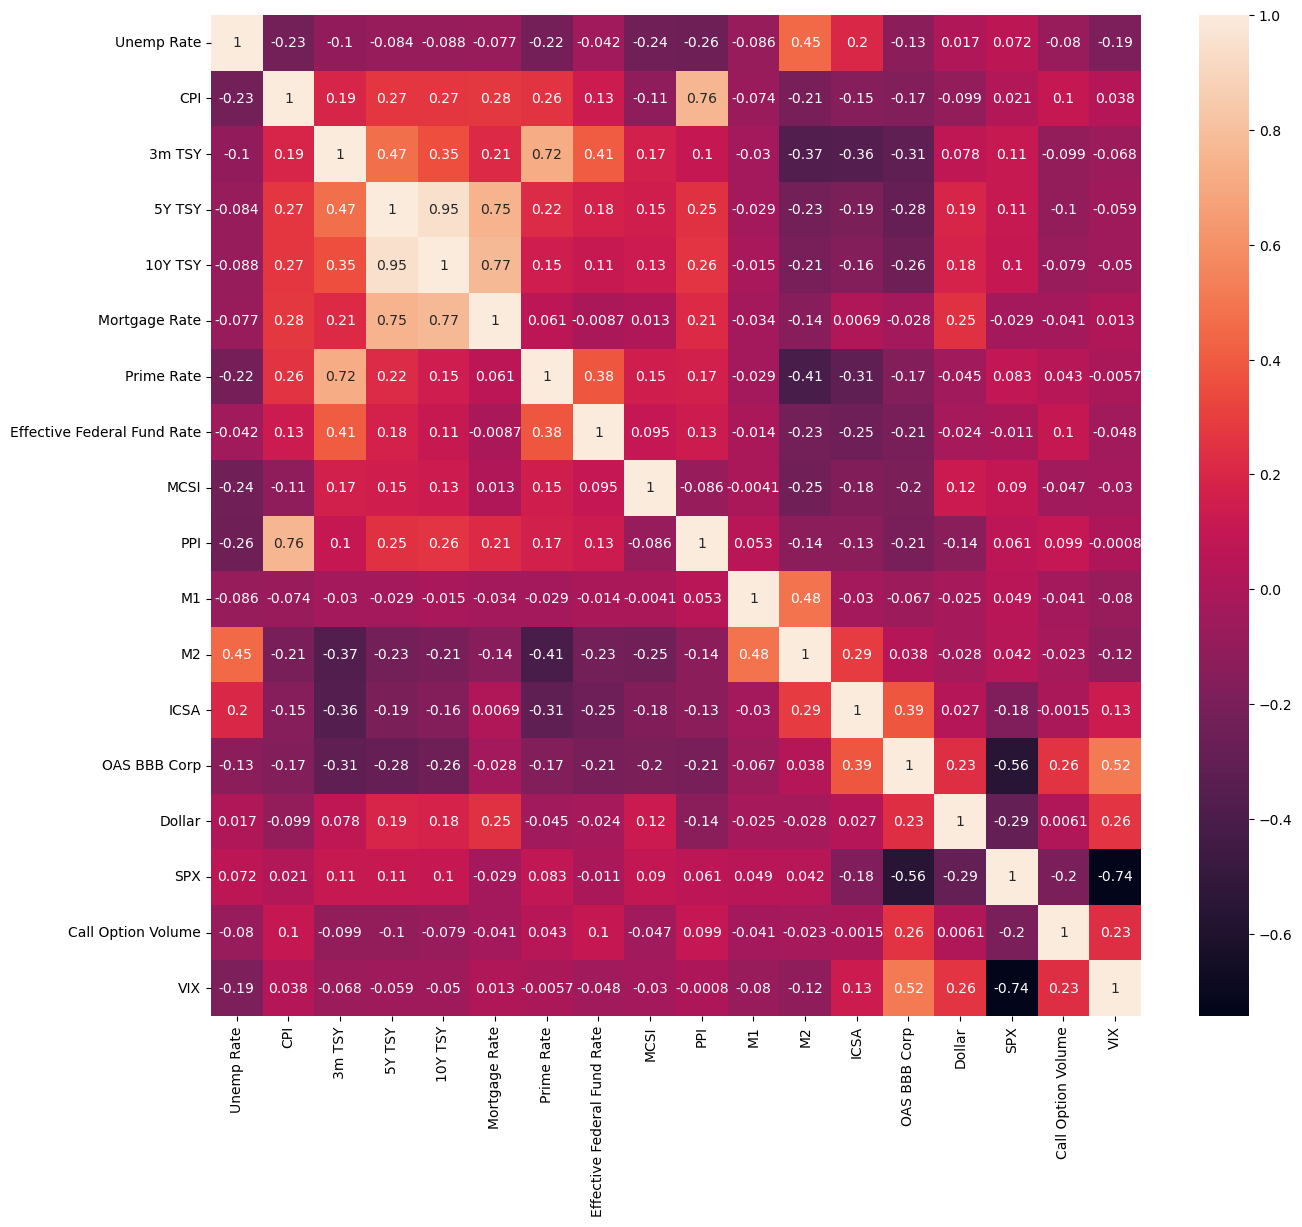

In [21]:
plt.figure(figsize=(15, 13))
sns.heatmap(combined_final_data.corr(),annot=True)

In [22]:
correlation_matrix = combined_final_data.corr()

# Get the variable names with correlation greater than 0.7
variables = correlation_matrix.columns
strong_correlation_variables = []

for var1 in variables:
    for var2 in variables:
        if var1 != var2 and correlation_matrix.loc[var1, var2] >= 0.7:
            strong_correlation_variables.append((var1, var2))

# Print the variable pairs with correlation greater than 0.7
for pair in strong_correlation_variables:
    print(f"{pair[0]} and {pair[1]} have a correlation greater than 0.7.")

CPI and PPI have a correlation greater than 0.7.
3m TSY and Prime Rate have a correlation greater than 0.7.
5Y TSY and 10Y TSY have a correlation greater than 0.7.
5Y TSY and Mortgage Rate have a correlation greater than 0.7.
10Y TSY and 5Y TSY have a correlation greater than 0.7.
10Y TSY and Mortgage Rate have a correlation greater than 0.7.
Mortgage Rate and 5Y TSY have a correlation greater than 0.7.
Mortgage Rate and 10Y TSY have a correlation greater than 0.7.
Prime Rate and 3m TSY have a correlation greater than 0.7.
PPI and CPI have a correlation greater than 0.7.


### T-1 Heatmap vs Current VIX

In [23]:
# Zero for lag and 1 for lead variables
# Numshifts is the number of lead/lags
# Data1 contains all variables and the target varible is the last column of data1

def leadlagheatmap(data1, numshifts, zero_or_one):
    plt.figure(figsize=(15, 13))
    if zero_or_one == 0:
        target = data1.iloc[:,-1].shift(numshifts)
        vars = data1.iloc[0:-numshifts,0:-1]
        comblagged = pd.concat([vars, target], axis=1)
        comblagged.dropna
    else:
        target = data1.iloc[0:-numshifts,-1]
        vars = data1.iloc[:,0:-1].shift(numshifts)
        comblagged = pd.concat([vars, target], axis=1)
        comblagged.dropna
    return sns.heatmap(comblagged.corr(),annot=True)

# leadlagheatmap(combined_final_data,1,0)

### Pair Plots

In [24]:
# plt.figure()
# sns.pairplot(combined_final_data)

### Histogram Plots

In [25]:
# for i in range (len(cols)+1):
#     plt.figure()
#     sns.histplot(combined_final_data.iloc[:,i])
#     plt.title(combined_final_data.columns[i])
#     plt.show()

### Scatter Plots 

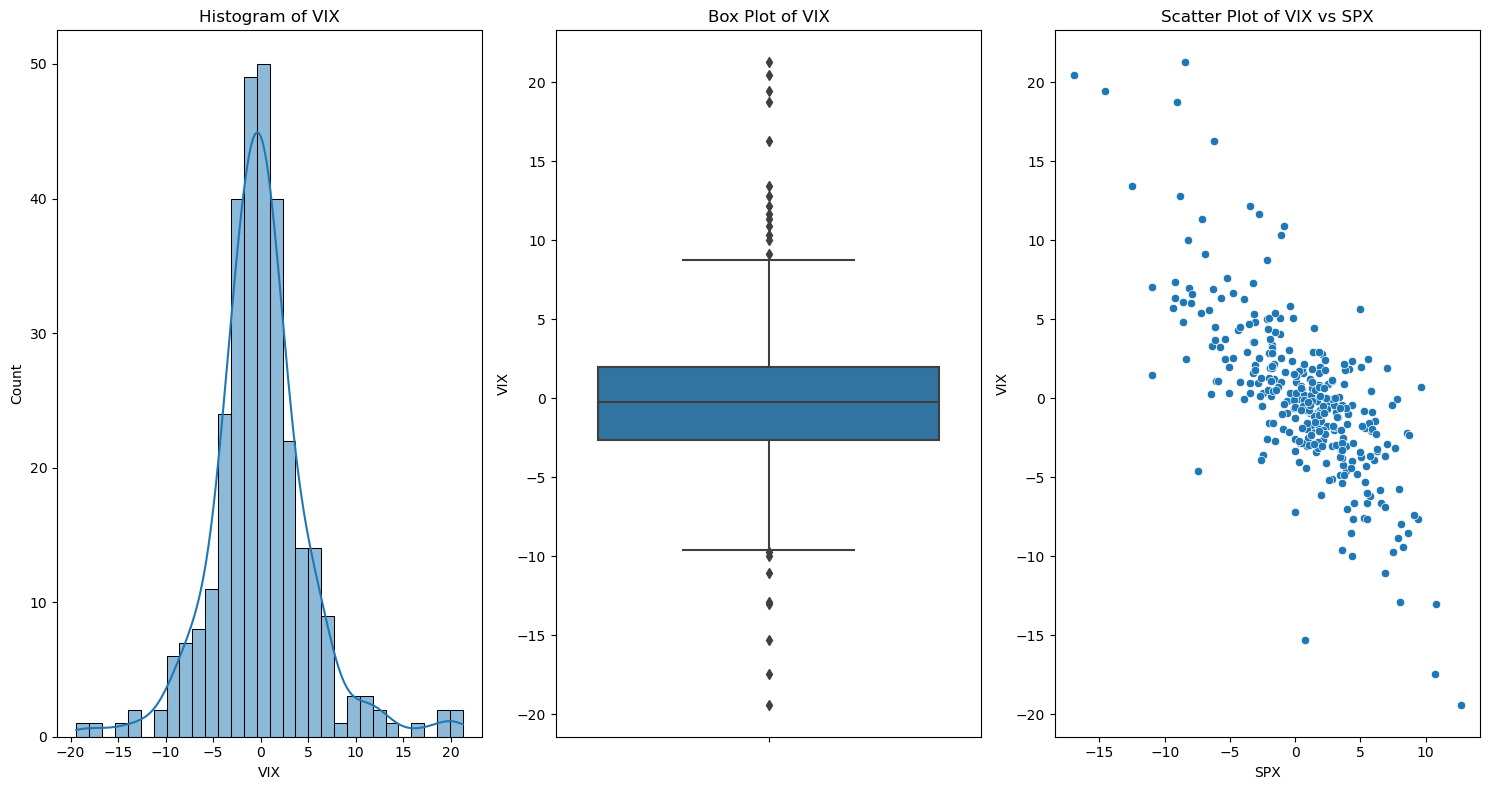

In [912]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have already imported the required libraries and loaded the dataframe 'combined_final_data'

# Set up the grid plot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))  # Adjust figsize as needed

# Plot the histogram
sns.histplot(data=combined_final_data, x='VIX', bins=30, kde=True, ax=axs[0])
axs[0].set_title('Histogram of VIX')

# Plot the box plot
sns.boxplot(data=combined_final_data, y='VIX', ax=axs[1])
axs[1].set_title('Box Plot of VIX')

# Plot the scatter plot
sns.scatterplot(data=combined_final_data, x='SPX', y='VIX', ax=axs[2])
axs[2].set_title('Scatter Plot of VIX vs SPX')

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


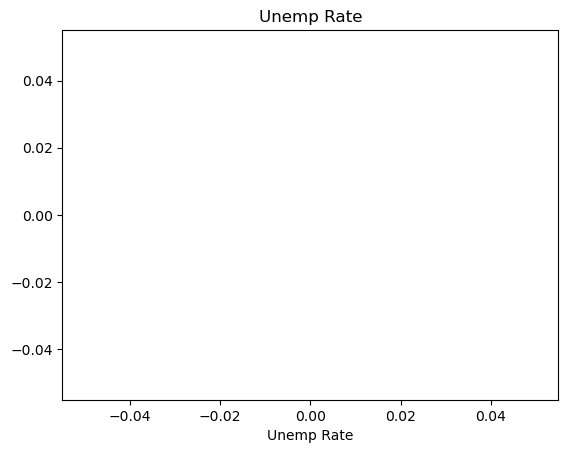

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


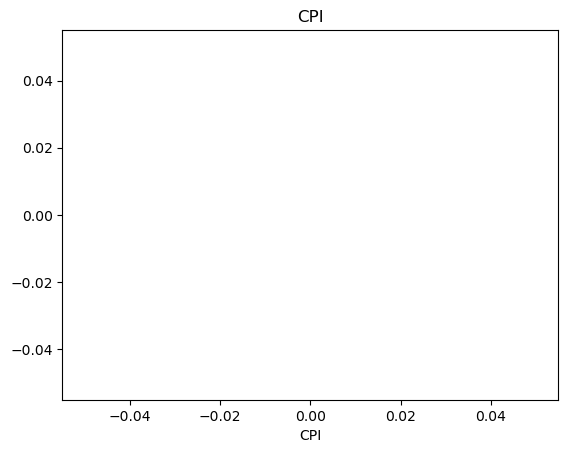

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


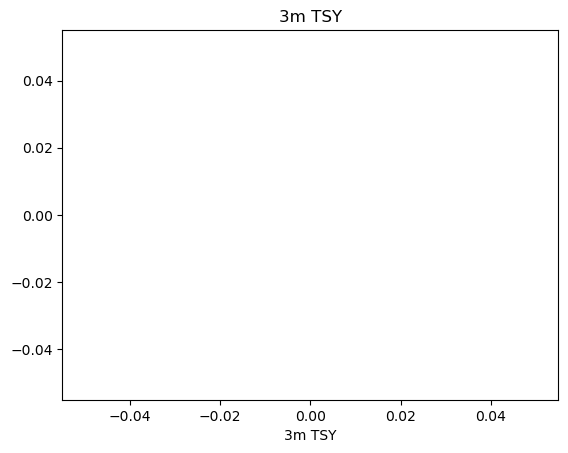

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


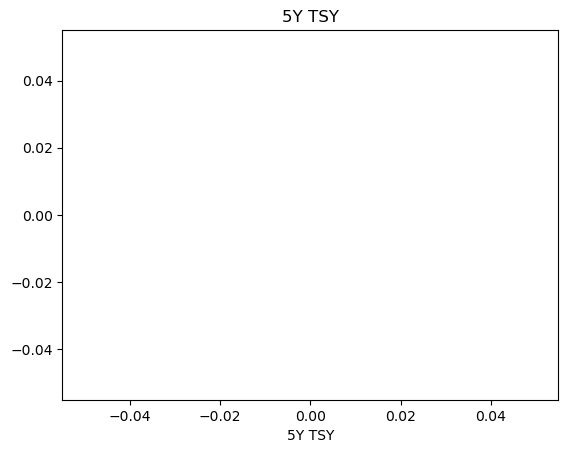

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


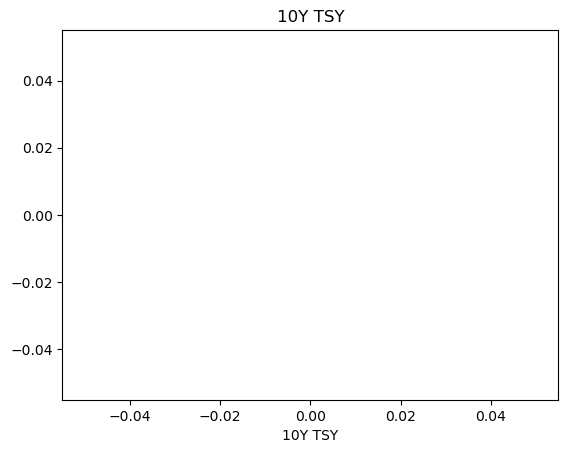

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


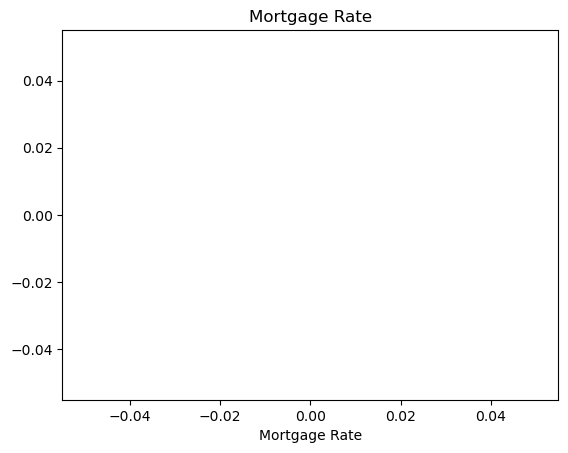

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


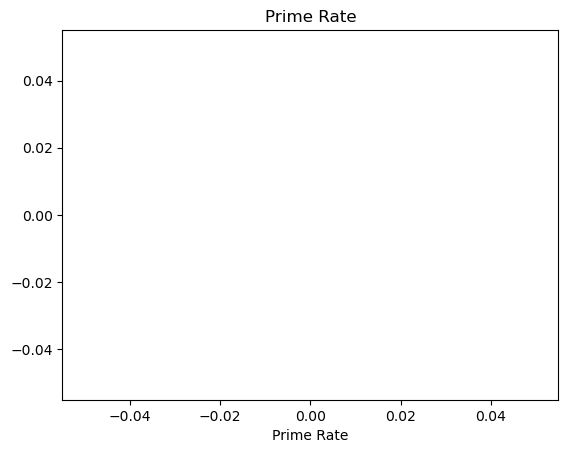

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


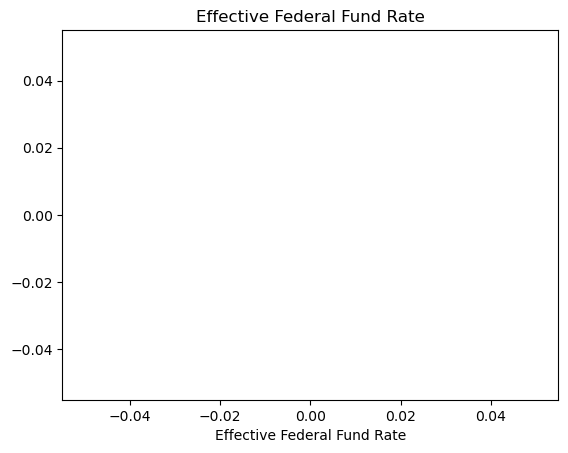

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


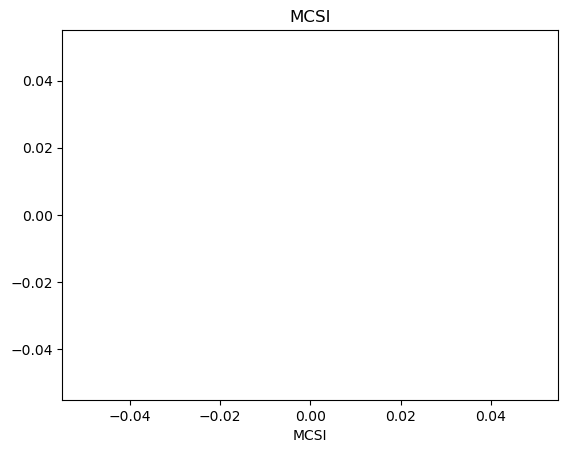

In [26]:
for i in range (len(cols)+1):
    plt.figure()
    sns.scatterplot(combined_final_data.iloc[:,i])
    plt.title(combined_final_data.columns[i])
    plt.show()

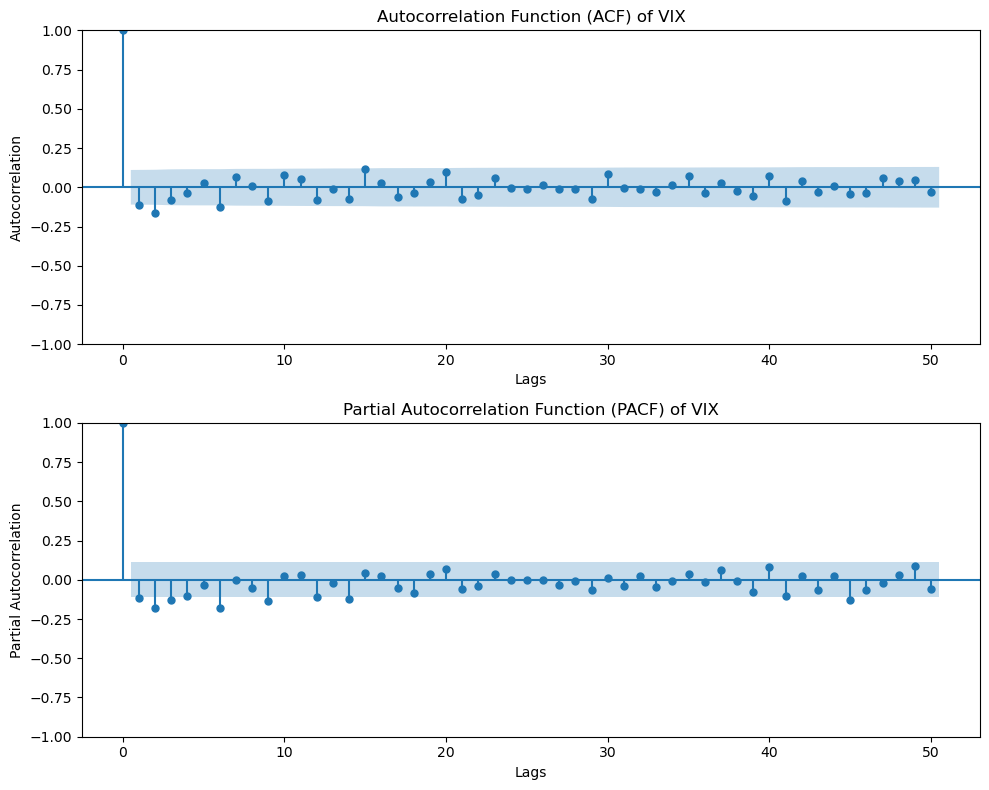

In [920]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming you have already imported the required libraries and loaded the dataframe 'combined_final_data'

# Create a rectangular grid plot
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the ACF
plot_acf(combined_final_data['VIX'], lags=50, alpha=0.05, ax=axs[0])
axs[0].set_title('Autocorrelation Function (ACF) of VIX')
axs[0].set_xlabel('Lags')
axs[0].set_ylabel('Autocorrelation')

# Plot the PACF
plot_pacf(combined_final_data['VIX'], lags=50, alpha=0.05, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function (PACF) of VIX')
axs[1].set_xlabel('Lags')
axs[1].set_ylabel('Partial Autocorrelation')

# Adjust layout to prevent overlapping of titles
plt.tight_layout()

# Show the plot
plt.show()


### Box Plots¶

In [27]:
# for i in range (len(cols)+1):
#     plt.figure()
#     sns.boxplot(combined_final_data.iloc[:,i])
#     plt.title(combined_final_data.columns[i])
#     plt.show()

## Principal Component Analysis

### Standard Scaling

In [28]:
# Function for train test split data
def traintestsplit(dep_data,indep_data, shufflestate, testsize):
    x_train, x_test, y_train, y_test = train_test_split(dep_data, indep_data, shuffle=shufflestate, test_size=testsize)
    return x_train, x_test, y_train, y_test

In [29]:
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = traintestsplit(combined_final_data.iloc[:,0:16],combined_final_data.iloc[:,-1],False,0.2)

from sklearn.preprocessing import RobustScaler, StandardScaler
ss = StandardScaler()
ss.fit(train_x)
scaled_t_train = ss.transform(train_x)
scaled_t_test = ss.transform(test_x)

In [30]:
pca = PCA(0.95)
model = pca.fit(scaled_t_train)
pca_train = model.transform(scaled_t_train)
pca_test = model.transform(scaled_t_test)
n_comp = model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_comp)]
initial_feature_names = ['Unemp Rate', 'CPI', '3m TSY', '5Y TSY', '10Y TSY', 'Mortgage Rate',
       'Prime Rate', 'Effective Federal Fund Rate', 'MCSI', 'PPI','M1','M2', 'ICSA', 'OAS BBB Corp', 'SPX', 'Call Option Volume']
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_comp)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_comp)}
df = pd.DataFrame(sorted(dic.items()))

## Time Series Analysis

###  Stationarity Check

In [31]:
# Function for Combination of ADF and KPSS Tests
def comb_stat_test(varname, vardata):
    # ADF Test
    adfcnt = 0
    adf = adfuller(vardata)
    if adf[1] < 0.05:
        adfcnt = 1
    # KPSS Test
    kpcnt = 0
    kpstest = kpss(vardata)
    if kpstest[1] > 0.05:
        kpcnt = 1
    # Combination check
    if adfcnt == 1 and kpcnt == 0:
        print('is difference stationary.')
    elif adfcnt == 0 and kpcnt == 1:
        print('is trend stationary.')
    elif adfcnt == 0 and kpcnt == 0:
        print('is not stationary.')
    else:
        print('is stationary.')

In [32]:
for i in range(len(cols)+1):
    print('\n\n', combined_final_data.columns[i], ':')
    # ADF Test
    adfcnt = 0
    adf = adfuller(combined_final_data.iloc[:,i])
    if adf[1] < 0.05:
        adfcnt = 1
    # KPSS Test
    kpcnt = 0
    kpstest = kpss(combined_final_data.iloc[:,i])
    if kpstest[1] > 0.05:
        kpcnt = 1

    # Combination of ADF and KPSS Tests
    if adfcnt == 1 and kpcnt == 0:
        print('is difference stationary by comparison of ADF and KPSS test')
    elif adfcnt == 0 and kpcnt == 1:
        print('is trend stationary by comparison of ADF and KPSS test')
    elif adfcnt == 0 and kpcnt == 0:
        print('is not stationary by ADF and KPSS test')
    else:
        print('is stationary by ADF and KPSS test')

    # PP Test
    ppcnt = 0
    pptest = PhillipsPerron(combined_final_data.iloc[:,i])
    if pptest.pvalue< 0.05:
        print('Is stationary by Phillips Perron test')
        ppcnt = 1
    else:
        print('Is NOT stationary by Phillips Perron test')



 Unemp Rate :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 CPI :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 3m TSY :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 5Y TSY :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 10Y TSY :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Mortgage Rate :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Prime Rate :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


 Effective Federal Fund Rate :
is trend stationary by comparison of ADF and KPSS test
Is stationary by Phillips Perron test


 MCSI :
is stationary by ADF and KPSS test
Is stationary by Phillips Perron test


C:\Users\sauvi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\sauvi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\sauvi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\sauvi\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is great

### Combining all three test to make a single test

In [33]:
# Internal Stationarity Test Function for single variable #### MAKE significance level an input parameter ####
# If at least 2 of the 3 tests ADF, KPSS, PP are passed, the data is stationary
def int_stat_test(varname, vardata):
    # ADF Test
    adfcnt = 0
    adf = adfuller(vardata)
    if adf[1] < 0.05:
        adfcnt = 1
    # KPSS Test
    kpcnt = 0
    kpstest = kpss(vardata)
    if kpstest[1] > 0.05:
        kpcnt = 1
    # PP Test
    ppcnt = 0
    pptest = PhillipsPerron(vardata)
    if pptest.pvalue< 0.05:
        ppcnt = 1
    if adfcnt + kpcnt + ppcnt >= 2:
        print(varname, 'is stationary')
    else:
        print(varname, 'is not stationary')

In [34]:
import warnings
warnings.filterwarnings("ignore")
for i in range(len(cols)+1):
    int_stat_test(combined_final_data.columns[i], combined_final_data.iloc[:,i])

Unemp Rate is stationary
CPI is stationary
3m TSY is stationary
5Y TSY is stationary
10Y TSY is stationary
Mortgage Rate is stationary
Prime Rate is stationary
Effective Federal Fund Rate is stationary
MCSI is stationary


### Seasonality Check

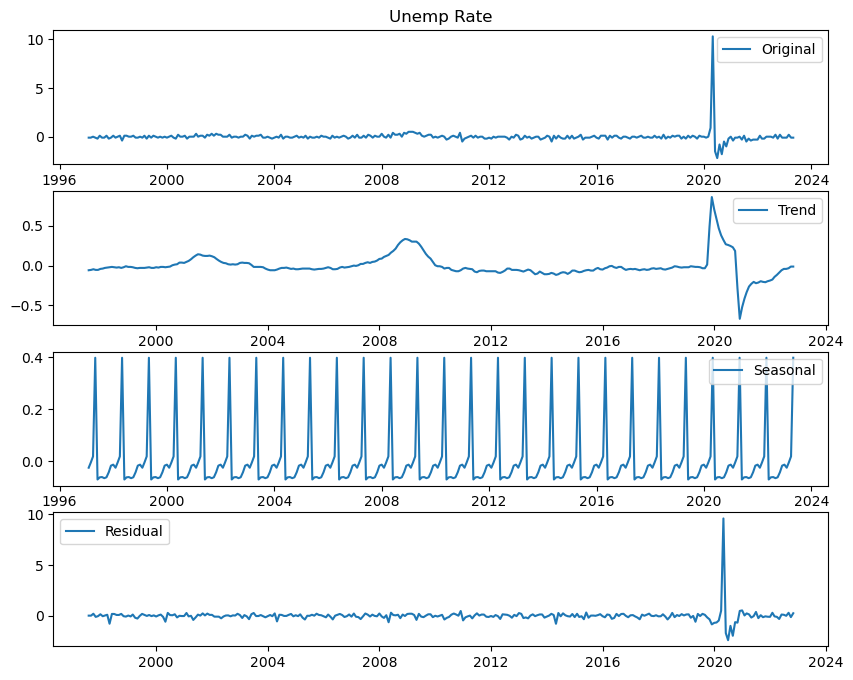

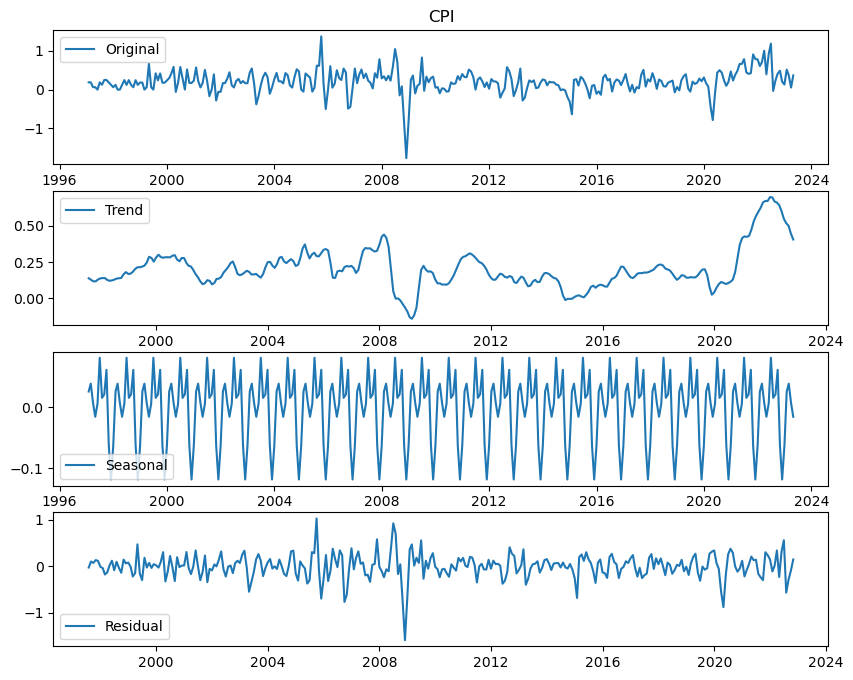

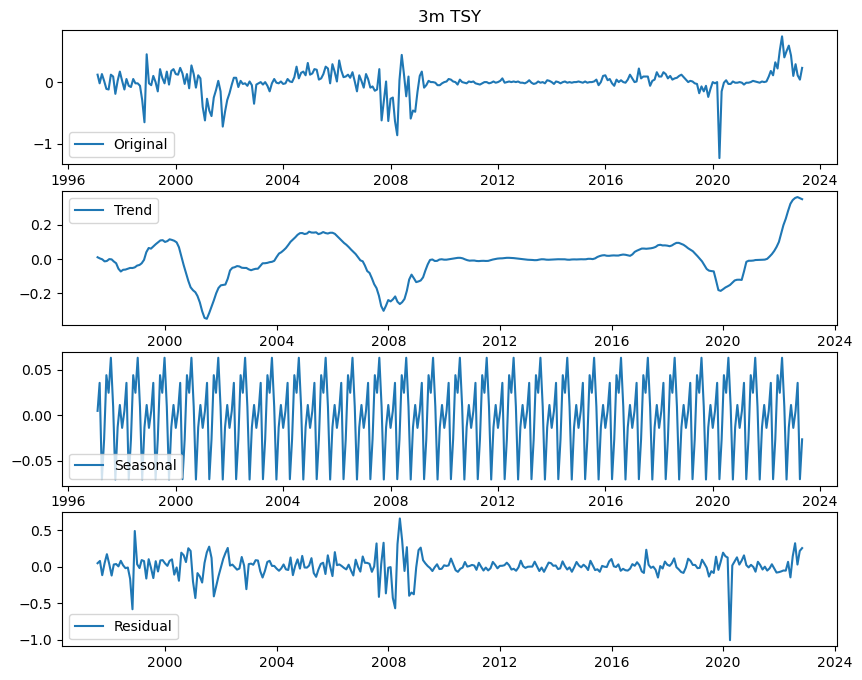

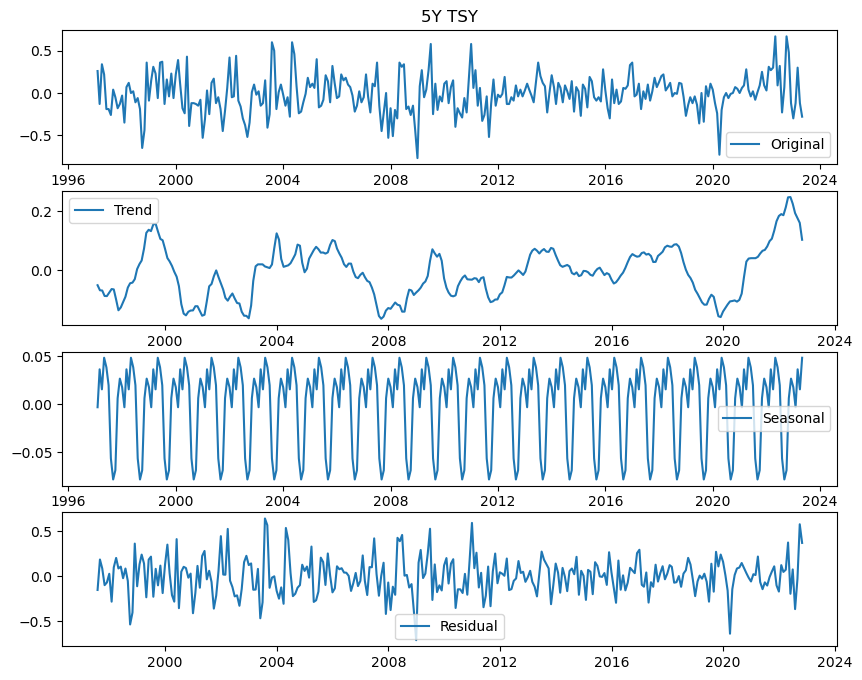

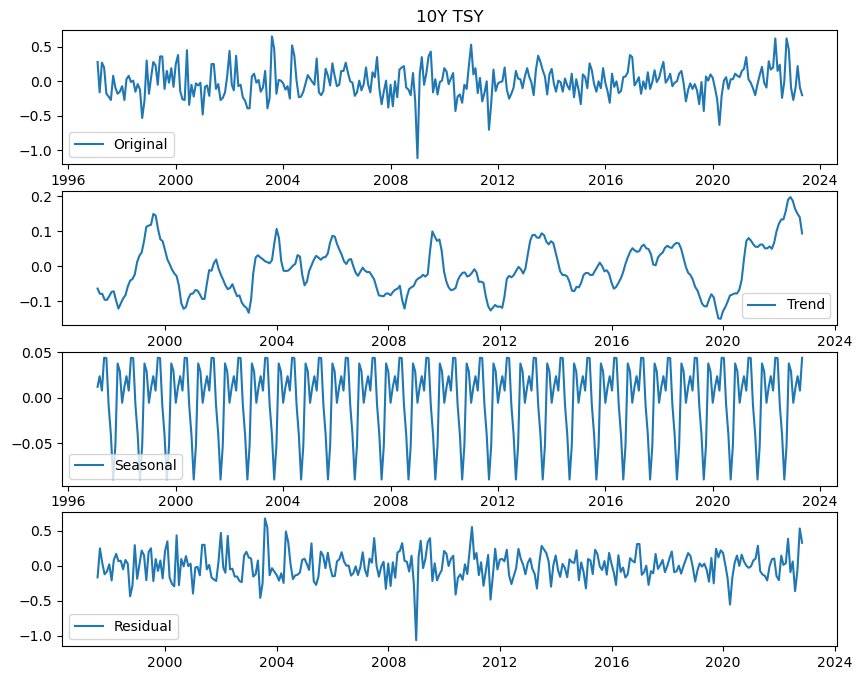

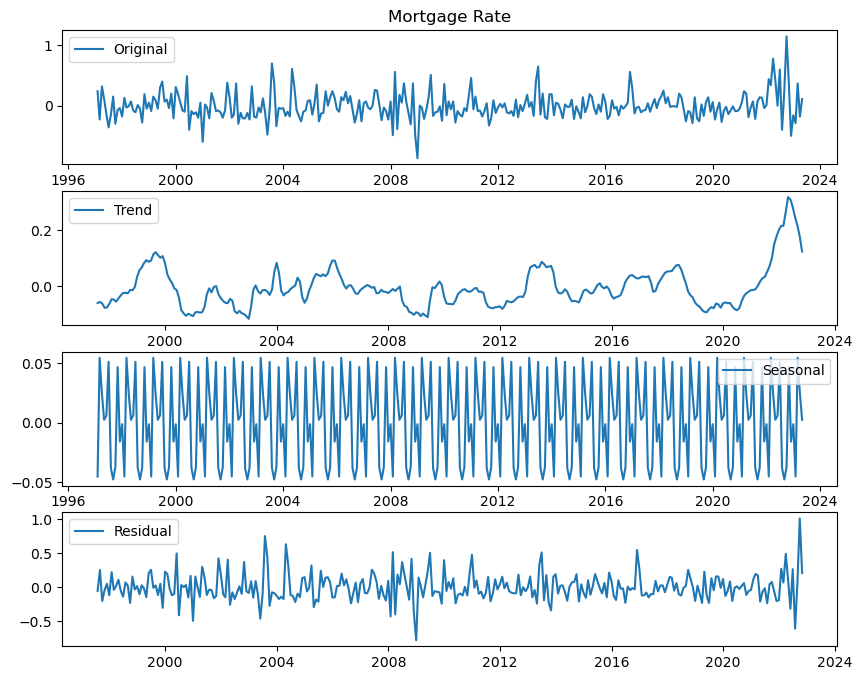

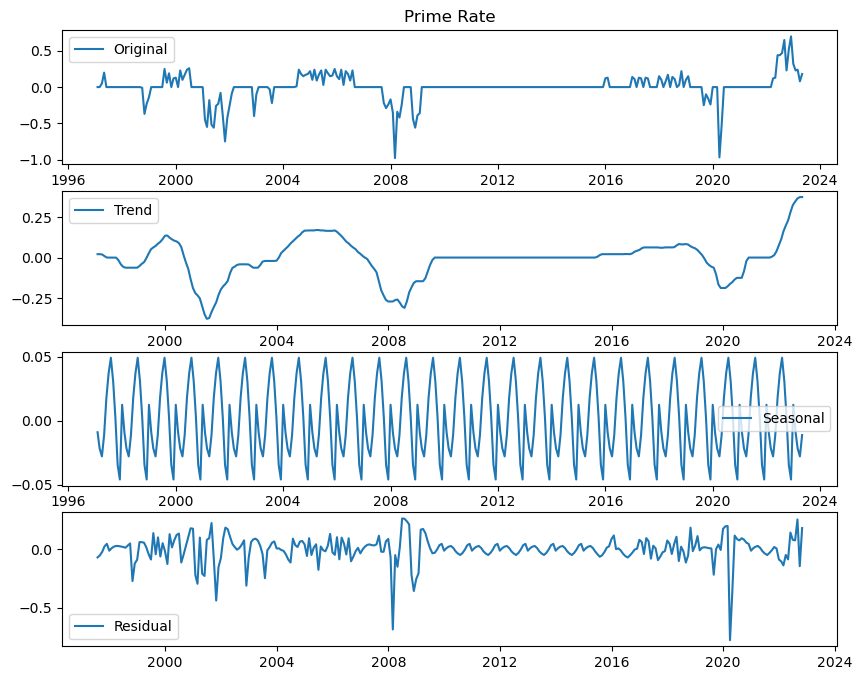

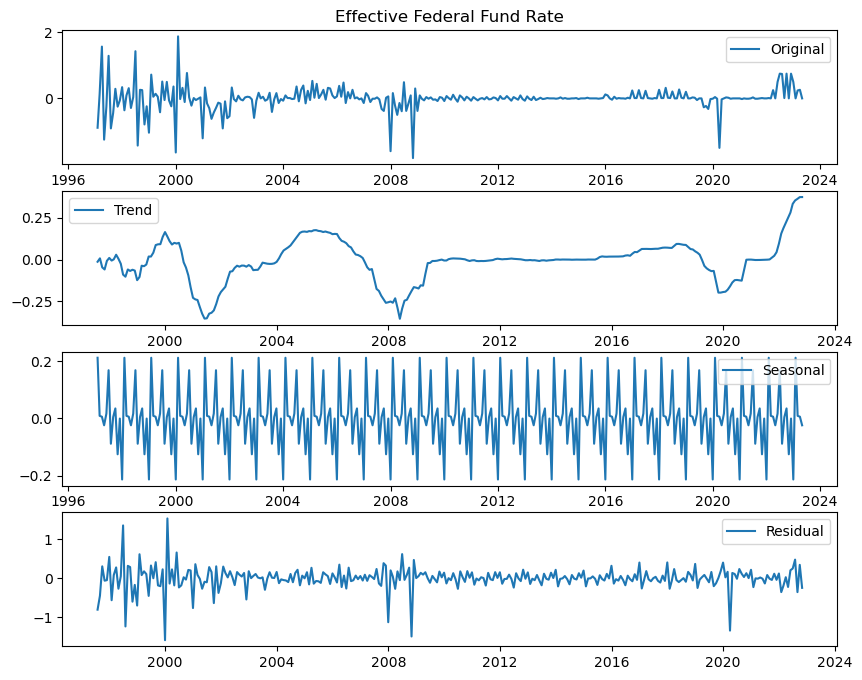

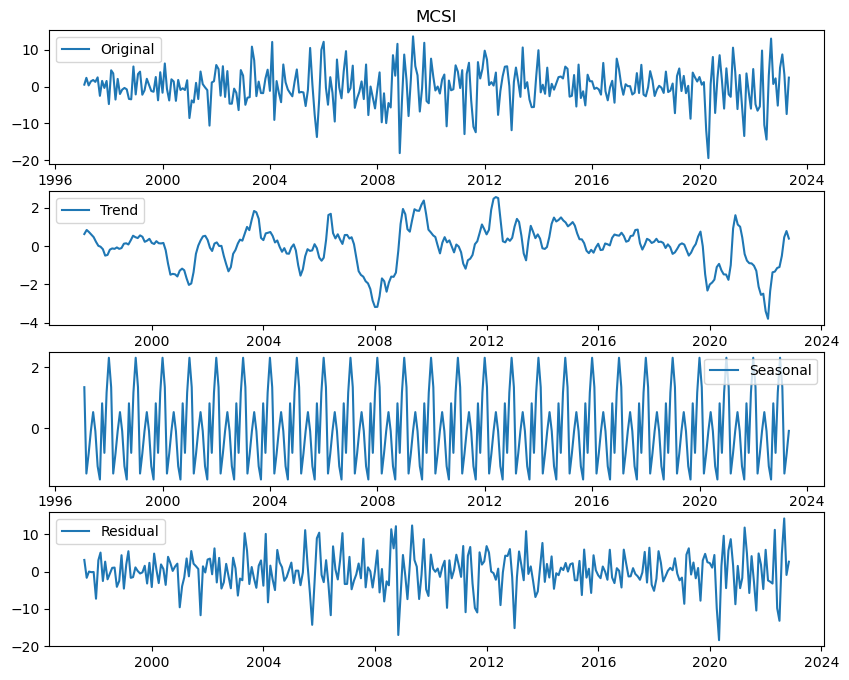

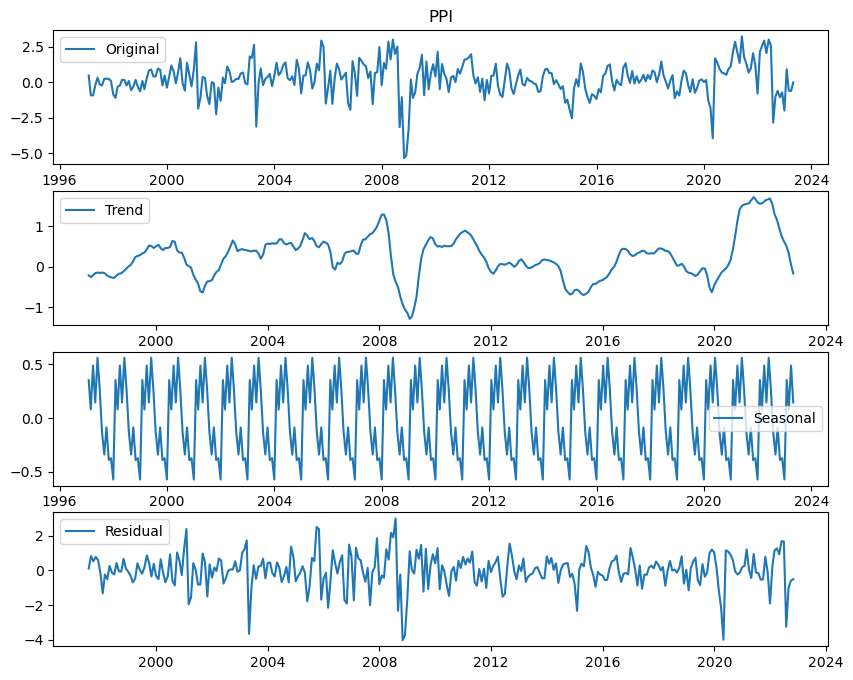

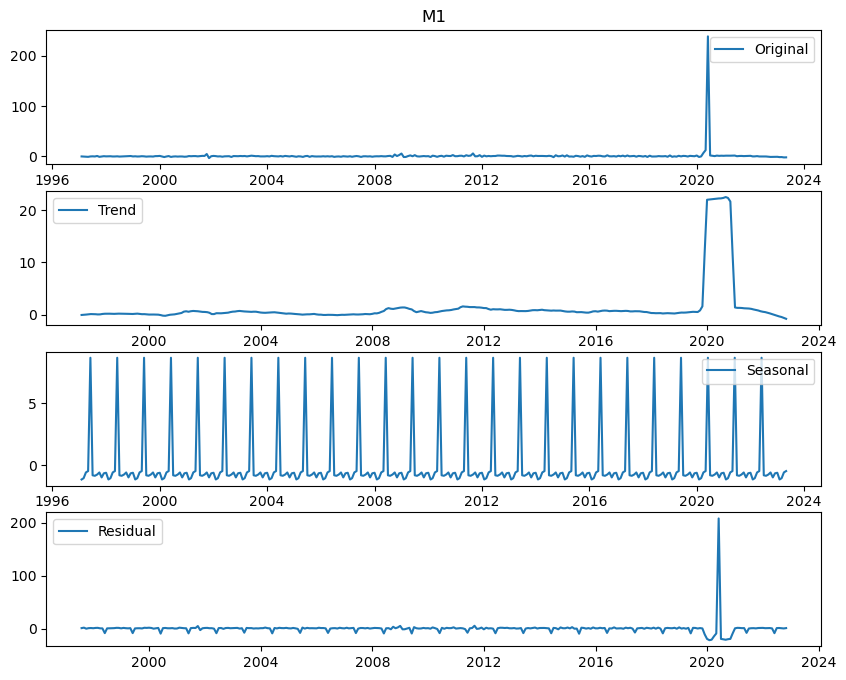

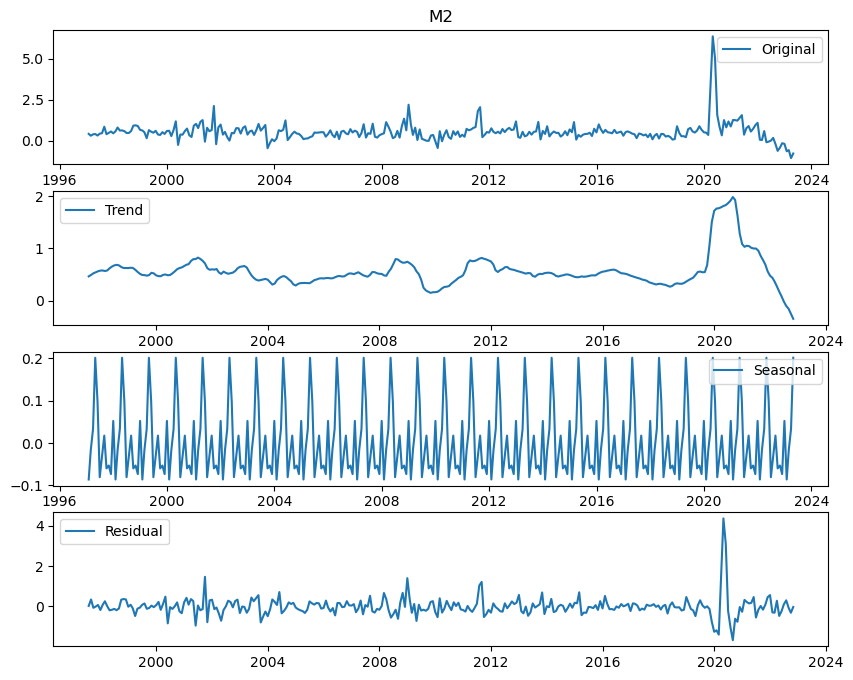

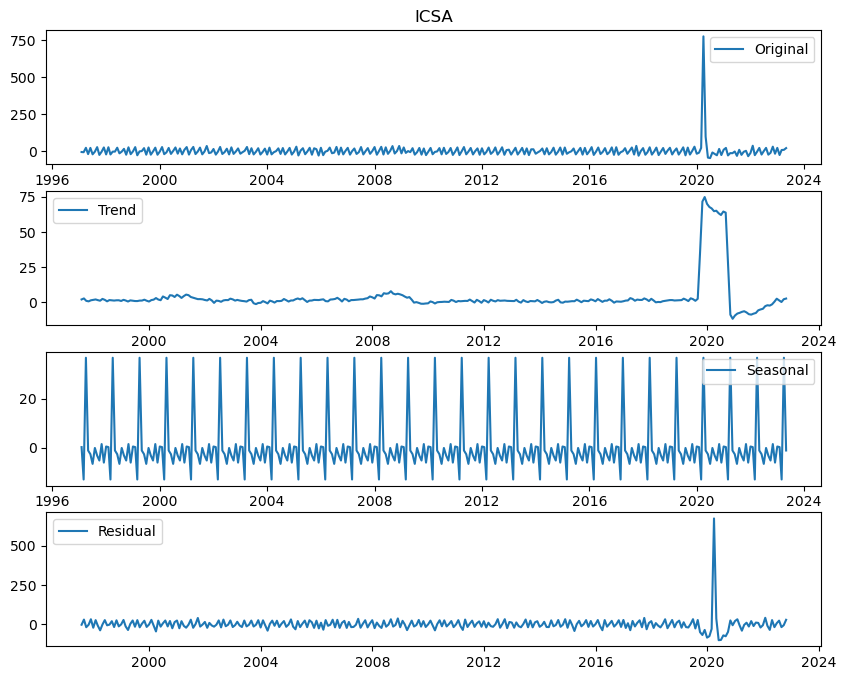

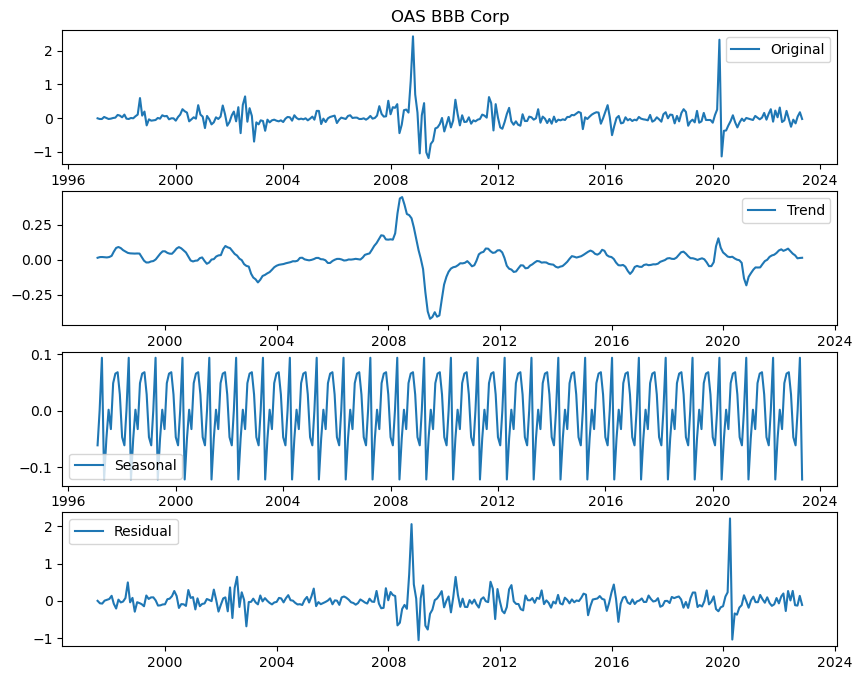

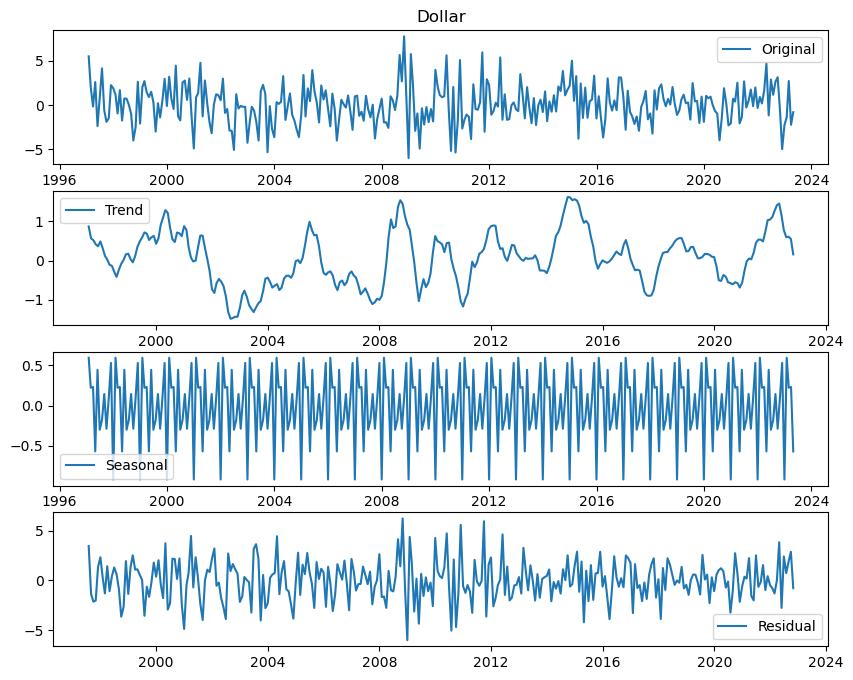

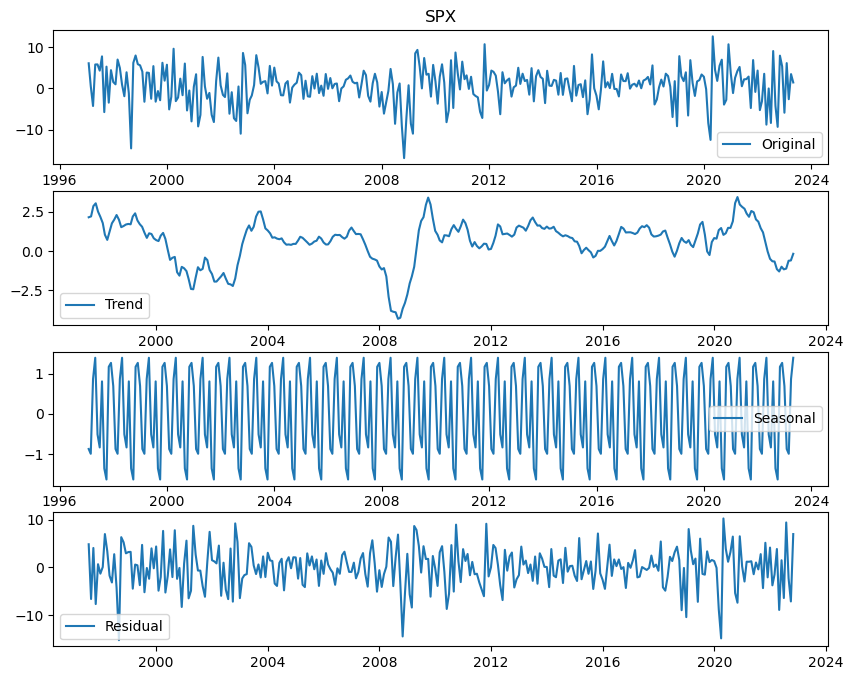

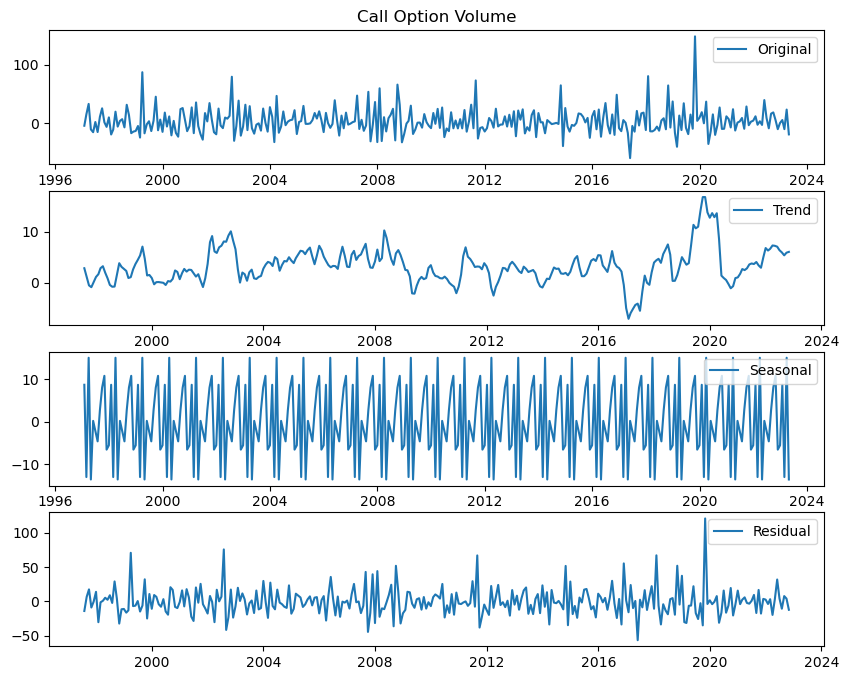

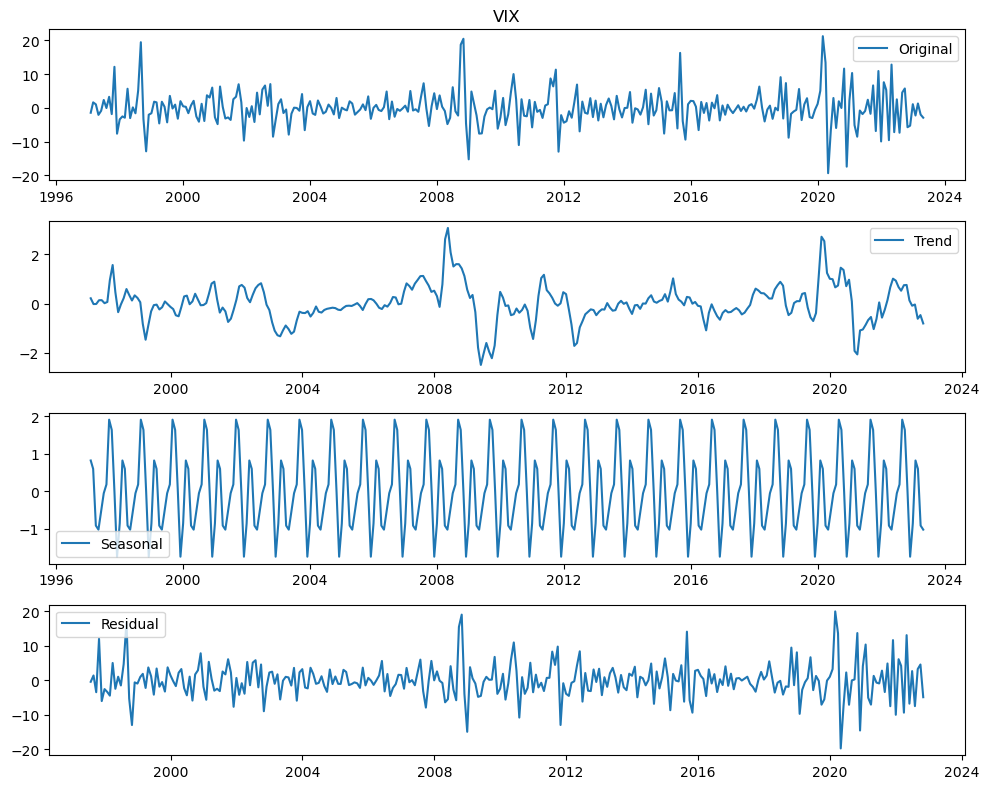

In [35]:
# Function to check for seasonality
def seasonalty_check(S,model_type):
    data_columns = S.columns
    for column in data_columns:
        seasonal_decomposition = sm.tsa.seasonal_decompose(S[column], model=model_type)

        # Plot the original time series, trend, seasonal, and residual components
        fig, ax = plt.subplots(4, 1, figsize=(10, 8))
        ax[0].plot(S.index, S[column], label='Original')
        ax[0].legend(loc='best')
        ax[1].plot(S.index, seasonal_decomposition.trend, label='Trend')
        ax[1].legend(loc='best')
        ax[2].plot(S.index, seasonal_decomposition.seasonal, label='Seasonal')
        ax[2].legend(loc='best')
        ax[3].plot(S.index, seasonal_decomposition.resid, label='Residual')
        ax[3].legend(loc='best')

        # Set the title of the plot as the column name
        ax[0].set_title(column)

    # Show the plots
    return plt.tight_layout()
    return plt.show()
options = ['additive','multiplicative']
seasonalty_check(combined_final_data,options[0])

### ACF and PACF plots

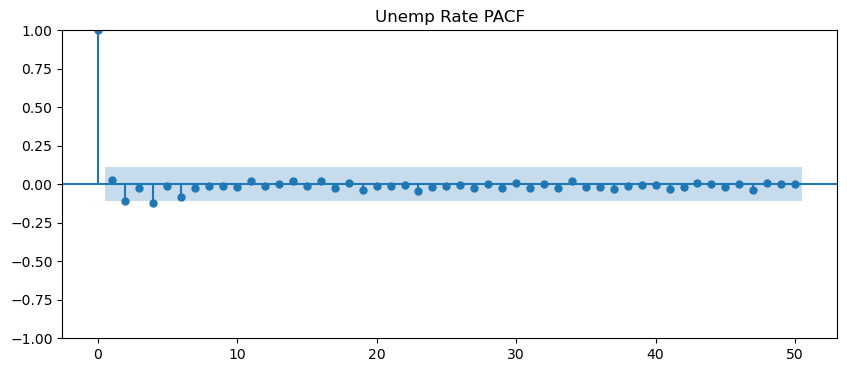

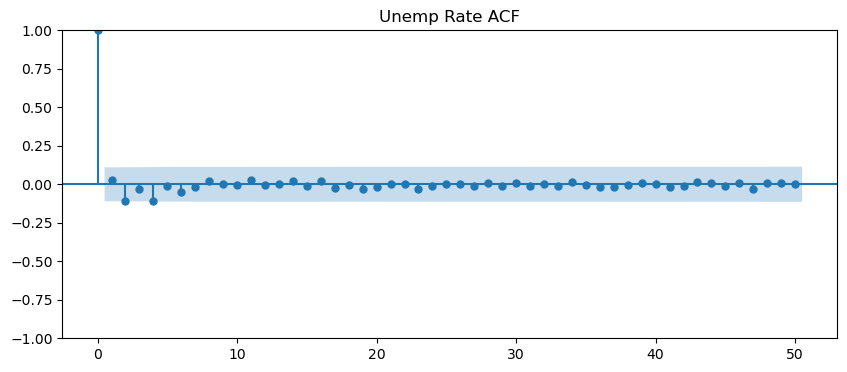

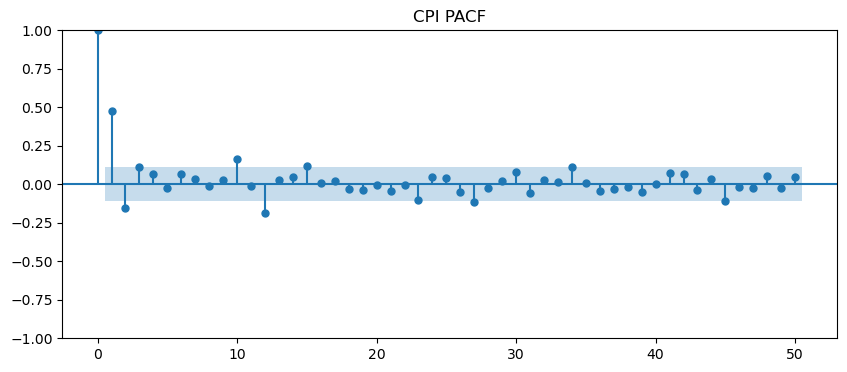

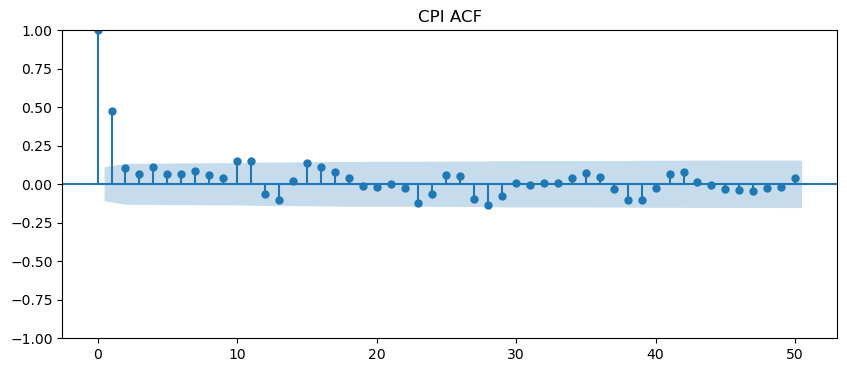

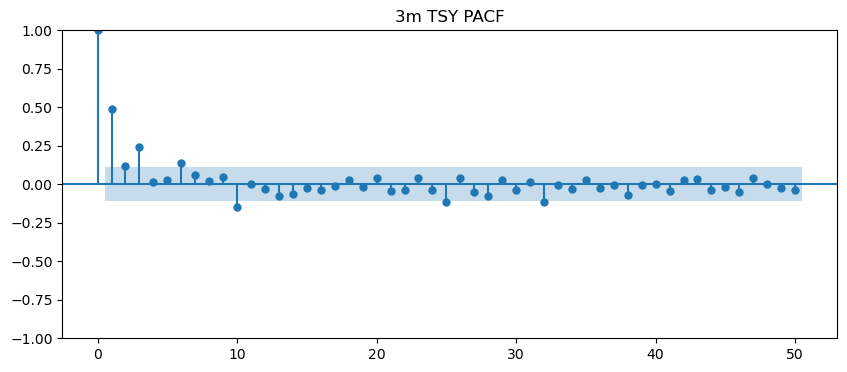

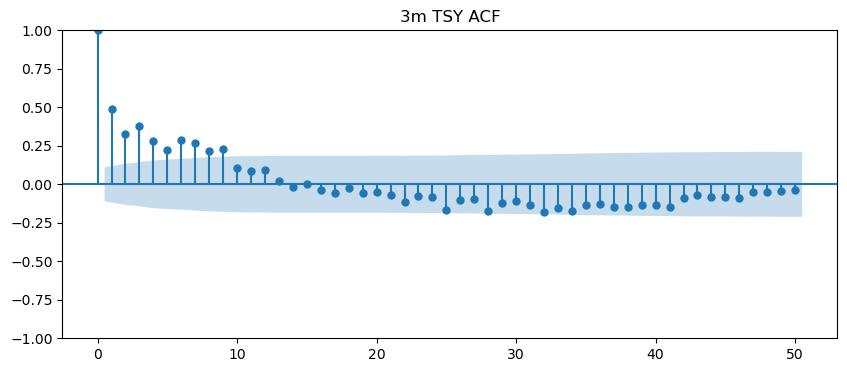

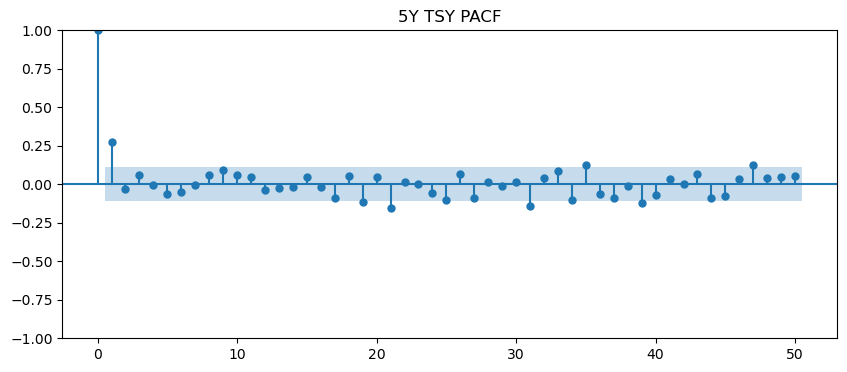

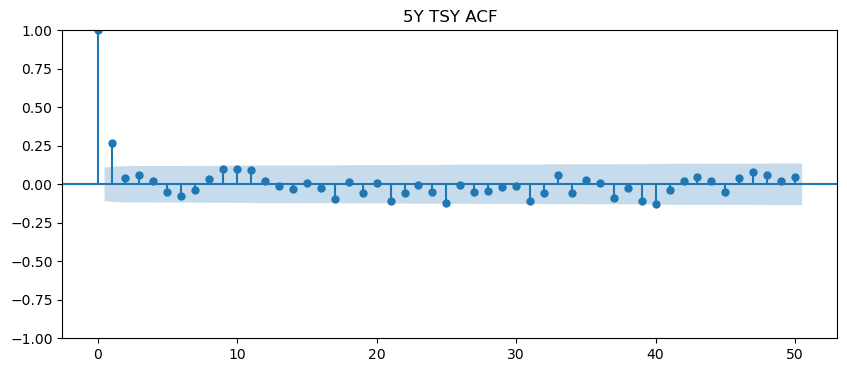

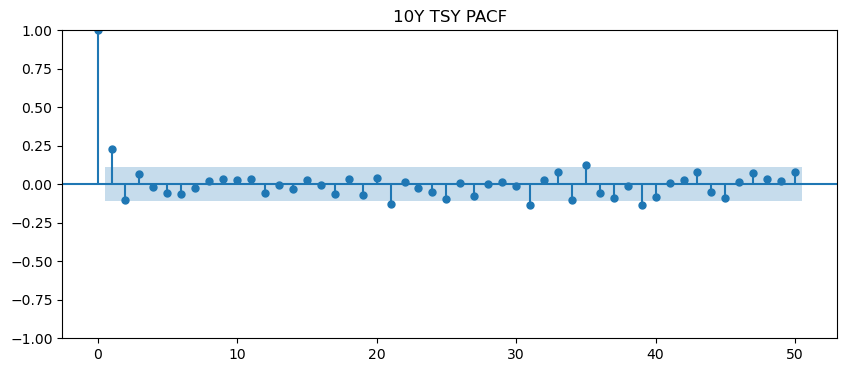

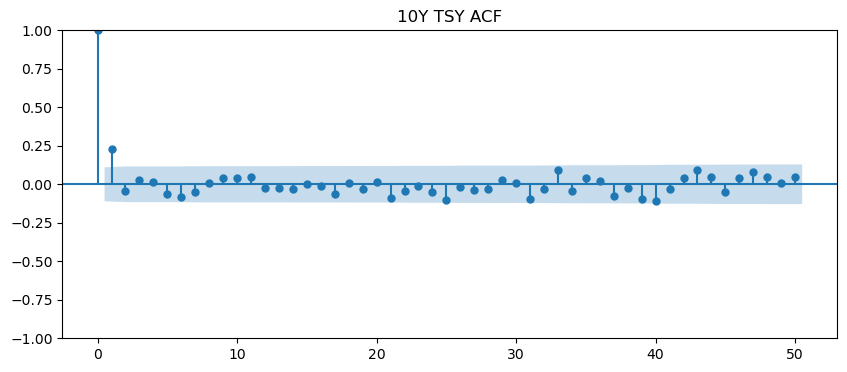

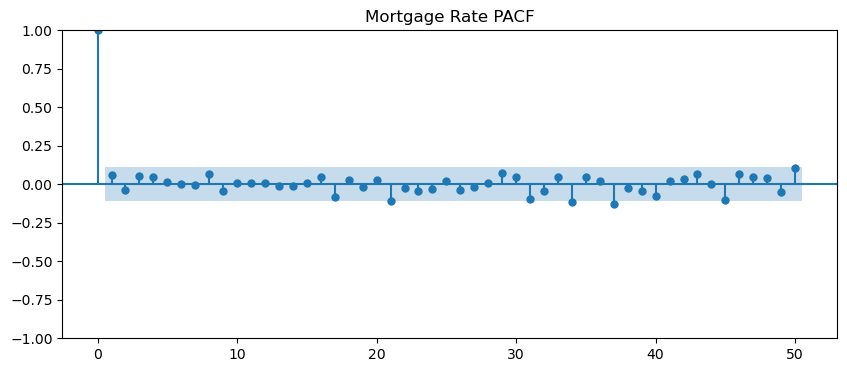

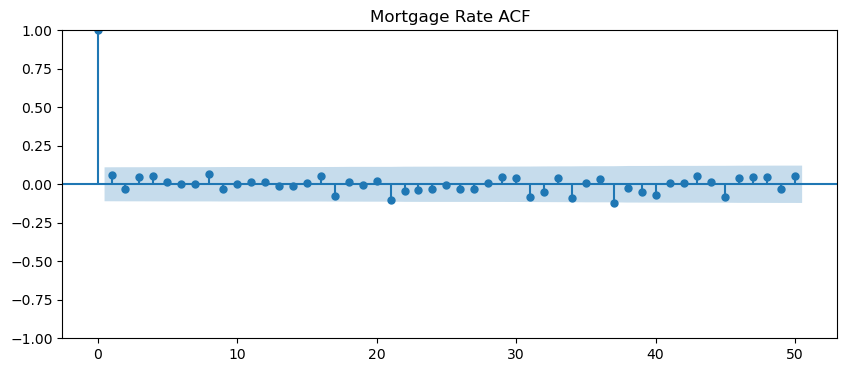

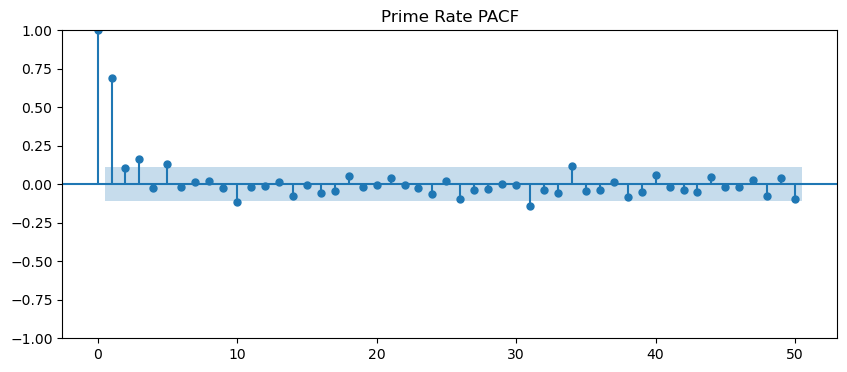

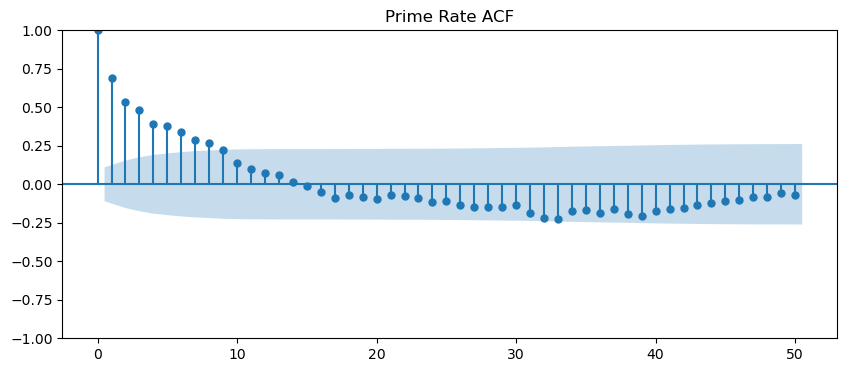

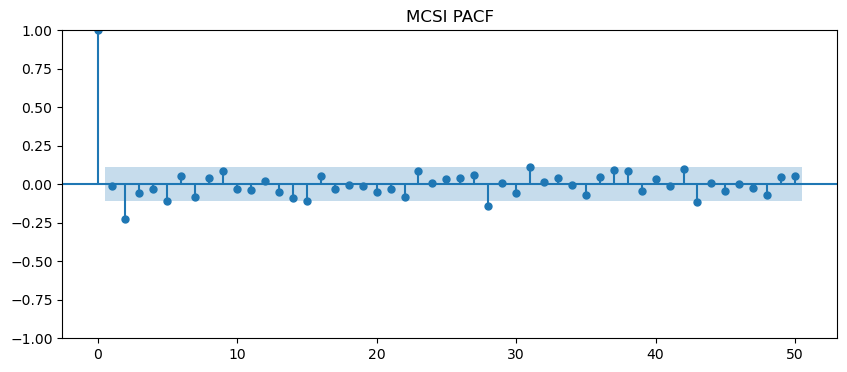

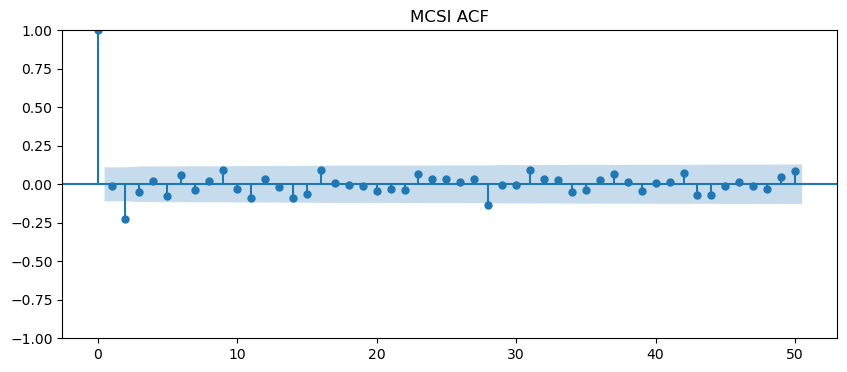

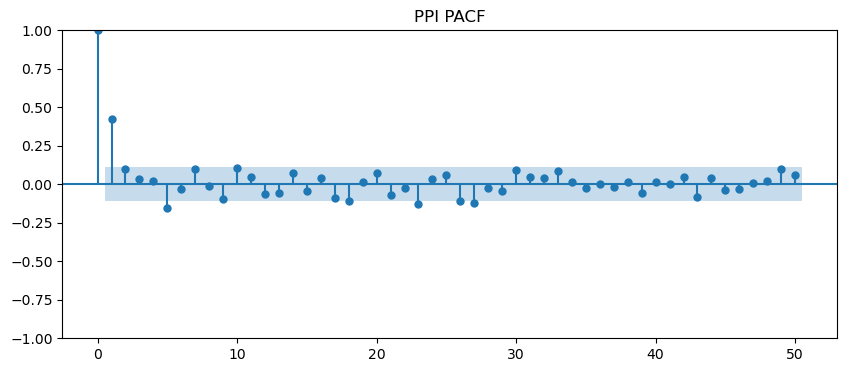

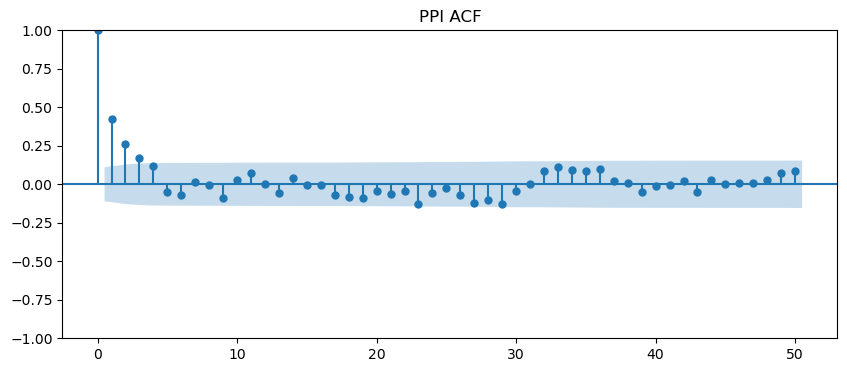

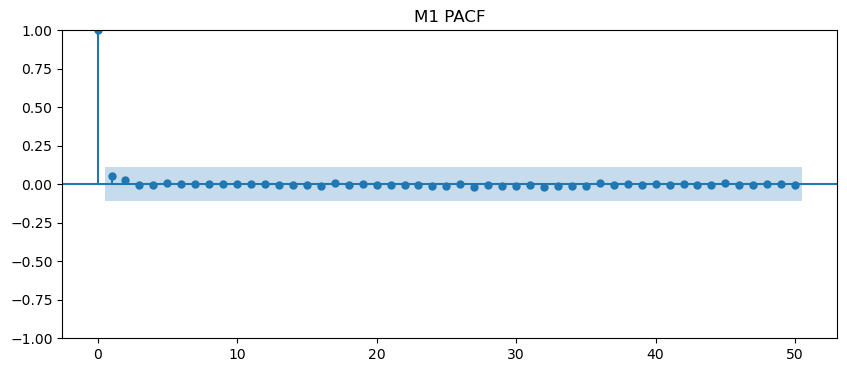

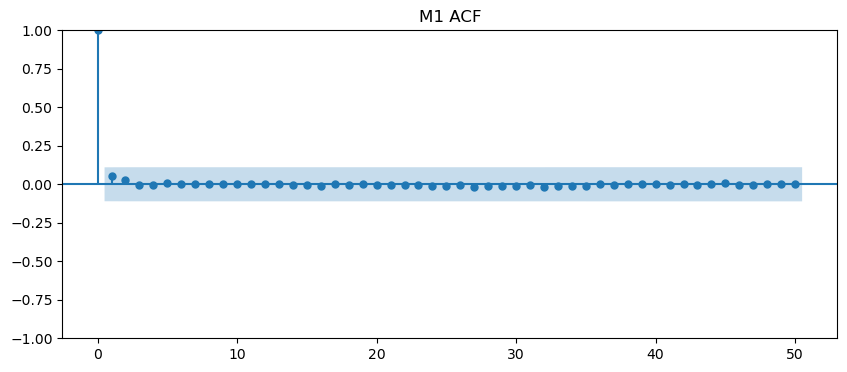

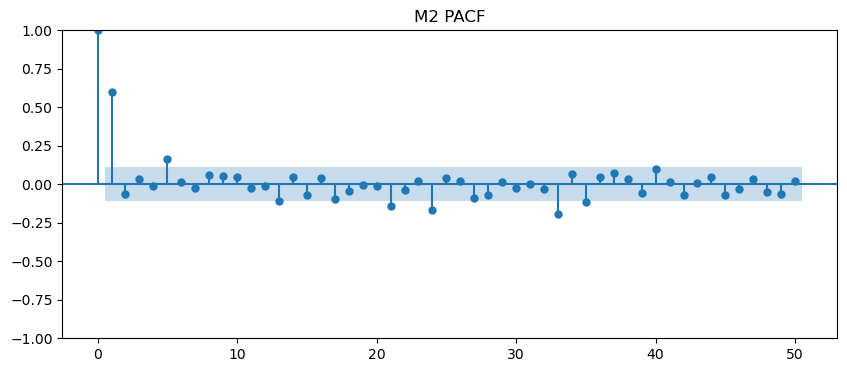

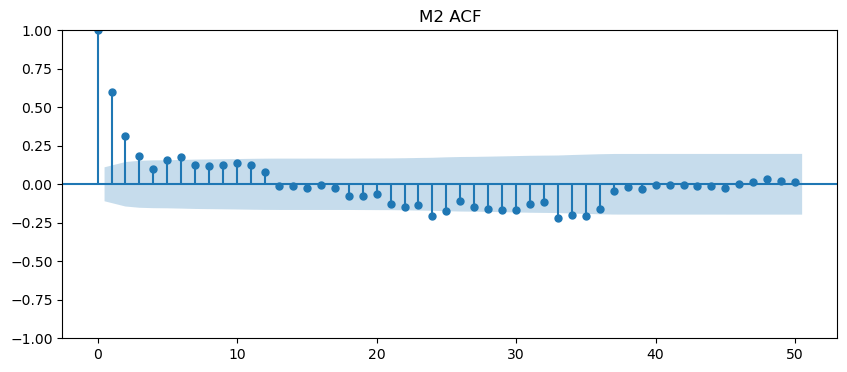

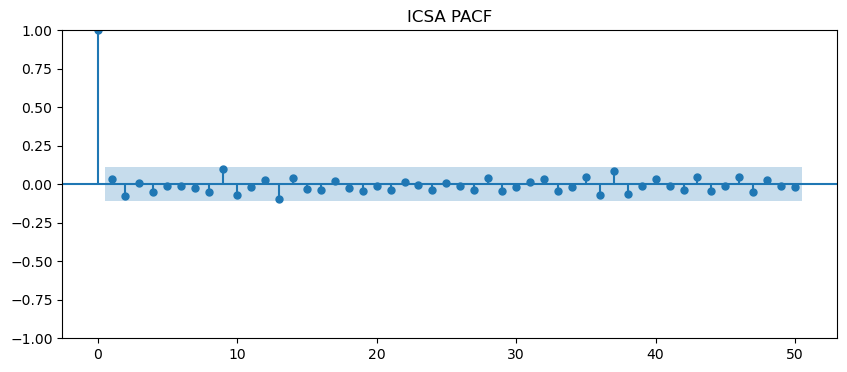

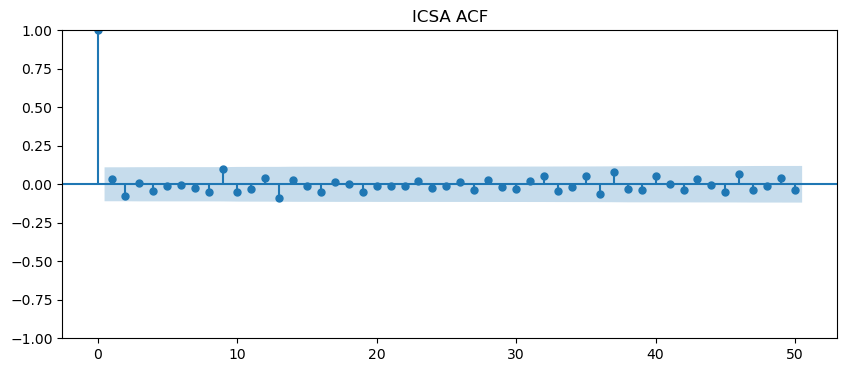

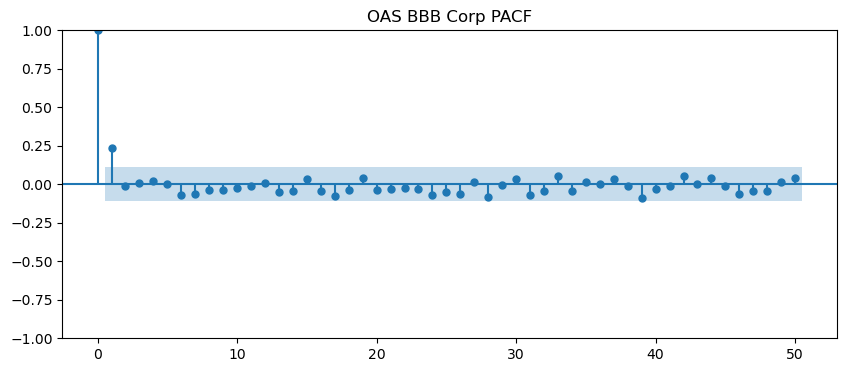

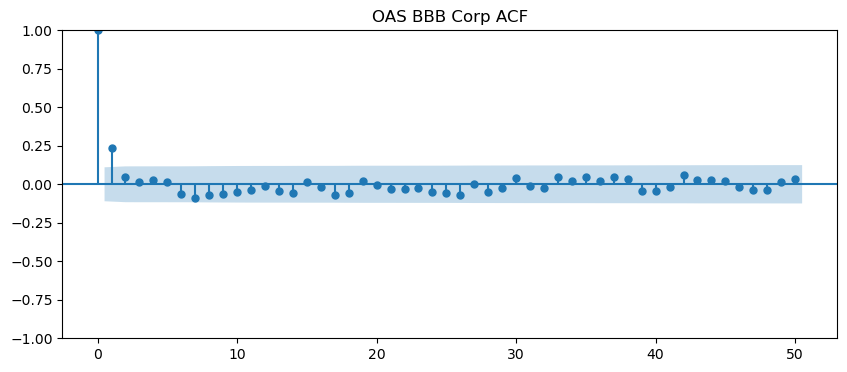

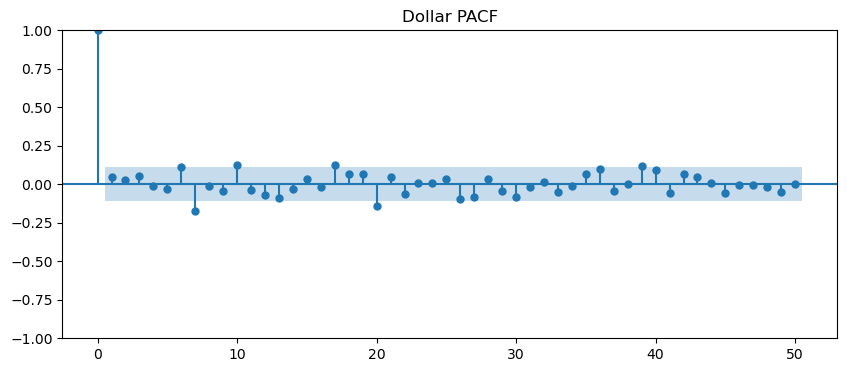

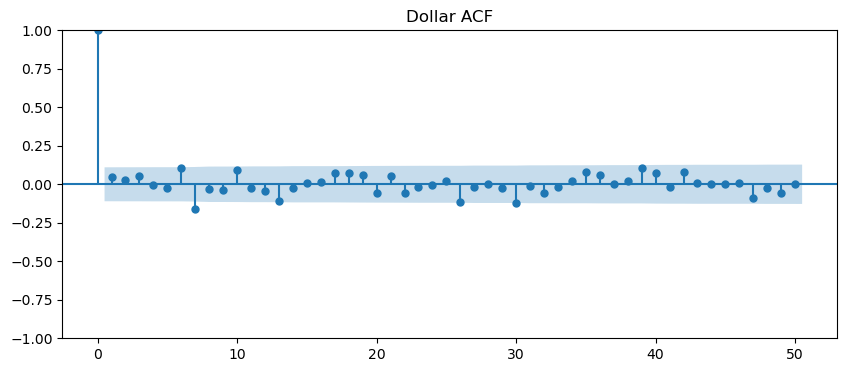

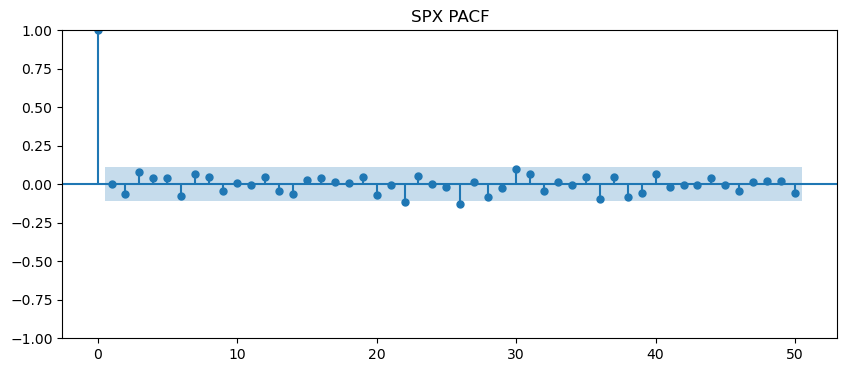

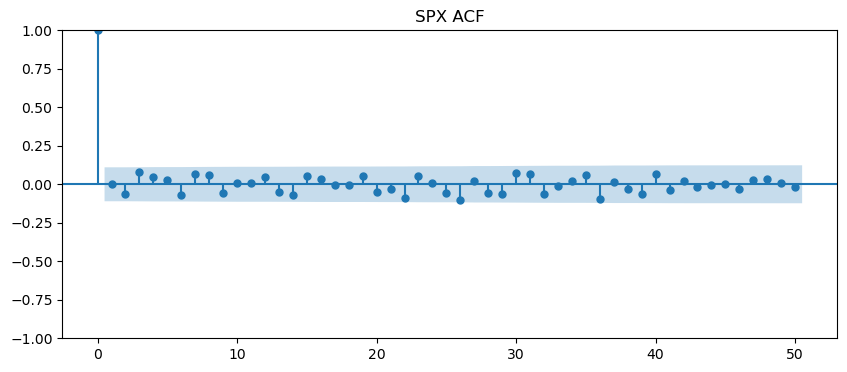

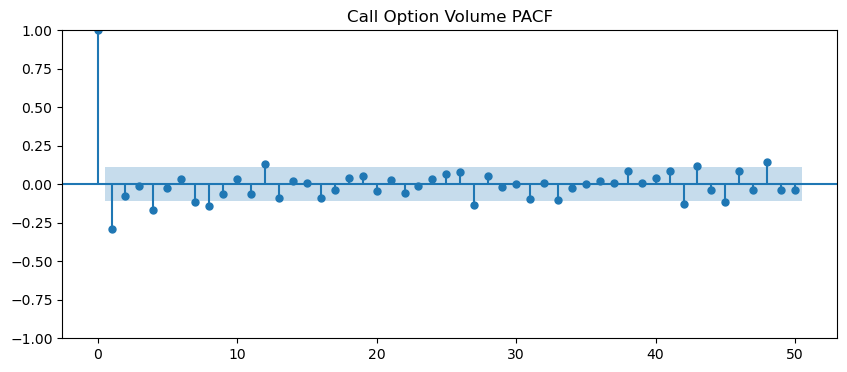

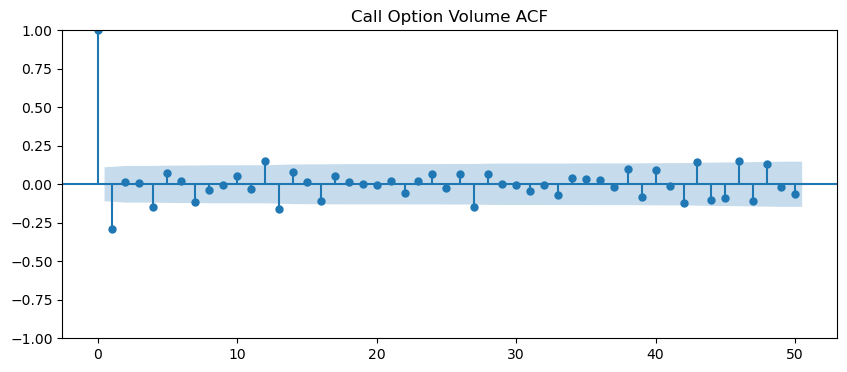

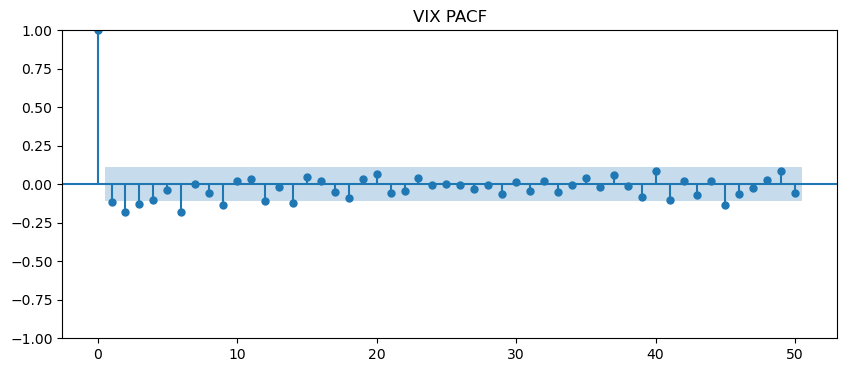

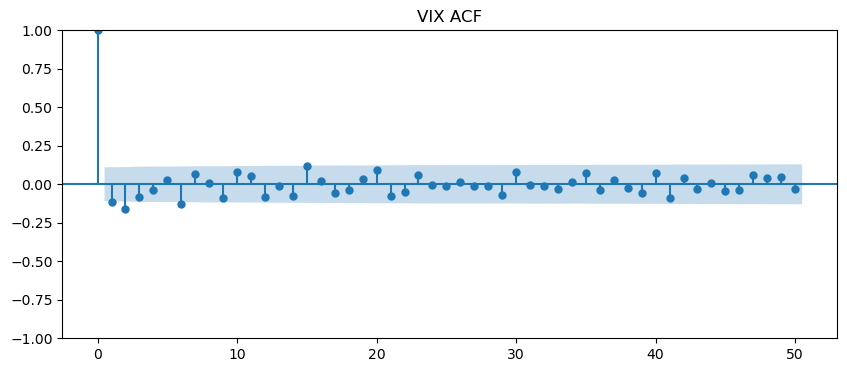

In [36]:
# Function to plot ACF and PACF
def PACF_ACF_plot(S):
    for column in range(len(S.columns)):
    # Plot PACF
        fig, ax = plt.subplots(figsize=(10, 4))
        plot_pacf(S.iloc[:,column], lags=50, ax=ax)
        ax.set_title('Partial Autocorrelation Function (PACF)')
        plt.title(S.columns[column] + ' PACF')
        plt.show()

        # Plot ACF
        fig, ax = plt.subplots(figsize=(10, 4))
        plot_acf(S.iloc[:,column], lags=50, ax=ax)
        ax.set_title('Autocorrelation Function (ACF)')
        plt.title(S.columns[column] + ' ACF')
        plt.show()
PACF_ACF_plot(combined_final_data)

## Exploring Time Series Analysis

In [37]:
def seasonality_trend_residual(S, model_type):
    ccardata_seasonal = pd.DataFrame(index=S.index, columns=S.columns)
    ccardata_trend = pd.DataFrame(index=S.index, columns=S.columns)
    ccardata_residual = pd.DataFrame(index=S.index, columns=S.columns)
    ccardata_SA = pd.DataFrame(index=S.index, columns=S.columns)
    
    for column in S.columns:
        seasonal_decomposition = sm.tsa.seasonal_decompose(S[column], model=model_type)
        deseasonalized = S[column] - seasonal_decomposition.seasonal

        
        ccardata_SA.loc[:, column] = deseasonalized
        ccardata_seasonal.loc[:, column] = seasonal_decomposition.seasonal
        ccardata_trend.loc[:, column] = seasonal_decomposition.trend
        ccardata_residual.loc[:, column] = seasonal_decomposition.resid
        

        
    return ccardata_seasonal, ccardata_trend, ccardata_residual,ccardata_SA

In [38]:
# Data with Dow Jones
combined_final_seasonal,combined_final_trend,combined_final_residual,combined_final_SA_data = seasonality_trend_residual(combined_final_data,'additive')
combined_final_trend = combined_final_trend.dropna()
combined_final_residual = combined_final_residual.dropna()

## ARIMA

In [39]:
# Function for finding out ARIMA pdq order and RMSE
def ARIMA_pdq_order(p_range, d_range, q_range, train_y, test_y):
    p_values = range(0, p_range)
    d_values = range(0, d_range)
    q_values = range(0, q_range)
    
    # Initialize variables
    best_rmse = float('inf')
    best_order = None
    
    # Generate all combinations of p, d, q values
    order_combinations = list(itertools.product(p_values, d_values, q_values))
    
    for order in order_combinations:
        try:
            # Create and fit the ARIMA model
            model = sm.tsa.ARIMA(train_y, order=order)
            results = model.fit()
            forecast_ARIMA = results.forecast(steps=len(test_y))
            rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMA))
            
            # Check if current RMSE is better than the previous best
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
        except:
            continue
                    
    # Print the best order values and RMSE
    return "Best Order:", best_order, "Best RMSE:", best_rmse

In [40]:
# Order Table
def ARIMA_order_table(order, train_y, test_y):

    # Create and fit the ARIMA model
    model = sm.tsa.ARIMA(train_y, order=order)
    results = model.fit()
    forecast_ARIMA = results.forecast(steps=len(test_y))
    rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMA))
    mape = np.mean(np.abs((test_y - forecast_ARIMA) / test_y)) * 100
    mae = mean_absolute_error(test_y, forecast_ARIMA)
    r_squared = r2_score(test_y, forecast_ARIMA)
    aic = results.aic
    bic = results.bic

    # Append the results to the table
    results_df = pd.DataFrame([[order, rmse, mape, mae, r_squared,aic, bic]],
                              columns=["Order", "RMSE", "MAPE", "MAE", "R-Squared","AIC", "BIC"])

    # Print the results in tabular form
    return (results_df)


In [41]:
# In-Sample RMSE and Prediction
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMA_model_in(train_y,test_y,order):
    model_ARIMA = sm.tsa.ARIMA(train_y, order=order)
    results_ARIMA = model_ARIMA.fit()
    forecast_ARIMA = results_ARIMA.forecast(steps=len(test_y))
    predict = results_ARIMA.predict(start = '1997-01-31', end ='2017-12-31')
    rmse = np.sqrt(mean_squared_error(predict,train_y))
    return rmse,predict

In [42]:
# Out-Sample RMSE,Prediction and Summary
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMA_model_out(train_y,test_y,order):
    model_ARIMA = sm.tsa.ARIMA(train_y, order=order)
    results_ARIMA = model_ARIMA.fit()
    forecast_ARIMA = results_ARIMA.forecast(steps=len(test_y))
    rmse = np.sqrt(mean_squared_error(forecast_ARIMA,test_y))
    summary = results_ARIMA.summary()
    return rmse,forecast_ARIMA,summary

In [43]:
# Train-Test Split
data_final = combined_final_data.columns
data_final_SA = combined_final_SA_data.columns
train_X, test_X, train_Y,test_Y = train_test_split(combined_final_data.iloc[:,0:len(data_final)-1],combined_final_data.iloc[:,-1],test_size=0.20,shuffle=False)

train_X_SA, test_X_SA, train_Y_SA,test_Y_SA = train_test_split(combined_final_SA_data.iloc[:,0:len(data_final_SA)-1],combined_final_SA_data.iloc[:,-1],test_size=0.20,shuffle=False)

### Modeling ARIMA

In [44]:
ARIMA_combined_total = ARIMA_pdq_order(4,4,4,train_Y,test_Y)
rmse_insample_ARIMA_combined_NSA1, forecast_ARIMA_insample_combined_NSA1 = ARIMA_model_in(train_Y,test_Y,ARIMA_combined_total[1])
rmse_outsample_ARIMA_combined_NSA1, forecast_ARIMA_outsample_combined_NSA1,ARIMA_summary_NSA1 = ARIMA_model_out(train_Y,test_Y,ARIMA_combined_total[1])
print('ARIMA Not Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMA_combined_NSA1)
print('Out sample RMSE:',rmse_outsample_ARIMA_combined_NSA1)
ARIMA_summary_NSA1

ARIMA Not Seasonally Adjusted
In sample RMSE: 6.159766175004218
Out sample RMSE: 6.912451902029604


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                  252
Model:                 ARIMA(1, 3, 2)   Log Likelihood                -805.717
Date:                Thu, 27 Jul 2023   AIC                           1619.434
Time:                        11:07:20   BIC                           1633.504
Sample:                    01-31-1997   HQIC                          1625.097
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4177      0.044     -9.577      0.000      -0.503      -0.332
ma.L1         -1.9968      5.212     -0.383      0.702     -12.211       8.218
ma.L2          0.9998      5.221      0.191      0.848      -9.233      11.233
sigma2        35.3516    184.929      0.191      0.848    -327.103     397.806
===================================================================================
Ljung-Box (L1) (Q):                   6.18   Jarque-Bera (JB):               126.53
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.79
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Stationary SA 
rmse_insample_ARIMA_combined_SA, forecast_ARIMA_insample_combined_SA = ARIMA_model_in(train_Y_SA,test_Y_SA,ARIMA_combined_total[1])
rmse_outsample_ARIMA_combined_SA, forecast_ARIMA_outsample_combined_SA,ARIMA_summary_SA = ARIMA_model_out(train_Y_SA,test_Y_SA,ARIMA_combined_total[1])
print('ARIMA Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMA_combined_SA)
print('Out sample RMSE:',rmse_outsample_ARIMA_combined_SA)
ARIMA_summary_SA

ARIMA Seasonally Adjusted
In sample RMSE: 6.06882027663519
Out sample RMSE: 7.826598840220953


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                  252
Model:                 ARIMA(1, 3, 2)   Log Likelihood                -802.155
Date:                Thu, 27 Jul 2023   AIC                           1612.311
Time:                        11:07:21   BIC                           1626.380
Sample:                    01-31-1997   HQIC                          1617.974
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4320      0.043     -9.962      0.000      -0.517      -0.347
ma.L1         -1.9964      2.185     -0.914      0.361      -6.279       2.286
ma.L2          0.9994      2.189      0.457      0.648      -3.290       5.289
sigma2        34.3616     75.628      0.454      0.650    -113.867     182.590
===================================================================================
Ljung-Box (L1) (Q):                   6.99   Jarque-Bera (JB):                77.43
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.64
Prob(H) (two-sided):                  0.42   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# Comparing metrics of NSA & SA ARIMAX
pd.concat([ARIMA_order_table((1,3,2), train_Y,test_Y).rename(index={0: 'ARIMA NSA'}),
          ARIMA_order_table((1,3,2),train_Y_SA,test_Y_SA).rename(index={0: 'ARIMA SA'}),], axis=0)


Order      RMSE        MAPE       MAE  R-Squared          AIC  \
ARIMA NSA  (1, 3, 2)  6.912452  126.517796  5.118622   0.003657  1619.433994   
ARIMA SA   (1, 3, 2)  7.826599  408.532911  6.148778  -0.341580  1612.310616   

                   BIC  
ARIMA NSA  1633.503805  
ARIMA SA   1626.380428

### ARIMA Plots

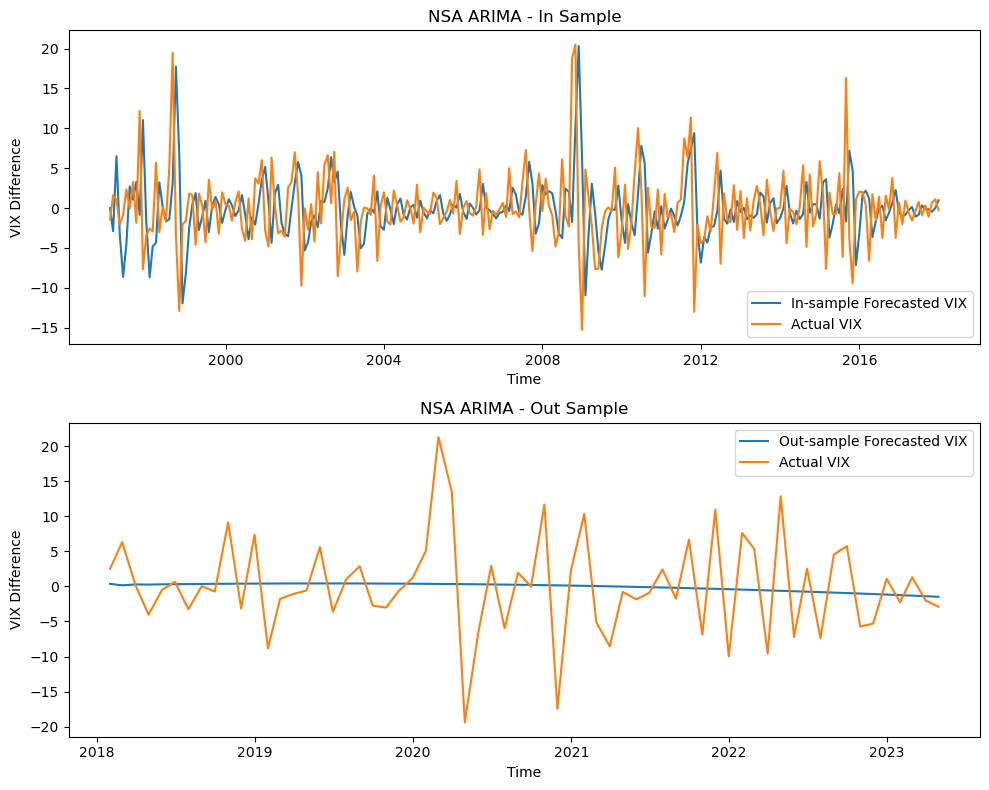

In [47]:
# NSA Plots
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary NSA In Sample 
axs[0].plot(forecast_ARIMA_insample_combined_NSA1, label='In-sample Forecasted VIX')
axs[0].plot(train_Y, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('NSA ARIMA - In Sample')
axs[0].legend()

# Second subplot - Stationary NSA Out Sample 
axs[1].plot(forecast_ARIMA_outsample_combined_NSA1, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('NSA ARIMA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


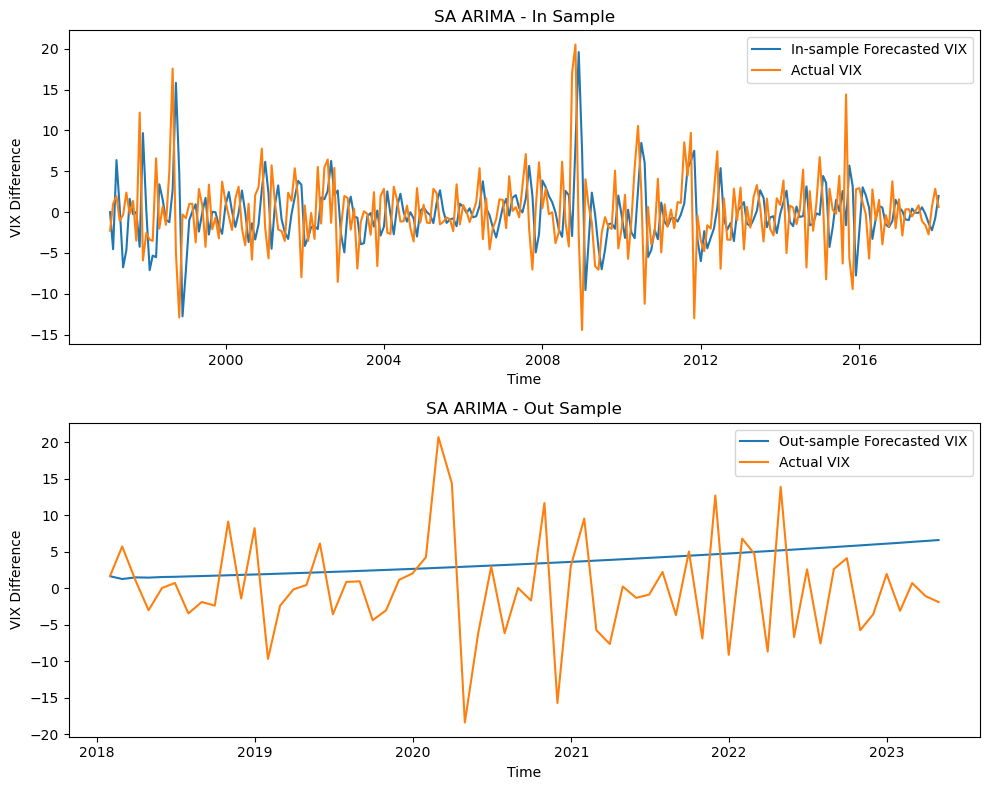

In [48]:
# SA Plots
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary SA In Sample 
axs[0].plot(forecast_ARIMA_insample_combined_SA, label='In-sample Forecasted VIX')
axs[0].plot(train_Y_SA, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('SA ARIMA - In Sample')
axs[0].legend()

# Second subplot - Stationary SA Out Sample 
axs[1].plot(forecast_ARIMA_outsample_combined_SA, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y_SA, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('SA ARIMA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## ARIMAX

In [49]:
# Function for finding out ARIMAX pdq order and RMSE
def ARIMAX_pdq_order(p_range, d_range, q_range, train_x, test_x, train_y, test_y):
    p_values = range(0, p_range)
    d_values = range(0, d_range)
    q_values = range(0, q_range)

    # Initialize variables
    best_rmse = float('inf')
    best_order = None

    # Generate all combinations of p, d, q values
    order_combinations = list(itertools.product(p_values, d_values, q_values))

    for order in order_combinations:
        try:
            # Create and fit the ARIMAX model
            model = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
            results = model.fit()
            forecast_ARIMAX = results.forecast(steps=len(test_y), exog=test_x)
            rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMAX))

            # Check if current RMSE is better than the previous best
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order

        except:
            continue

    # Print the best order values and RMSE
    return "Best Order:", best_order, "Best RMSE:", best_rmse

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def ARIMAX_order_table(train_x, test_x, train_y, test_y, order):
    # Create and fit the ARIMAX model
    model = sm.tsa.ARIMA(train_y, exog=train_x, order=order)
    results = model.fit()
    forecast_ARIMAX = results.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(test_y, forecast_ARIMAX))
    mape = np.mean(np.abs((test_y - forecast_ARIMAX) / test_y)) * 100
    mae = mean_absolute_error(test_y, forecast_ARIMAX)
    r_squared = r2_score(test_y, forecast_ARIMAX)
    aic = results.aic
    bic = results.bic

    # Create a DataFrame to store the results
    results_df = pd.DataFrame([[order, rmse, mape, mae, r_squared,aic, bic]],
                              columns=["Order", "RMSE", "MAPE", "MAE", "R-Squared","AIC", "BIC"])

    # Print the results in tabular form
    return results_df

In [51]:
# In-Sample RMSE and Prediction
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMAX_model_in(train_x,test_x,train_y,test_y,order):
    model_ARIMAX = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
    results_ARIMAX = model_ARIMAX.fit()
    forecast_ARIMAX = results_ARIMAX.forecast(steps=len(test_y), exog=test_x)
    predict = results_ARIMAX.predict(start = '1997-01-31', end ='2017-12-31')
    rmse = np.sqrt(mean_squared_error(predict,train_y))
    return rmse,predict

In [52]:
# Out-Sample RMSE,Prediction and Summary
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMAX_model_out(train_x,test_x,train_y,test_y,order):
    model_ARIMAX = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
    results_ARIMAX = model_ARIMAX.fit()
    forecast_ARIMAX = results_ARIMAX.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(forecast_ARIMAX,test_y))
    summary = results_ARIMAX.summary()
    return rmse,forecast_ARIMAX,summary

In [53]:
# Train-Test Split
data_final = combined_final_data.columns
data_final_SA = combined_final_SA_data.columns
train_X, test_X, train_Y,test_Y = train_test_split(combined_final_data.iloc[:,0:len(data_final)-1],combined_final_data.iloc[:,-1],test_size=0.20,shuffle=False)

train_X_SA, test_X_SA, train_Y_SA,test_Y_SA = train_test_split(combined_final_SA_data.iloc[:,0:len(data_final_SA)-1],combined_final_SA_data.iloc[:,-1],test_size=0.20,shuffle=False)

### Modeling ARIMAX

In [54]:
# Summary for all features
ARIMAX_combined_total = ARIMAX_pdq_order(4,4,4,train_X, test_X, train_Y,test_Y)
rmse_insample_ARIMAX_combined_NSA1, forecast_ARIMAX_insample_combined_NSA1 = ARIMAX_model_in(train_X, test_X, train_Y,test_Y,ARIMAX_combined_total[1])
rmse_outsample_ARIMAX_combined_NSA1, forecast_ARIMAX_outsample_combined_NSA1,ARIMAX_summary_NSA1 = ARIMAX_model_out(train_X, test_X, train_Y,test_Y,ARIMAX_combined_total[1])
print('ARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMAX_combined_NSA1)
print('Out sample RMSE:',rmse_outsample_ARIMAX_combined_NSA1)
ARIMAX_summary_NSA1

ARIMAX Not Seasonally Adjusted
In sample RMSE: 3.062226291814815
Out sample RMSE: 4.660227372934771


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                  252
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -632.604
Date:                Thu, 27 Jul 2023   AIC                           1309.208
Time:                        11:08:43   BIC                           1386.680
Sample:                    01-31-1997   HQIC                          1340.388
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Unemp Rate                     -1.0442      1.562     -0.669      0.504      -4.105       2.017
CPI                             1.9213      1.149      1.672      0.095      -0.331       4.173
3m TSY                          1.8745      1.764      1.062      0.288      -1.584       5.333
5Y TSY                         -1.0229      3.293     -0.311      0.756      -7.478       5.432
10Y TSY                         4.2580      3.205      1.329      0.184      -2.023      10.539
Mortgage Rate                  -3.0933      1.926     -1.606      0.108      -6.869       0.682
Prime Rate                     -0.8418      1.991     -0.423      0.672      -4.744       3.061
Effective Federal Fund Rate    -1.4256      0.792     -1.801      0.072      -2.977       0.126
MCSI                            0.0062      0.045      0.137      0.891      -0.082       0.095
PPI                            -0.0226      0.324     -0.070      0.944      -0.657       0.612
M1                              0.0207      0.268      0.077      0.938      -0.504       0.545
M2                             -0.6391      0.673     -0.949      0.342      -1.959       0.680
ICSA                           -0.0108      0.012     -0.896      0.370      -0.034       0.013
OAS BBB Corp                    3.6602      0.988      3.705      0.000       1.724       5.597
Dollar                          0.1074      0.096      1.114      0.265      -0.082       0.296
SPX                            -0.6481      0.050    -12.976      0.000      -0.746      -0.550
Call Option Volume              0.0177      0.011      1.643      0.100      -0.003       0.039
ar.L1                          -0.9934      0.144     -6.894      0.000      -1.276      -0.711
ma.L1                          -0.9838     61.374     -0.016      0.987    -121.276     119.308
ma.L2                          -1.0000    118.039     -0.008      0.993    -232.351     230.351
ma.L3                           0.9838     63.752      0.015      0.988    -123.967     125.935
sigma2                          8.5888    555.709      0.015      0.988   -1080.581    1097.759
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):                29.68
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.01
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Features selected based on p-values from the above summary table
features_selected = ['CPI','10Y TSY', 'Mortgage Rate','OAS BBB Corp', 'SPX']
# For NSA Data
ARIMAX_combined = ARIMAX_pdq_order(4,4,4,train_X[features_selected], test_X[features_selected], train_Y,test_Y)
# For SA Data
ARIMAX_combined_SA = ARIMAX_pdq_order(4,4,4,train_X_SA[features_selected], test_X_SA[features_selected], train_Y_SA,test_Y_SA)

In [56]:
# Stationary NSA 
rmse_insample_ARIMAX_combined_NSA, forecast_ARIMAX_insample_combined_NSA = ARIMAX_model_in(train_X[features_selected], test_X[features_selected], train_Y,test_Y,ARIMAX_combined[1])
rmse_outsample_ARIMAX_combined_NSA, forecast_ARIMAX_outsample_combined_NSA,ARIMAX_summary_NSA = ARIMAX_model_out(train_X[features_selected], test_X[features_selected], train_Y,test_Y,ARIMAX_combined[1])
print('ARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMAX_combined_NSA)
print('Out sample RMSE:',rmse_outsample_ARIMAX_combined_NSA)
ARIMAX_summary_NSA

ARIMAX Not Seasonally Adjusted
In sample RMSE: 4.25071702161488
Out sample RMSE: 4.2591247278034485


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                  252
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -716.475
Date:                Thu, 27 Jul 2023   AIC                           1446.950
Time:                        11:09:56   BIC                           1471.600
Sample:                    01-31-1997   HQIC                          1456.871
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
CPI               1.8396      0.881      2.088      0.037       0.113       3.567
10Y TSY           3.4440      1.571      2.192      0.028       0.365       6.523
Mortgage Rate    -3.1512      1.567     -2.010      0.044      -6.223      -0.079
OAS BBB Corp      2.2733      0.628      3.618      0.000       1.042       3.505
SPX              -0.7764      0.036    -21.756      0.000      -0.846      -0.706
ma.L1            -0.9999     10.948     -0.091      0.927     -22.459      20.459
sigma2           17.6731    193.464      0.091      0.927    -361.509     396.855
===================================================================================
Ljung-Box (L1) (Q):                  50.26   Jarque-Bera (JB):                53.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.19
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
# Stationary SA 
rmse_insample_ARIMAX_combined_SA, forecast_ARIMAX_insample_combined_SA = ARIMAX_model_in(train_X_SA[features_selected], test_X_SA[features_selected], train_Y_SA,test_Y_SA,ARIMAX_combined_SA[1])
rmse_outsample_ARIMAX_combined_SA, forecast_ARIMAX_outsample_combined_SA,ARIMAX_summary_SA = ARIMAX_model_out(train_X_SA[features_selected], test_X_SA[features_selected], train_Y_SA,test_Y_SA,ARIMAX_combined_SA[1])
print('ARIMAX Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_ARIMAX_combined_SA)
print('Out sample RMSE:',rmse_outsample_ARIMAX_combined_SA)
ARIMAX_summary_SA

ARIMAX Seasonally Adjusted
In sample RMSE: 4.203324405909779
Out sample RMSE: 4.14449946917399


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                  252
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -713.709
Date:                Thu, 27 Jul 2023   AIC                           1441.417
Time:                        11:09:56   BIC                           1466.067
Sample:                    01-31-1997   HQIC                          1451.338
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
CPI               1.9385      0.909      2.132      0.033       0.156       3.720
10Y TSY           3.4599      1.523      2.272      0.023       0.475       6.445
Mortgage Rate    -3.2518      1.554     -2.093      0.036      -6.297      -0.207
OAS BBB Corp      2.0163      0.644      3.133      0.002       0.755       3.278
SPX              -0.7999      0.037    -21.480      0.000      -0.873      -0.727
ma.L1            -0.9999      7.847     -0.127      0.899     -16.381      14.381
sigma2           17.2824    135.582      0.127      0.899    -248.454     283.019
===================================================================================
Ljung-Box (L1) (Q):                  49.48   Jarque-Bera (JB):                44.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.12
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
# Comparing metrics of NSA & SA ARIMAX
pd.concat([ARIMAX_order_table(train_X[features_selected], test_X[features_selected], train_Y,test_Y,ARIMAX_combined[1]).rename(index={0: 'ARIMAX NSA selected Features'}),
          ARIMAX_order_table(train_X_SA[features_selected], test_X_SA[features_selected], train_Y_SA,test_Y_SA,ARIMAX_combined_SA[1]).rename(index={0: 'ARIMAX SA selected Features'})], axis=0)


Order      RMSE        MAPE       MAE  \
ARIMAX NSA selected Features  (0, 2, 1)  4.259125  346.901109  3.136432   
ARIMAX SA selected Features   (0, 2, 1)  4.144499  366.064260  3.090151   

                              R-Squared          AIC          BIC  
ARIMAX NSA selected Features   0.621744  1446.949693  1471.599920  
ARIMAX SA selected Features    0.623804  1441.417061  1466.067288

### ARIMAX Plots

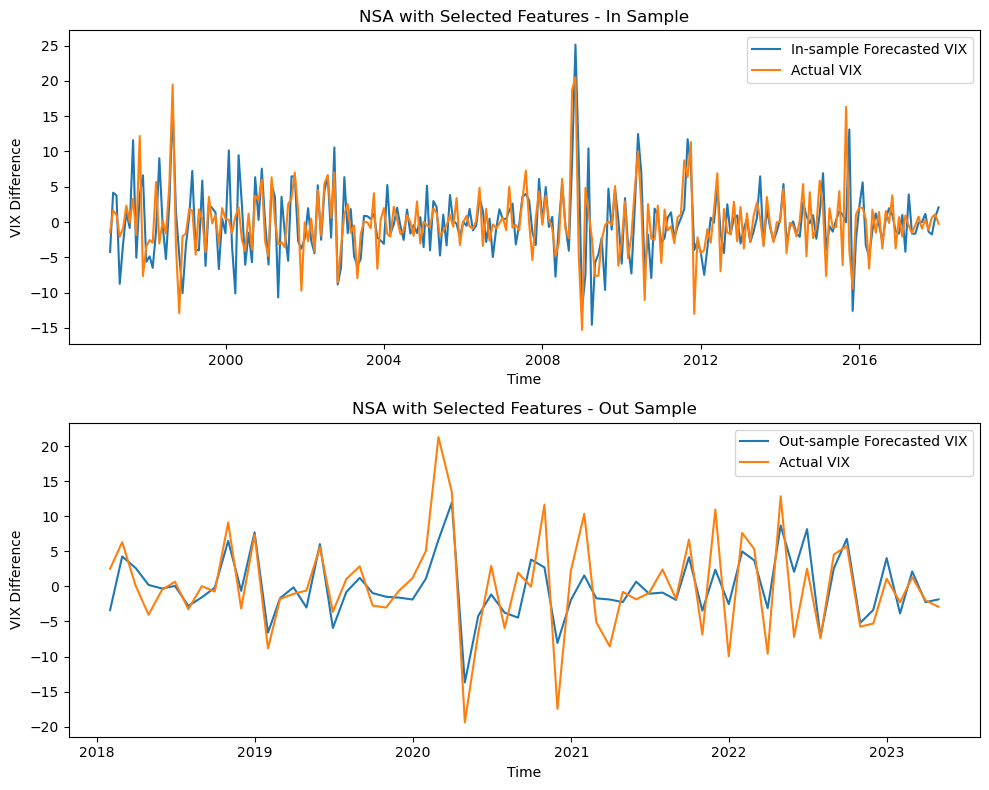

In [59]:
# NSA Plots
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary NSA In Sample 
axs[0].plot(forecast_ARIMAX_insample_combined_NSA, label='In-sample Forecasted VIX')
axs[0].plot(train_Y, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('NSA with Selected Features - In Sample')
axs[0].legend()

# Second subplot - Stationary NSA Out Sample 
axs[1].plot(forecast_ARIMAX_outsample_combined_NSA, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('NSA with Selected Features - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


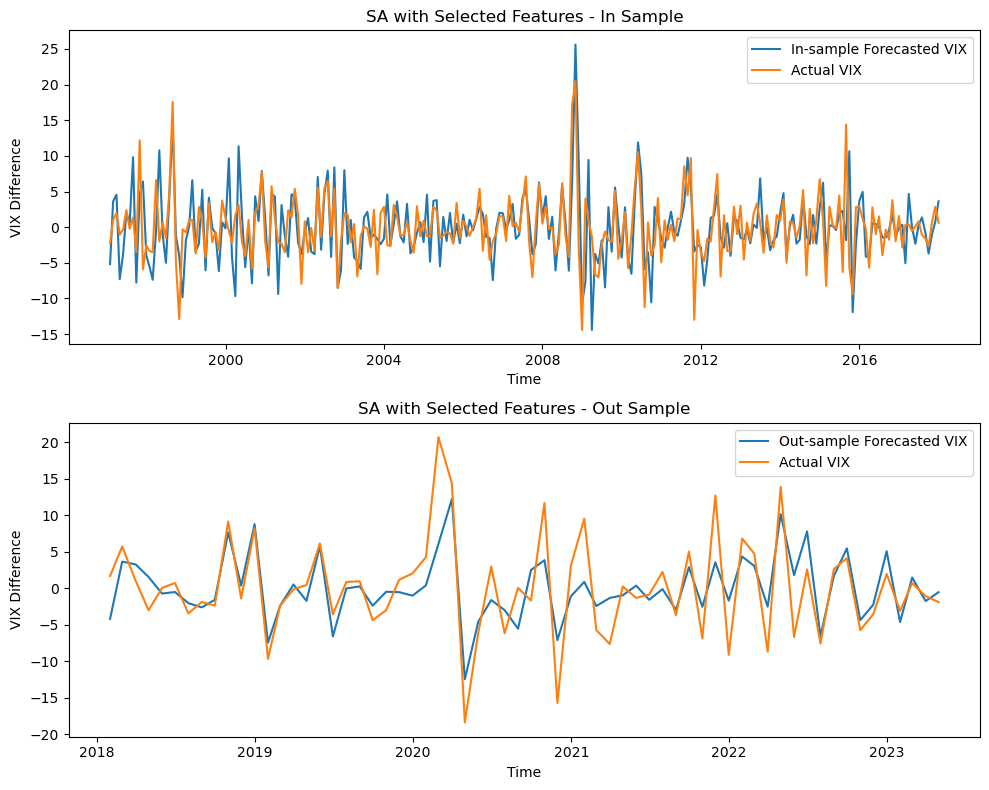

In [60]:
# SA Plots
# Create subplots with two rows and one column
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary SA In Sample 
axs[0].plot(forecast_ARIMAX_insample_combined_SA, label='In-sample Forecasted VIX')
axs[0].plot(train_Y_SA, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('SA with Selected Features - In Sample')
axs[0].legend()

# Second subplot - Stationary SA Out Sample 
axs[1].plot(forecast_ARIMAX_outsample_combined_SA, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y_SA, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('SA with Selected Features - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [61]:
# Checking Direction Accuracy
# Function to determine the direction of a dataset
def get_direction(data):
    direction = []
    for i in range(1, len(data)):
        if data.iloc[i, 0] > data.iloc[i-1, 0]:
            direction.append(1)  # Increasing
        elif data.iloc[i, 0] < data.iloc[i-1, 0]:
            direction.append(-1)  # Decreasing
        else:
            direction.append(0)  # No change
    return direction

# Determine directions of y_test and y_pred
y_test_direction = get_direction(pd.DataFrame(test_Y_SA))
y_pred_direction = get_direction(pd.DataFrame(forecast_ARIMAX_outsample_combined_SA))

# Compare the directions and count the number of matching cases
matching_count = sum(1 for i in range(len(y_test_direction)) if y_test_direction[i] == y_pred_direction[i])

# Print the results
print("Number of matching cases:", matching_count)
print("Percentage:", (matching_count/len(y_test_direction)))

Number of matching cases: 50
Percentage: 0.7936507936507936


## ARIMAX - GARCH

In [62]:
def find_best_arimax_garch_order(trainx_combined_SA, testx_combined_SA, trainy_combined_SA,testy_combined_SA):
    p_values = range(1, 4)
    d_values = range(0, 4)
    q_values = range(1, 4)
    pdq = list(itertools.product(p_values, d_values, q_values))

    P_values = range(1, 4)
    Q_values = range(1, 4)
    pq = list(itertools.product(P_values, Q_values))

    best_rmse = float('inf')
    best_arima_order = None
    best_garch_order = None

    for arima_order in pdq:
        for garch_order in pq:
            # Create and fit the ARIMAX model
            model = sm.tsa.ARIMA(trainy_combined_SA, order=arima_order, exog=trainx_combined_SA)
            arima_results = model.fit()
            arima_residuals = arima_results.resid
            arima_pred = arima_results.forecast(steps=len(testy_combined_SA), exog=testx_combined_SA)

            garch_model = arch.arch_model(arima_residuals, vol='Garch', p=garch_order[0], q=garch_order[1])
            results = garch_model.fit()
            garch_pred = results.forecast(horizon=len(testy_combined_SA))
            garch_var = np.sqrt(garch_pred.variance.iloc[-1, :])
            garch_var.index = testy_combined_SA.index
            garch_mean = garch_var.mean()
            total = garch_mean + arima_pred
            rmse = np.sqrt(mean_squared_error(testy_combined_SA, total))

            if rmse < best_rmse:
                best_rmse = rmse
                best_arima_order = arima_order
                best_garch_order = garch_order

    return best_arima_order, best_garch_order

In [63]:
# Order Table
def arimax_garch_analysis(trainx_combined_SA, testx_combined_SA, trainy_combined_SA,testy_combined_SA):
    # Fit ARIMAX model
    model_arimax = sm.tsa.ARIMA(trainy_combined_SA, order=(2,0,2), exog=trainx_combined_SA)
    arimax_results = model_arimax.fit()
    arimax_residuals = arimax_results.resid
    
    # Perform GARCH modeling
    garch_model = arch.arch_model(arimax_residuals, vol='Garch', p=3, q=3)
    garch_results = garch_model.fit()
    
    # Generate ARIMAX-GARCH predictions
    arimax_pred = arimax_results.forecast(steps=len(testy_combined_SA), exog=testx_combined_SA)
    garch_pred = garch_results.forecast(horizon=len(testy_combined_SA))
    a = np.sqrt(garch_pred.variance.iloc[-1, :])
    a.index = testy_combined_SA.index
    a_mean = a.mean()
    total = arimax_pred + a_mean
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(testy_combined_SA, total))
    mape = np.mean(np.abs((testy_combined_SA - total) / testy_combined_SA)) * 100
    mae = mean_absolute_error(testy_combined_SA, total)
    r_squared = r2_score(testy_combined_SA, total)
    aic = arimax_results.aic + garch_results.aic
    bic = arimax_results.bic + garch_results.bic
    
    # Create output table
    output_table = pd.DataFrame({
        'ARIMAX-GARCH Order': [f'ARIMA{(2,0,2)}-GARCH({(3)}, {(3)})'],
        'RMSE': [rmse],
        'MAPE': [mape],
        'MAE': [mae],
        'R-squared': [r_squared],
        'AIC': [aic],
        'BIC': [bic]
    })
    
    return output_table

### Modeling ARIMAX-GARCH

In [65]:
import arch
model1 = sm.tsa.ARIMA(train_Y_SA, order=(2,0,2),exog = train_X_SA[features_selected])
arima_results = model1.fit()
arima_residuals = arima_results.resid
arima_pred = arima_results.forecast(steps = len(test_Y_SA),exog = test_X_SA[features_selected])

garch_model = arch.arch_model(arima_residuals, vol = 'Garch', p = 3, q = 3)
results12 = garch_model.fit()
garch_pred = results12.forecast(horizon = len(test_Y_SA))
garch_var = np.sqrt(garch_pred.variance.iloc[-1,:])
garch_var.index = test_Y_SA.index
total12 = arima_pred + garch_var
ARIMAX_GARCH_SUMMARY = results12.summary()
ARIMAX_GARCH_SUMMARY

Iteration:      1,   Func. Count:     10,   Neg. LLF: 8105.33921686291
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2050.373636042681
Iteration:      3,   Func. Count:     30,   Neg. LLF: 739.8531103199621
Iteration:      4,   Func. Count:     41,   Neg. LLF: 690.9012774413333
Iteration:      5,   Func. Count:     52,   Neg. LLF: 632.5422439499148
Iteration:      6,   Func. Count:     62,   Neg. LLF: 608.6962410186549
Iteration:      7,   Func. Count:     72,   Neg. LLF: 606.9218182532817
Iteration:      8,   Func. Count:     81,   Neg. LLF: 607.9976283488708
Iteration:      9,   Func. Count:     91,   Neg. LLF: 606.7636360968577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 606.7621323263345
Iteration:     11,   Func. Count:    109,   Neg. LLF: 606.7621248355658
Iteration:     12,   Func. Count:    118,   Neg. LLF: 606.7621240682438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 606.7621240682438
            Iterations: 12
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -606.762
Distribution:                  Normal   AIC:                           1229.52
Method:            Maximum Likelihood   BIC:                           1257.76
                                        No. Observations:                  252
Date:                Thu, Jul 27 2023   Df Residuals:                      251
Time:                        11:10:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0960      0.159      0.603      0.546 [ -0.216,  0.408]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          2.2319      4.842      0.461      0.645 [ -7.258, 11.722]
alpha[1]       0.2143      0.182      1.177      0.239 [ -0.142,  0.571]
alpha[2]       0.2468      0.398      0.620      0.535 [ -0.533,  1.026]
alpha[3]       0.0000      0.495      0.000      1.000 [ -0.970,  0.970]
beta[1]    1.5127e-14      1.118  1.353e-14      1.000 [ -2.191,  2.191]
beta[2]        0.0000      0.877      0.000      1.000 [ -1.720,  1.720]
beta[3]        0.2794      0.467      0.598      0.550 [ -0.636,  1.195]
========================================================================

Covariance estimator: robust
"""

In [66]:
arimax_garch_analysis(train_X_SA[features_selected], test_X_SA[features_selected], train_Y_SA,test_Y_SA).rename(index={0: 'ARIMAX SA'})

Iteration:      1,   Func. Count:     10,   Neg. LLF: 8105.33921686291
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2050.373636042681
Iteration:      3,   Func. Count:     30,   Neg. LLF: 739.8531103199621
Iteration:      4,   Func. Count:     41,   Neg. LLF: 690.9012774413333
Iteration:      5,   Func. Count:     52,   Neg. LLF: 632.5422439499148
Iteration:      6,   Func. Count:     62,   Neg. LLF: 608.6962410186549
Iteration:      7,   Func. Count:     72,   Neg. LLF: 606.9218182532817
Iteration:      8,   Func. Count:     81,   Neg. LLF: 607.9976283488708
Iteration:      9,   Func. Count:     91,   Neg. LLF: 606.7636360968577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 606.7621323263345
Iteration:     11,   Func. Count:    109,   Neg. LLF: 606.7621248355658
Iteration:     12,   Func. Count:    118,   Neg. LLF: 606.7621240682438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 606.7621240682438
            Iterations: 12
  

ARIMAX-GARCH Order      RMSE       MAPE       MAE  \
ARIMAX SA  ARIMA(2, 0, 2)-GARCH(3, 3)  5.185965  337.57712  4.125235   

           R-squared          AIC          BIC  
ARIMAX SA   0.410981  2498.827935  2565.887087

### ARIMAX-GARCH Plots

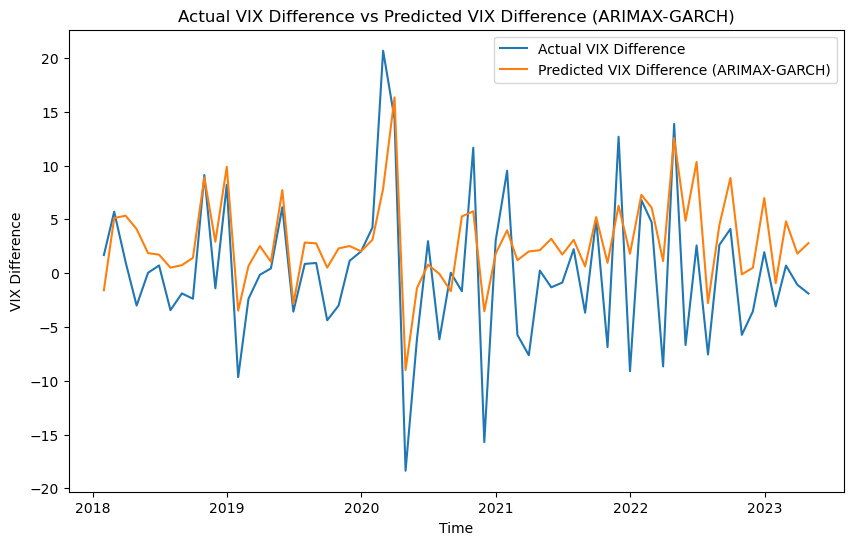

In [67]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_Y_SA, label='Actual VIX Difference')
plt.plot(total12, label='Predicted VIX Difference (ARIMAX-GARCH)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual VIX Difference vs Predicted VIX Difference (ARIMAX-GARCH)')
plt.legend()
plt.show()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 8105.33921686291
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2050.373636042681
Iteration:      3,   Func. Count:     30,   Neg. LLF: 739.8531103199621
Iteration:      4,   Func. Count:     41,   Neg. LLF: 690.9012774413333
Iteration:      5,   Func. Count:     52,   Neg. LLF: 632.5422439499148
Iteration:      6,   Func. Count:     62,   Neg. LLF: 608.6962410186549
Iteration:      7,   Func. Count:     72,   Neg. LLF: 606.9218182532817
Iteration:      8,   Func. Count:     81,   Neg. LLF: 607.9976283488708
Iteration:      9,   Func. Count:     91,   Neg. LLF: 606.7636360968577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 606.7621323263345
Iteration:     11,   Func. Count:    109,   Neg. LLF: 606.7621248355658
Iteration:     12,   Func. Count:    118,   Neg. LLF: 606.7621240682438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 606.7621240682438
            Iterations: 12
  

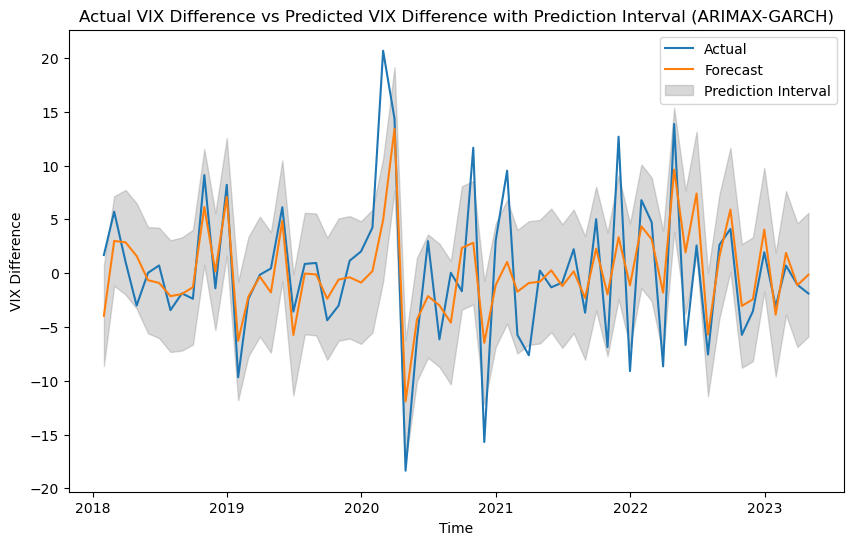

In [68]:
# Plotting ARIMAX=GARCH with prediction intervals
model11 = sm.tsa.ARIMA(train_Y_SA, order=(2,0,2),exog = train_X_SA[features_selected])
arimax_results = model11.fit()
arimax_residuals = arimax_results.resid
arimax_pred = arimax_results.forecast(steps = len(test_Y_SA),exog = test_X_SA[features_selected])

garch_model1 = arch.arch_model(arimax_residuals, vol = 'Garch', p = 3, q = 3)
results11 = garch_model1.fit()
garch_pred11 = results11.forecast(horizon = len(test_Y_SA))
ad = np.sqrt(garch_pred11.variance.iloc[-1,:])
ad.index = test_Y_SA.index 
total_interval = arimax_pred

confidence_level = 0.95  # Change as desired
z_value = norm.ppf(1 - (1 - confidence_level) / 2)
total_interval_upper = arimax_pred + (z_value * ad)
total_interval_lower = arimax_pred - (z_value * ad)
arimax_garch_summary = results11.summary()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(test_Y_SA, label='Actual')
plt.plot(total_interval, label='Forecast')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual VIX Difference vs Predicted VIX Difference with Prediction Interval (ARIMAX-GARCH)')
plt.fill_between(test_Y_SA.index, total_interval_lower, total_interval_upper, color='gray', alpha=0.3, label='Prediction Interval')
plt.legend()
plt.show()

In [69]:
# Direction Accuracy
# Determine directions of y_test and y_pred
y_test_direction1 = get_direction(pd.DataFrame(test_Y_SA))
y_pred_direction1 = get_direction(pd.DataFrame(total12))

# Compare the directions and count the number of matching cases
matching_count1 = sum(1 for i in range(len(y_test_direction1)) if y_test_direction1[i] == y_pred_direction1[i])

# Print the results
print("Number of matching cases:",matching_count1 )
print("Percentage:", (matching_count1/len(y_test_direction1)))


Number of matching cases: 49
Percentage: 0.7777777777777778


## SARIMAX

In [70]:
def SARIMAX_order(X_train, X_test, Y_train,Y_test,s):
    p_values = range(1, 3)
    d_values = range(0, 3)
    q_values = range(1, 3)
    pdq = list(itertools.product(p_values, d_values, q_values))

    P_values = range(1, 3)
    D_values = range(0, 3)
    Q_values = range(1, 3)
    S_values = s
    pdqs = list(itertools.product(P_values, D_values, Q_values, S_values))

    best_rmse = float('inf')
    best_order = None
    best_seasonal_order = None

    for i in range(len(pdq)):
        for j in range(len(pdqs)):
            # Create and fit the SARIMAX model
            model = sm.tsa.SARIMAX(Y_train, order=pdq[i], seasonal_order=pdqs[j], exog=X_train)
            results = model.fit()
            forecast_SARIMAX = results.forecast(steps=len(Y_test), exog=X_test)
            rmse = np.sqrt(mean_squared_error(Y_test, forecast_SARIMAX))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = pdq[i]
                best_seasonal_order = pdqs[j]

    print(f"Order: {best_order}, Seasonal Order: {best_seasonal_order}, RMSE: {best_rmse}")

In [71]:
def SARIMAX_order_table(train_x, test_x, train_y, test_y, order, seasonal_order):
    # Create and fit the SARIMAX model
    model = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    forecast_SARIMAX = results.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(test_y, forecast_SARIMAX))
    mape = np.mean(np.abs((test_y - forecast_SARIMAX) / test_y)) * 100
    mae = mean_absolute_error(test_y, forecast_SARIMAX)
    r_squared = r2_score(test_y, forecast_SARIMAX)
    aic = results.aic
    bic = results.bic

    # Create a DataFrame to store the results
    results_df = pd.DataFrame([[order, seasonal_order, rmse, mape, mae, r_squared, aic, bic]],
                              columns=["Order", "Seasonal Order", "RMSE", "MAPE", "MAE", "R-squared", "AIC", "BIC"])

    # Print the results in tabular form
    return results_df

In [72]:
def SARIMAX_model_in(train_x, test_x, train_y, test_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_y), exog=test_x)
    predict = results_SARIMAX.predict(start='1997-01-31', end='2017-12-31')
    rmse = np.sqrt(mean_squared_error(predict, train_y))
    r_squared = r2_score(train_y, predict)
    return rmse, predict,r_squared

In [73]:
def SARIMAX_model_out(train_x, test_x, train_y, test_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_y), exog=test_x)
    rmse = np.sqrt(mean_squared_error(forecast_SARIMAX, test_y))
    r_squared = r2_score(test_y, forecast_SARIMAX)
    summary_table = results_SARIMAX.summary()
    return rmse, forecast_SARIMAX,r_squared,summary_table

In [74]:
sarimax_features = ['CPI','10Y TSY', 'Mortgage Rate','OAS BBB Corp', 'SPX','VIX']
sarimax_data_NSA = combined_final_data[sarimax_features]

In [75]:
# SPX Seasonally Adjusted
train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA = train_test_split(sarimax_data_NSA.iloc[:,0:len(sarimax_data_NSA.columns)-1],sarimax_data_NSA.iloc[:,-1],test_size=0.20,shuffle=False)

In [76]:
# SARIMAX_order(train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA,[12])

### Modeling SARIMAX

In [77]:
# SARIMAX NSA
rmse_insample_SARIMAX_selected, forecast_SARIMAX_insample_selected,R_squared_in = SARIMAX_model_in(train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA,(2,2,1),(2,0,2,12))
rmse_outsample_SARIMAX_selected, forecast_SARIMAX_outsample_selected,R_squared_out,SARIMAX_summary = SARIMAX_model_out(train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA,(2,2,1),(2,0,2,12))
print('SARIMAX Not Seasonally Adjusted')
print('In sample RMSE:',rmse_insample_SARIMAX_selected)
print('Out sample RMSE:',rmse_outsample_SARIMAX_selected)
print('R-squared:',R_squared_out)
SARIMAX_summary

SARIMAX Not Seasonally Adjusted
In sample RMSE: 3.4807598632323358
Out sample RMSE: 4.333122907442214
R-squared: 0.6084865283403282


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                     VIX   No. Observations:                  252
Model:             SARIMAX(2, 2, 1)x(2, 0, [1, 2], 12)   Log Likelihood                -666.048
Date:                                 Thu, 27 Jul 2023   AIC                           1358.097
Time:                                         11:10:52   BIC                           1403.876
Sample:                                     01-31-1997   HQIC                          1376.521
                                          - 12-31-2017                                         
Covariance Type:                                   opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
CPI               1.7329      0.751      2.308      0.021       0.261       3.205
10Y TSY           4.1101      1.485      2.768      0.006       1.200       7.021
Mortgage Rate    -4.2215      1.603     -2.633      0.008      -7.364      -1.079
OAS BBB Corp      4.7751      0.584      8.172      0.000       3.630       5.920
SPX              -0.7236      0.035    -20.554      0.000      -0.793      -0.655
ar.L1            -0.6496      0.058    -11.127      0.000      -0.764      -0.535
ar.L2            -0.3787      0.069     -5.514      0.000      -0.513      -0.244
ma.L1            -0.9957      0.146     -6.829      0.000      -1.281      -0.710
ar.S.L12          0.1474      0.222      0.665      0.506      -0.287       0.582
ar.S.L24         -0.6823      0.256     -2.662      0.008      -1.185      -0.180
ma.S.L12         -0.2403      0.200     -1.204      0.229      -0.631       0.151
ma.S.L24          0.8095      0.247      3.280      0.001       0.326       1.293
sigma2           11.3871      1.962      5.804      0.000       7.542      15.233
===================================================================================
Ljung-Box (L1) (Q):                   2.86   Jarque-Bera (JB):                18.03
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.02
Prob(H) (two-sided):                  0.20   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
SARIMAX_order_table(train_x_sarimax_NSA, test_x_sarimax_NSA, train_y_sarimax_NSA,test_y_sarimax_NSA,(2,2,1),(2,0,2,12)).rename(index={0: 'SARIMAX NSA'})

Order Seasonal Order      RMSE        MAPE       MAE  \
SARIMAX NSA  (2, 2, 1)  (2, 0, 2, 12)  4.333123  385.327254  3.285742   

             R-squared          AIC          BIC  
SARIMAX NSA   0.608487  1358.096574  1403.875566

### SARIMAX Plots

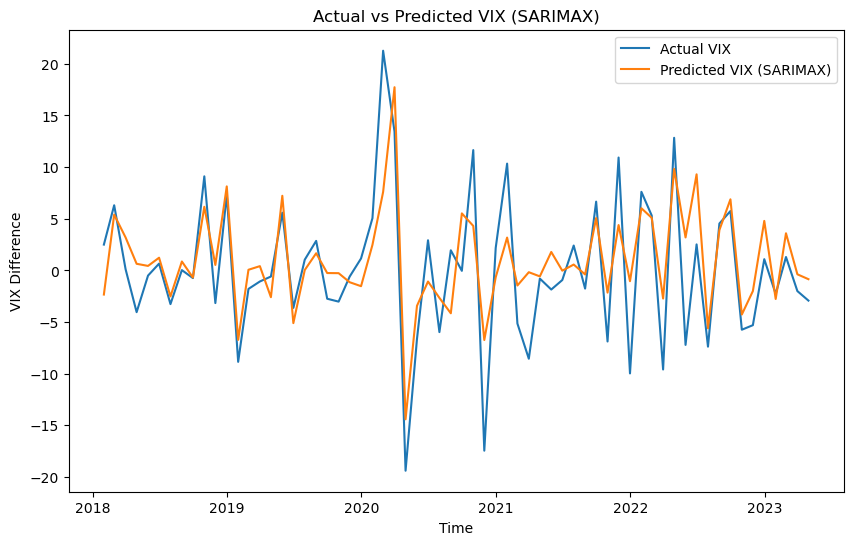

In [79]:
import matplotlib.pyplot as plt

# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_y_sarimax_NSA, label='Actual VIX')
plt.plot(forecast_SARIMAX_outsample_selected, label='Predicted VIX (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual vs Predicted VIX (SARIMAX)')
plt.legend()
plt.show()

In [80]:
# Checking Direction Accuracy
# Function to determine the direction of a dataset
def get_direction(data):
    direction = []
    for i in range(1, len(data)):
        if data.iloc[i, 0] > data.iloc[i-1, 0]:
            direction.append(1)  # Increasing
        elif data.iloc[i, 0] < data.iloc[i-1, 0]:
            direction.append(-1)  # Decreasing
        else:
            direction.append(0)  # No change
    return direction

# Determine directions of y_test and y_pred
y_test_direction = get_direction(pd.DataFrame(test_y_sarimax_NSA))
y_pred_direction = get_direction(pd.DataFrame(forecast_SARIMAX_outsample_selected))

# Compare the directions and count the number of matching cases
matching_count = sum(1 for i in range(len(y_test_direction)) if y_test_direction[i] == y_pred_direction[i])

# Print the results
print("Number of matching cases:", matching_count)
print("Percentage:", (matching_count/len(y_test_direction)))

Number of matching cases: 51
Percentage: 0.8095238095238095


# LSTM

In [81]:
# setting up the LSTM variables with the selected features
LSTM_features = ['CPI','10Y TSY', 'Mortgage Rate','OAS BBB Corp', 'SPX','VIX']
LSTM_data = combined_final_data[LSTM_features]

In [82]:
# Assuming 'LSTM_data' is your DataFrame containing the features and target ('VIX')
# Drop missing values if any
LSTM_data.dropna(inplace=True)

# Define the features and target variables
features = LSTM_data.drop(columns=['VIX'])
target = LSTM_data['VIX']

# Perform Min-Max scaling on the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, shuffle=False)

# Step 3: Reshape the data for LSTM input
# LSTM expects a 3D input: (samples, time steps, features)
# In this case, we will use 1 time step, assuming that each row represents one month's data
X_train = X_train[:, np.newaxis, :]
X_test = X_test[:, np.newaxis, :]

# define LSTM model architecture
model = Sequential()
model.add(LSTM(units=128,  return_sequences=True, input_shape=(X_train.shape[1], 5)))
model.add(LSTM(units=64,  return_sequences=True))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=32,  return_sequences=True))
model.add(LSTM(units=32,  return_sequences=True))
model.add(LSTM(units=32, ))
model.add(Dense(1))

# compile model
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# train model
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 5), y_train, epochs=100, batch_size=5)

# make predictions on test data
y_pred = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 5))

# calculate root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


Epoch 1/100
51/51 [==============================] - 10s 6ms/step - loss: 20.3920 - root_mean_squared_error: 4.5157
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 20.3883 - root_mean_squared_error: 4.5153
Epoch 3/100
51/51 [==============================] - 0s 7ms/step - loss: 20.3313 - root_mean_squared_error: 4.5090
Epoch 4/100
51/51 [==============================] - 0s 7ms/step - loss: 19.1156 - root_mean_squared_error: 4.3721
Epoch 5/100
51/51 [==============================] - 0s 7ms/step - loss: 16.8841 - root_mean_squared_error: 4.1090
Epoch 6/100
51/51 [==============================] - 0s 7ms/step - loss: 16.7602 - root_mean_squared_error: 4.0939
Epoch 7/100
51/51 [==============================] - 0s 7ms/step - loss: 16.3313 - root_mean_squared_error: 4.0412
Epoch 8/100
51/51 [==============================] - 0s 7ms/step - loss: 15.1547 - root_mean_squared_error: 3.8929
Epoch 9/100
51/51 [==============================] - 0s 7ms/step - loss: 14.977

Epoch 72/100
51/51 [==============================] - 0s 9ms/step - loss: 8.6823 - root_mean_squared_error: 2.9466
Epoch 73/100
51/51 [==============================] - 0s 9ms/step - loss: 8.4750 - root_mean_squared_error: 2.9112
Epoch 74/100
51/51 [==============================] - 0s 9ms/step - loss: 8.6374 - root_mean_squared_error: 2.9389
Epoch 75/100
51/51 [==============================] - 0s 9ms/step - loss: 8.3837 - root_mean_squared_error: 2.8955
Epoch 76/100
51/51 [==============================] - 0s 9ms/step - loss: 8.6408 - root_mean_squared_error: 2.9395
Epoch 77/100
51/51 [==============================] - 0s 9ms/step - loss: 8.5249 - root_mean_squared_error: 2.9197
Epoch 78/100
51/51 [==============================] - 0s 9ms/step - loss: 8.6905 - root_mean_squared_error: 2.9480
Epoch 79/100
51/51 [==============================] - 0s 9ms/step - loss: 8.2252 - root_mean_squared_error: 2.8680
Epoch 80/100
51/51 [==============================] - 0s 9ms/step - loss: 8.3030

In [83]:
# checking the R2 Score and RMSE
y_pred = pd.DataFrame(y_pred)
y_pred.index = y_test.index
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Out Sample Metrics of LSTM \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(y_test,y_pred))

Out Sample Metrics of LSTM 

RMSE: 4.640203272481003
R2_Score: 0.5510285690125509


### LSTM Plot

Text(0.5, 1.0, 'Actual VIX Difference vs Predicted VIX Difference (LSTM)')

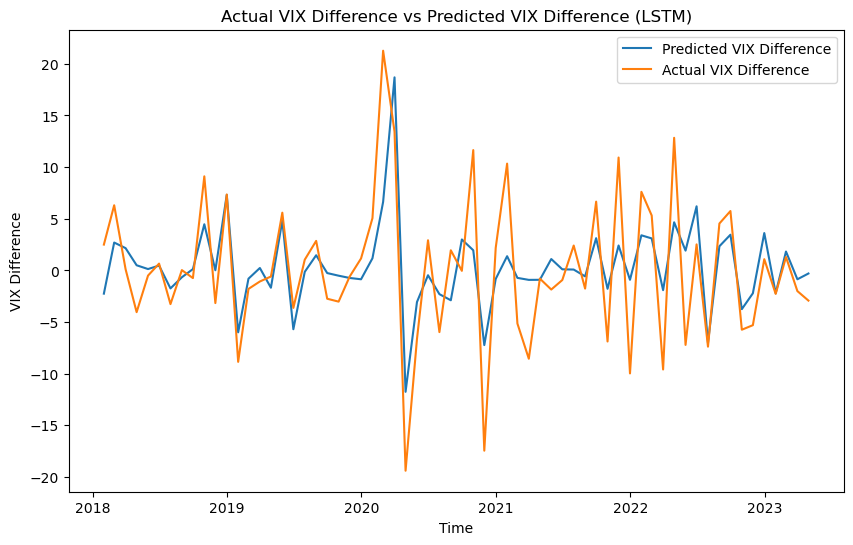

In [84]:
plt.figure(figsize = (10,6))
plt.plot(y_pred, label = 'Predicted VIX Difference')
plt.plot(y_test,label = 'Actual VIX Difference')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.legend()
plt.title('Actual VIX Difference vs Predicted VIX Difference (LSTM)')

In [85]:
# Checking Direction Accuracy
# Function to determine the direction of a dataset
def get_direction(data):
    direction = []
    for i in range(1, len(data)):
        if data.iloc[i, 0] > data.iloc[i-1, 0]:
            direction.append(1)  # Increasing
        elif data.iloc[i, 0] < data.iloc[i-1, 0]:
            direction.append(-1)  # Decreasing
        else:
            direction.append(0)  # No change
    return direction

# Determine directions of y_test and y_pred
y_test_direction = get_direction(pd.DataFrame(y_test))
y_pred_direction = get_direction(pd.DataFrame(y_pred))

# Compare the directions and count the number of matching cases
matching_count = sum(1 for i in range(len(y_test_direction)) if y_test_direction[i] == y_pred_direction[i])

# Print the results
print("Number of matching cases:", matching_count)
print("Percentage:", (matching_count/len(y_test_direction)))

Number of matching cases: 50
Percentage: 0.7936507936507936


## Random Forest

In [830]:
ss= StandardScaler()
#NSA
features = ['CPI','10Y TSY', 'Mortgage Rate','OAS BBB Corp', 'SPX']
scaled_xtrain = ss.fit_transform(train_X[features])
scaled_xtest = ss.transform(test_X[features])

In [831]:
params_grid = {'n_estimators':[16,32,64,128,256,512,1024],
               'criterion':['squared_error','friedman_mse','absolute_error'],
            #   'random_state':[0,11,42,3,45,59],
               'max_depth': [3,5,7]}
gridsearch_model = GridSearchCV(RandomForestRegressor(),params_grid, refit = True, verbose = 3, n_jobs = -1)
modelfit = gridsearch_model.fit(scaled_xtrain,train_Y)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [832]:
print(modelfit.best_params_)

{'criterion': 'absolute_error', 'max_depth': 5, 'n_estimators': 16}


In [89]:
predictions_in = modelfit.predict(train_X)
rmse = np.sqrt(mean_squared_error(train_Y, predictions_in))
print('In Sample Metrics of Random Forest (NSA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(train_Y,predictions_in))

In Sample Metrics of Random Forest (NSA) 

RMSE: 4.476036843698219
R2_Score: 0.017203339118681327


In [833]:
predictions_in = modelfit.predict(scaled_xtrain)
rmse = np.sqrt(mean_squared_error(train_Y, predictions_in))
print('In Sample Metrics of Random Forest (NSA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(train_Y,predictions_in))

In Sample Metrics of Random Forest (NSA) 

RMSE: 2.2976371191054663
R2_Score: 0.7410360895351241


In [834]:
predictions_out = modelfit.predict(scaled_xtest)
rmse = np.sqrt(mean_squared_error(test_Y, predictions_out))
print('Out Sample Metrics of Random Forest (NSA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(test_Y,predictions_out))

Out Sample Metrics of Random Forest (NSA) 

RMSE: 4.793089351575892
R2_Score: 0.5209556251022047


In [835]:
#SA
scaled_xtrain = ss.fit_transform(train_X_SA[features])
scaled_xtest = ss.transform(test_X_SA[features])

In [836]:
params_grid = {'n_estimators':[16,32,64,128,256,512,1024],
               'criterion':['squared_error','friedman_mse','absolute_error'],
            #   'random_state':[0,11,42,3,45,59],
               'max_depth': [3,5,7]}
gridsearch_model = GridSearchCV(RandomForestRegressor(),params_grid, refit = True, verbose = 3, n_jobs = -1)
modelfit = gridsearch_model.fit(scaled_xtrain,train_Y_SA)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [837]:
print(modelfit.best_params_)

{'criterion': 'absolute_error', 'max_depth': 7, 'n_estimators': 64}


In [838]:
predictions_in_sa = modelfit.predict(scaled_xtrain)
rmse = np.sqrt(mean_squared_error(train_Y_SA, predictions_in_sa))
print('In Sample Metrics of Random Forest (SA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(train_Y_SA,predictions_in_sa))

In Sample Metrics of Random Forest (SA) 

RMSE: 1.6740374610256448
R2_Score: 0.8567485533092741


In [839]:
predictions_out_sa = modelfit.predict(scaled_xtest)
rmse = np.sqrt(mean_squared_error(test_Y, predictions_out_sa))
print('Out Sample Metrics of Random Forest (SA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(test_Y_SA,predictions_out_sa))

Out Sample Metrics of Random Forest (SA) 

RMSE: 4.861564319255053
R2_Score: 0.531717084663506


In [921]:
mae_valueRF = mean_absolute_error(test_Y_SA, predictions_out_sa)
mae_valueRF

3.4616910555127722

In [923]:
mape_valueRF = np.mean(np.abs((test_Y_SA - predictions_out_sa) / test_Y_SA)) * 100
mape_valueRF

305.5844131754738

### Random Forest Plots

In [840]:
# In-sample adjustments
prediction_train = (pd.DataFrame(predictions_in))
y_train = (pd.DataFrame(train_Y))
prediction_train.index = y_train.index
# out-sample adjustments
prediction_test = (pd.DataFrame(predictions_out))
y_test = (pd.DataFrame(test_Y))
prediction_test.index = y_test.index

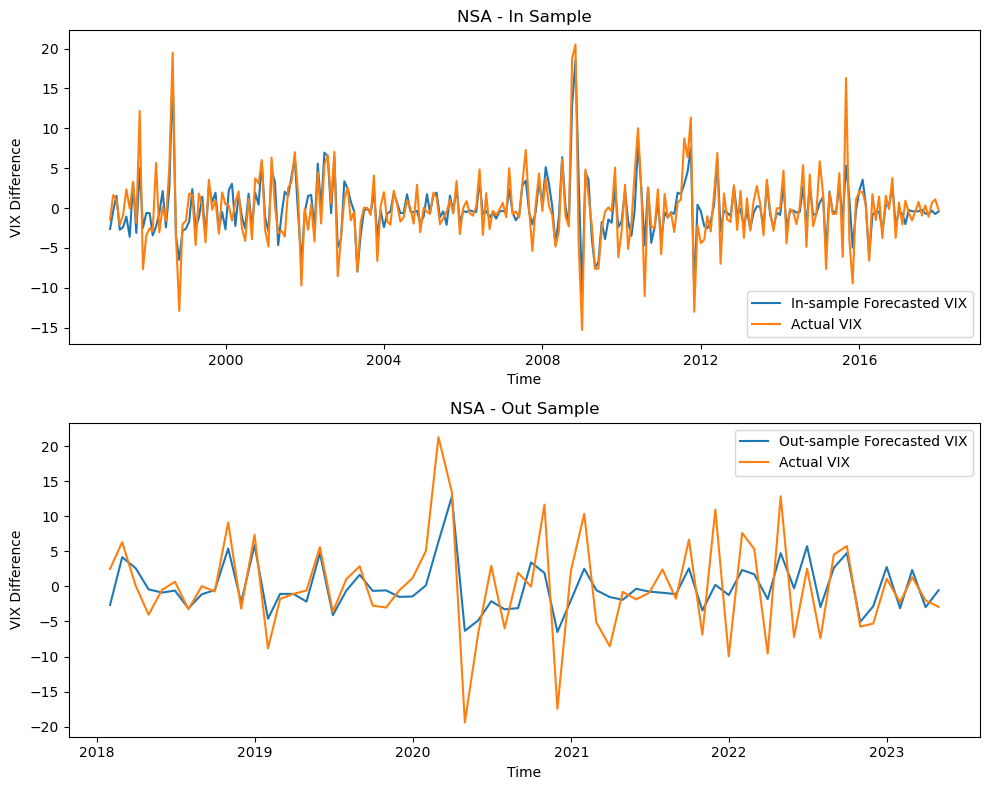

In [841]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary NSA In Sample 
axs[0].plot(prediction_train, label='In-sample Forecasted VIX')
axs[0].plot(train_Y, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('NSA - In Sample')
axs[0].legend()

# Second subplot - Stationary NSA Out Sample 
axs[1].plot(prediction_test, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('NSA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [842]:
# Checking Direction Accuracy
# Function to determine the direction of a dataset
def get_direction(data):
    direction = []
    for i in range(1, len(data)):
        if data.iloc[i, 0] > data.iloc[i-1, 0]:
            direction.append(1)  # Increasing
        elif data.iloc[i, 0] < data.iloc[i-1, 0]:
            direction.append(-1)  # Decreasing
        else:
            direction.append(0)  # No change
    return direction

# Determine directions of y_test and y_pred
y_test_direction = get_direction(pd.DataFrame(test_Y))
y_pred_direction = get_direction(pd.DataFrame(prediction_test))

# Compare the directions and count the number of matching cases
matching_count = sum(1 for i in range(len(y_test_direction)) if y_test_direction[i] == y_pred_direction[i])

# Print the results
print("Number of matching cases:", matching_count)
print("Percentage:", (matching_count/len(y_test_direction)))

Number of matching cases: 49
Percentage: 0.7777777777777778


In [843]:
# In-sample adjustments
prediction_sa_train = (pd.DataFrame(predictions_in_sa))
y_train = (pd.DataFrame(train_Y_SA))
prediction_sa_train.index = y_train.index
# Out-sample adjustments
prediction_sa_test = (pd.DataFrame(predictions_out_sa))
y_test = (pd.DataFrame(test_Y_SA))
prediction_sa_test.index = y_test.index

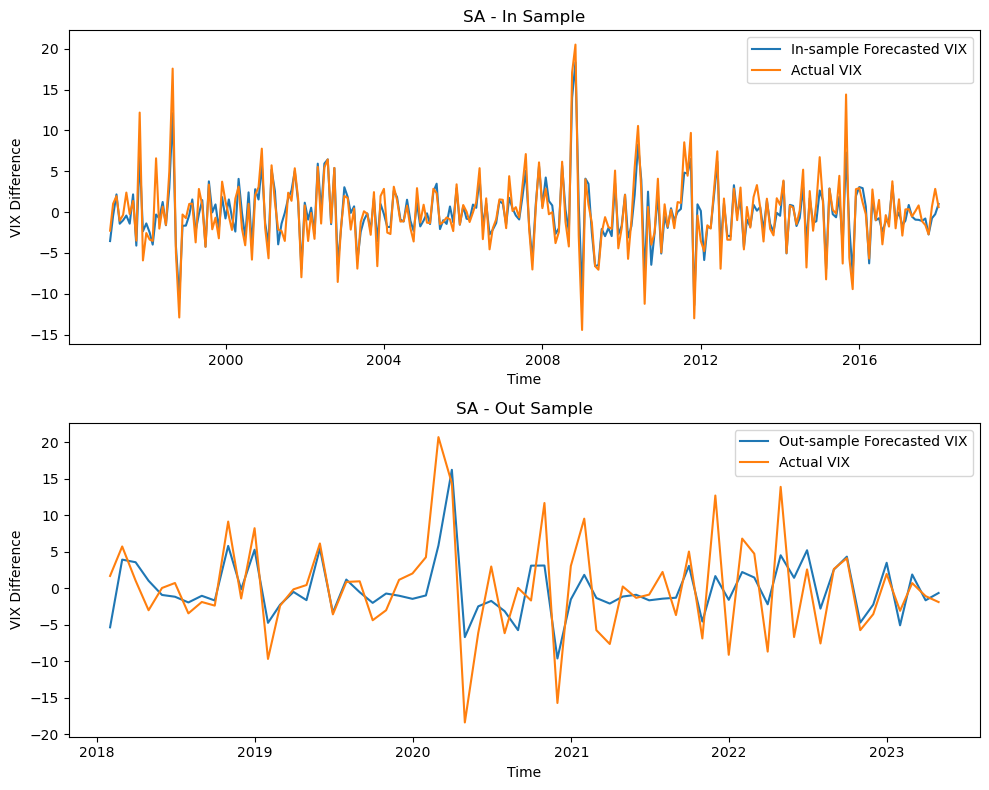

In [844]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary SA In Sample 
axs[0].plot(prediction_sa_train, label='In-sample Forecasted VIX')
axs[0].plot(train_Y_SA, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('SA - In Sample')
axs[0].legend()

# Second subplot - Stationary SA Out Sample 
axs[1].plot(prediction_sa_test, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y_SA, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('SA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## XGBoost

In [929]:
ss= StandardScaler()
#NSA
scaled_xtrain = ss.fit_transform(train_X[features])
scaled_xtest = ss.transform(test_X[features])

In [930]:
params_grid_xgb = {'n_estimators':[64,128,256,512],
               'learning_rate':[0.1,0.01,0.002,0.5,1,1.2],
               'gamma':[0.3,0.4,0.2,0],
               'max_depth': [3,5,7,None],
               'objective':['reg:squarederror','reg:squaredlogerror','reg:absoluteerror']}
gridsearch_model_xgb = GridSearchCV(xgb.XGBRegressor(),params_grid_xgb, refit = True, verbose = 3, n_jobs = -1)
modelfit_xgb = gridsearch_model_xgb.fit(scaled_xtrain,train_Y)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [931]:
print(modelfit_xgb.best_params_)

{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 512, 'objective': 'reg:absoluteerror'}


In [932]:
predictions_in = modelfit_xgb.predict(scaled_xtrain)
rmse = np.sqrt(mean_squared_error(train_Y, predictions_in))
print('In Sample Metrics of XGBoost (NSA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(train_Y,predictions_in))

In Sample Metrics of XGBoost (NSA) 

RMSE: 2.029476102902458
R2_Score: 0.7979567942885711


In [933]:
predictions_out = modelfit_xgb.predict(scaled_xtest)
rmse = np.sqrt(mean_squared_error(test_Y, predictions_out))
print('Out Sample Metrics of XGBoost (NSA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(test_Y,predictions_out))

Out Sample Metrics of XGBoost (NSA) 

RMSE: 5.439769942980257
R2_Score: 0.3829707375400845


In [934]:
#SA
scaled_xtrain = ss.fit_transform(train_X_SA[features])
scaled_xtest = ss.transform(test_X_SA[features])

In [935]:
params_grid_xgb = {'n_estimators':[64,128,256,512],
               'learning_rate':[0.1,0.01,0.002,0.5,1,1.2],
               'gamma':[0.3,0.4,0.2,0],
               'max_depth': [3,5,7,None],
               'objective':['reg:squarederror','reg:squaredlogerror','reg:absoluteerror']}
gridsearch_model_xgb = GridSearchCV(xgb.XGBRegressor(),params_grid_xgb, refit = True, verbose = 3, n_jobs = -1)
modelfit_xgb = gridsearch_model_xgb.fit(scaled_xtrain,train_Y_SA)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [936]:
print(modelfit_xgb.best_params_)

{'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 256, 'objective': 'reg:squarederror'}


In [937]:
predictions_in_sa11 = modelfit_xgb.predict(scaled_xtrain)
rmse = np.sqrt(mean_squared_error(train_Y_SA, predictions_in_sa))
print('In Sample Metrics of XGBoost (SA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(train_Y_SA,predictions_in_sa11))

In Sample Metrics of XGBoost (SA) 

RMSE: 2.3126464083933764
R2_Score: 0.7266071546050712


In [938]:
predictions_out_sa11 = modelfit_xgb.predict(scaled_xtest)
rmse = np.sqrt(mean_squared_error(test_Y, predictions_out_sa))
print('Out Sample Metrics of XGBoost (SA) \n')
print('RMSE:', rmse)
print('R2_Score:', r2_score(test_Y_SA,predictions_out_sa11))

Out Sample Metrics of XGBoost (SA) 

RMSE: 4.9635980209353505
R2_Score: 0.514282323870952


In [939]:
mae_valueXG = mean_absolute_error(test_Y_SA, predictions_out_sa11)
mae_valueXG

3.4616910555127722

In [940]:
mape_valueXG = np.mean(np.abs((test_Y_SA - predictions_out_sa11) / test_Y_SA)) * 100
mape_valueXG

305.5844131754738

### XGBoost Plots

In [855]:
# In-sample adjustments
prediction_train = (pd.DataFrame(predictions_in))
y_train = (pd.DataFrame(train_Y))
prediction_train.index = y_train.index
# out-sample adjustments
prediction_test = (pd.DataFrame(predictions_out))
y_test = (pd.DataFrame(test_Y))
prediction_test.index = y_test.index

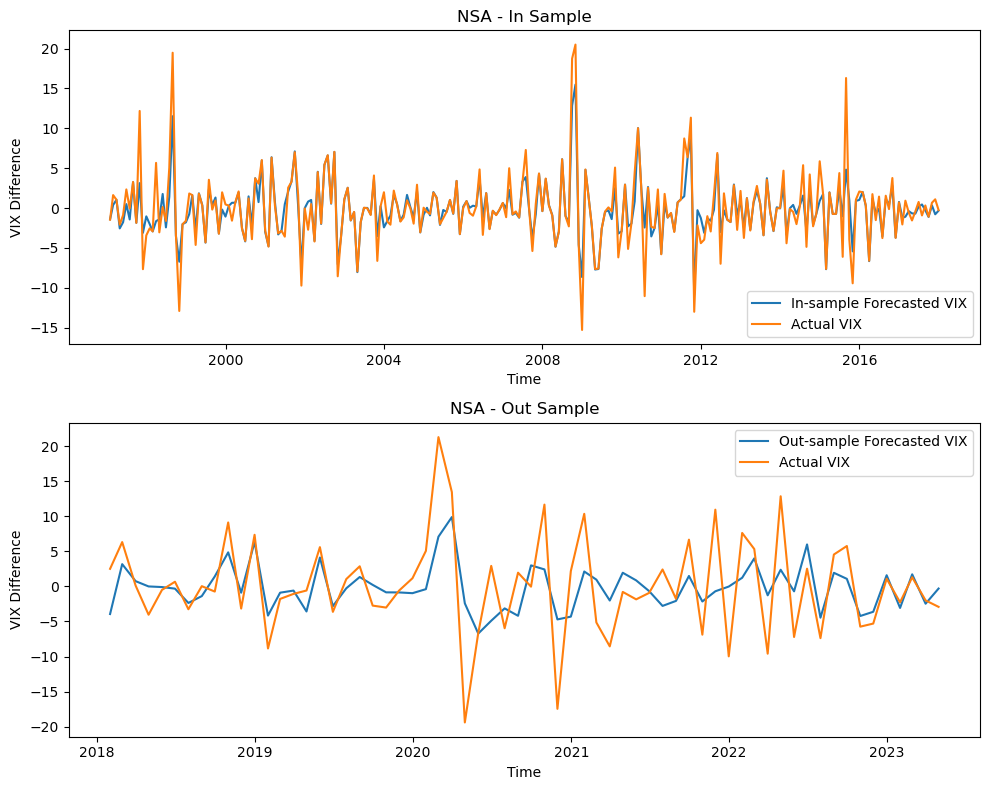

In [856]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary NSA In Sample 
axs[0].plot(prediction_train, label='In-sample Forecasted VIX')
axs[0].plot(train_Y, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('NSA - In Sample')
axs[0].legend()

# Second subplot - Stationary NSA Out Sample 
axs[1].plot(prediction_test, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('NSA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [858]:
# In-sample adjustments
prediction_sa_train = (pd.DataFrame(predictions_in_sa))
y_train = (pd.DataFrame(train_Y_SA))
prediction_sa_train.index = y_train.index
# Out-sample adjustments
prediction_sa_test = (pd.DataFrame(predictions_out_sa))
y_test = (pd.DataFrame(test_Y_SA))
prediction_sa_test.index = y_test.index

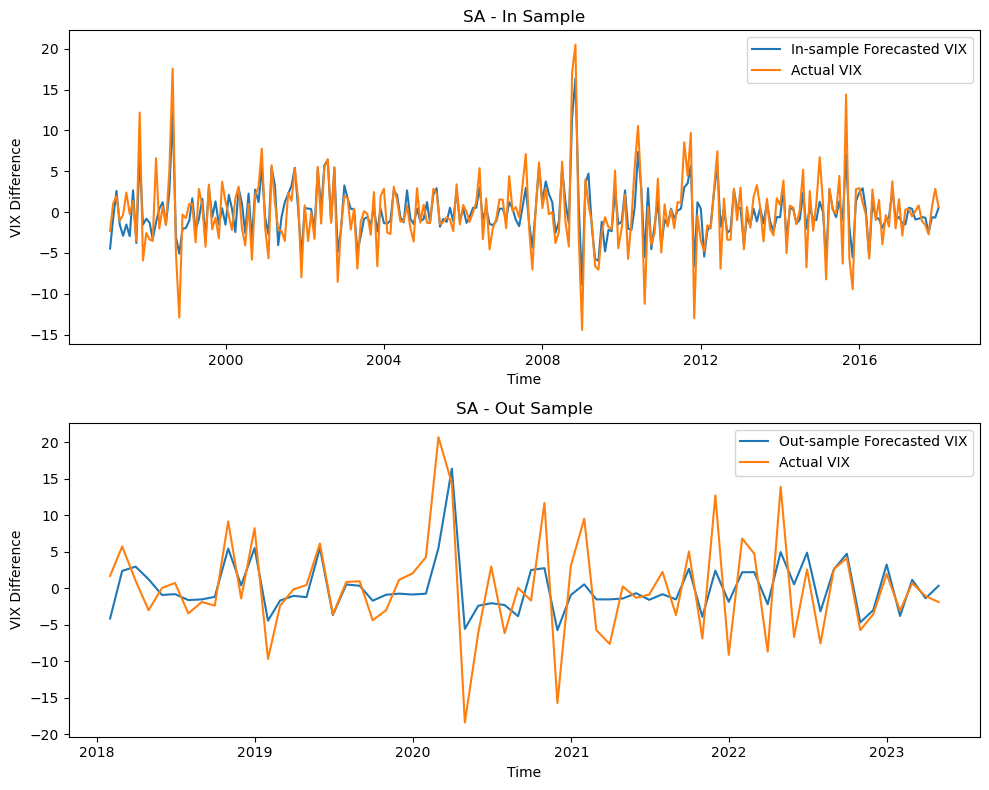

In [859]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# First subplot - Stationary SA In Sample 
axs[0].plot(prediction_sa_train, label='In-sample Forecasted VIX')
axs[0].plot(train_Y_SA, label='Actual VIX')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('VIX Difference')
axs[0].set_title('SA - In Sample')
axs[0].legend()

# Second subplot - Stationary SA Out Sample 
axs[1].plot(prediction_sa_test, label='Out-sample Forecasted VIX')
axs[1].plot(test_Y_SA, label='Actual VIX')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('VIX Difference')
axs[1].set_title('SA - Out Sample')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [860]:
# Checking Direction Accuracy
# Function to determine the direction of a dataset
def get_direction(data):
    direction = []
    for i in range(1, len(data)):
        if data.iloc[i, 0] > data.iloc[i-1, 0]:
            direction.append(1)  # Increasing
        elif data.iloc[i, 0] < data.iloc[i-1, 0]:
            direction.append(-1)  # Decreasing
        else:
            direction.append(0)  # No change
    return direction

# Determine directions of y_test and y_pred
y_test_direction = get_direction(pd.DataFrame(test_Y))
y_pred_direction = get_direction(pd.DataFrame(prediction_sa_test))

# Compare the directions and count the number of matching cases
matching_count = sum(1 for i in range(len(y_test_direction)) if y_test_direction[i] == y_pred_direction[i])

# Print the results
print("Number of matching cases:", matching_count)
print("Percentage:", (matching_count/len(y_test_direction)))

Number of matching cases: 48
Percentage: 0.7619047619047619


# MEAN REVERSION

In [160]:
beta_model_SA = combined_final_SA_data[['CPI','10Y TSY', 'Mortgage Rate','OAS BBB Corp', 'SPX','VIX']]
beta_model = combined_final_data[['CPI','10Y TSY', 'Mortgage Rate','OAS BBB Corp', 'SPX','VIX']]

In [161]:
beta_model.tail()

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp       SPX       VIX
2022-12-31  0.131280    -0.27          -0.16         -0.05 -5.897147  1.090000
2023-01-31  0.517074    -0.09          -0.29         -0.16  6.175286 -2.270000
2023-02-28  0.370006     0.22           0.37          0.04 -2.611249  1.300001
2023-03-31  0.053042    -0.09          -0.18          0.17  3.505161 -2.000000
2023-04-30  0.367783    -0.20           0.11         -0.03  1.464234 -2.920001

In [162]:
data = {
    'CPI': [0.2, 0.3],
    '10Y TSY': [0.11, 0.18],
    'Mortgage Rate': [0.14, 0.14],
    'OAS BBB Corp': [0.02, -0.15],
    'SPX': [0.248235, 6.472746],
    'VIX': [2.160001,-4.350000]
}
date_index = pd.date_range(start='2023-05-31', periods=len(data['CPI']), freq='M')
df = pd.DataFrame(data, index=date_index)

In [360]:
comprehensive_data = pd.concat([beta_model,df],axis=0)
comprehensive_data

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp       SPX       VIX
1997-01-31  0.188561     0.28           0.24         -0.01  6.131704 -1.450001
1997-02-28  0.188206    -0.16          -0.23         -0.03  0.592759  1.630001
1997-03-31  0.062617     0.27           0.32         -0.03 -4.261401  1.039999
1997-04-30  0.062578     0.20           0.11          0.03  5.840558 -2.080000
1997-05-31  0.000000    -0.18          -0.14          0.00  5.857688 -0.869999
...              ...      ...            ...           ...       ...       ...
2023-02-28  0.370006     0.22           0.37          0.04 -2.611249  1.300001
2023-03-31  0.053042    -0.09          -0.18          0.17  3.505161 -2.000000
2023-04-30  0.367783    -0.20           0.11         -0.03  1.464234 -2.920001
2023-05-31  0.200000     0.11           0.14          0.02  0.248235  2.160001
2023-06-30  0.300000     0.18           0.14         -0.15  6.472746 -4.350000

[318 rows x 6 columns]

In [362]:
data12 = {
    'CPI': [0.2, 0.3],
    '10Y TSY': [3.56, 3.74],
    'Mortgage Rate': [6.57, 6.71],
    'OAS BBB Corp': [1.76, 1.61],
    'SPX': [0.248235, 6.472746],
    'VIX': [17.94,13.59]
}
date_index12 = pd.date_range(start='2023-05-31', periods=len(data12['CPI']), freq='M')
df12 = pd.DataFrame(data12, index=date_index12)

In [795]:
mortgage_monthly11 =pd.DataFrame(mortgage_monthly)
bbb_corp11 = pd.DataFrame(bbb_corp)
CPI_monthly11 = (pd.DataFrame(CPI_monthly).resample('M').max()).pct_change()*100
tsy_10y_monthly11 = pd.DataFrame(tsy_10y_monthly)
SPX_monthly11 = pd.DataFrame(SPX_monthly).pct_change()*100
VIX_monthly11 = pd.DataFrame(VIX_monthly)
data = pd.concat([mortgage_monthly11,bbb_corp11,CPI_monthly11,tsy_10y_monthly11,SPX_monthly11,VIX_monthly11],axis = 1)
data1 = data.dropna()
data2 = pd.concat([data1,df12],axis=0)
final_model_data = data2.iloc[1:,:]
final_model_data

Mortgage Rate  OAS BBB Corp       CPI  10Y TSY       SPX  \
1997-01-31           7.88          0.82  0.188561     6.58  6.131704   
1997-02-28           7.65          0.79  0.188206     6.42  0.592759   
1997-03-31           7.97          0.76  0.062617     6.69 -4.261401   
1997-04-30           8.08          0.79  0.062578     6.89  5.840558   
1997-05-31           7.94          0.79  0.000000     6.71  5.857688   
...                   ...           ...       ...      ...       ...   
2023-02-28           6.50          1.60  0.370006     3.75 -2.611249   
2023-03-31           6.32          1.77  0.053042     3.66  3.505161   
2023-04-30           6.43          1.74  0.367783     3.46  1.464234   
2023-05-31           6.57          1.76  0.200000     3.56  0.248235   
2023-06-30           6.71          1.61  0.300000     3.74  6.472746   

                  VIX  
1997-01-31  19.469999  
1997-02-28  21.100000  
1997-03-31  22.139999  
1997-04-30  20.059999  
1997-05-31  19.190001  
...               ...  
2023-02-28  20.700001  
2023-03-31  18.700001  
2023-04-30  15.780000  
2023-05-31  17.940000  
2023-06-30  13.590000  

[318 rows x 6 columns]

### Mean Reversion Start

In [365]:
# Mean of all variables
CPI_mean = final_model_data['CPI'].mean()
TSY_10_mean = final_model_data['10Y TSY'].mean()
Mortgage_rate_mean = final_model_data['Mortgage Rate'].mean()
OAS_BBB_mean = final_model_data['OAS BBB Corp'].mean()
SPX_mean = final_model_data['SPX'].mean()

# Variance of all variables
CPI_std = np.std(final_model_data['CPI'])
TSY_10_std = np.std(final_model_data['10Y TSY'])
Mortgage_rate_std = np.std(final_model_data['Mortgage Rate'])
OAS_BBB_std = np.std(final_model_data['OAS BBB Corp'])
SPX_std = np.std(final_model_data['SPX'])

# Initial Value of all variables
CPI_initial_value = final_model_data['CPI'][-1]
TSY_10_initial_value = final_model_data['10Y TSY'][-1]
Mortgage_rate_initial_value = final_model_data['Mortgage Rate'][-1]
OAS_BBB_initial_value = final_model_data['OAS BBB Corp'][-1]
SPX_initial_value = final_model_data['SPX'][-1]

# Start Date for all variables
CPI_start_date = final_model_data['CPI'].index[-1]
TSY_10_start_date = final_model_data['10Y TSY'].index[-1]
Mortgage_rate_start_date = final_model_data['Mortgage Rate'].index[-1]
OAS_BBB_start_date = final_model_data['OAS BBB Corp'].index[-1]
SPX_start_date = final_model_data['SPX'].index[-1]


In [866]:
SPX_std

4.511505497409992

In [906]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import random
# from scipy.optimize import minimize

# def generate_mean_reverting_series(timesteps, dt, theta, mu, sigma, initial_value):
#     series = np.zeros(timesteps)
#     series[0] = initial_value
    
#     for t in range(1, timesteps):
        
#         drift = theta * (mu - series[t - 1]) * dt
#         randomness = sigma * np.sqrt(dt) * np.random.randn()
#         series[t] = series[t - 1] + drift + randomness
        
#     return series

# def ou_log_likelihood(params, data, dt):
#     theta, mu, sigma = params
#     n = len(data)
#     dx = np.diff(data)
#     drift = theta * (mu - data[:-1]) * dt
#     diff = dx - drift
#     log_likelihood = -0.5 * n * np.log(2 * np.pi) - n * np.log(sigma * np.sqrt(dt)) - 0.5 * np.sum((diff / sigma) ** 2)
#     return -log_likelihood  # We minimize the negative log-likelihood

# # Parameters for the mean-reverting series
# timesteps = 12  # number of periods to forecast + 1
# dt = 1

# # Define the variables and their characteristics (mean, std, initial_value, start_date)
# variables = [
#     {"name": "CPI", "mean": CPI_mean, "std": CPI_std, "initial_value": CPI_initial_value, "start_date": CPI_start_date},
#     {"name": "10Y TSY", "mean": TSY_10_mean, "std": TSY_10_std, "initial_value": TSY_10_initial_value, "start_date": TSY_10_start_date},
#     {"name": "Mortgage Rate", "mean": Mortgage_rate_mean, "std": Mortgage_rate_std, "initial_value": Mortgage_rate_initial_value, "start_date": Mortgage_rate_start_date},
#     {"name": "OAS BBB Corp", "mean": OAS_BBB_mean, "std": OAS_BBB_std, "initial_value": OAS_BBB_initial_value, "start_date": OAS_BBB_start_date},
#     {"name": "SPX", "mean": SPX_mean, "std": SPX_std, "initial_value": SPX_initial_value, "start_date": SPX_start_date}
# ]

# # Create an empty DataFrame to store forecasted values and best mean reversion levels
# forecasted_df = pd.DataFrame()
# # Monte Carlo Function
# def monte_carlo_mean_reversion(timesteps, dt, theta, mu, sigma, initial_value, num_paths):
#     mean_reversion_paths = np.zeros((num_paths, timesteps))
#     for i in range(num_paths):
#         time_series = generate_mean_reverting_series(timesteps, dt, theta, mu, sigma, initial_value)
#         mean_reversion_paths[i, :] = time_series
#     return mean_reversion_paths

# # Monte Carlo Parameters
# num_paths = 25 # You can adjust this to set the number of Monte Carlo paths to generate

# # Loop through each variable and generate Monte Carlo mean-reverting paths
# # ... (Existing code above)

# # Loop through each variable and generate Monte Carlo mean-reverting paths
# for variable_info in variables:
#     variable_name = variable_info["name"]
#     mean = variable_info["mean"]
#     std = variable_info["std"]
#     initial_value = variable_info["initial_value"]

#     best_theta = None
#     best_likelihood = float("-inf")
#     best_mean_reversion_rate = None  # To store the best mean reversion rate for the variable

#     mean_reversion_paths = np.zeros((num_paths, timesteps))
#     for mean_reversion_rate in np.linspace(0.00001, 0.001, 1000):
#         random.seed(10)
#         time_series = generate_mean_reverting_series(timesteps, dt, mean_reversion_rate, mean, std, initial_value)
#         result = minimize(ou_log_likelihood, [mean_reversion_rate, mean, std], args=(time_series, dt), method='L-BFGS-B')
#         theta_est, _, _ = result.x

#         # Check if this mean reversion rate has better likelihood
#         likelihood = -result.fun
#         if likelihood > best_likelihood:
#             best_likelihood = likelihood
#             best_theta = theta_est
#             best_mean_reversion_rate = mean_reversion_rate  # Update the best mean reversion rate

#         # Generate Monte Carlo paths for the best mean reversion rate
#         if mean_reversion_rate == best_mean_reversion_rate:
#             mean_reversion_paths = monte_carlo_mean_reversion(timesteps, dt, best_theta, mean, std, initial_value, num_paths)

#     # Calculate the average path of the mean reversion level
#     avg_mean_reversion_path = np.mean(mean_reversion_paths, axis=0)
#     start_dt = final_model_data[variable_name].index[-1]
#     forecast_data1 = pd.Series(avg_mean_reversion_path,index=pd.date_range(start=start_dt,periods=timesteps,freq = 'M'))
    
#     # Plot the average path of the mean reversion level
#     plt.figure(figsize=(10, 6))
#     plt.plot(final_model_data[variable_name])
#     plt.plot(forecast_data1)
#     plt.axhline(mean, color='red', linestyle='--', label='Mean')
#     plt.legend(['Average Mean Reversion Path', 'Mean'])
#     plt.xlabel("Time")
#     plt.ylabel("Mean Reversion Level")
#     plt.title(f"Average Mean Reversion Path of {variable_name}")
#     plt.grid(True)
#     plt.show()

#     # Store the best mean reversion rate and the corresponding forecasted values in the DataFrame
#     forecasted_df[f"{variable_name}_Best_MR"] = best_mean_reversion_rate
#     forecasted_df[f"{variable_name}_Best_Forecast"] = generate_mean_reverting_series(timesteps, dt, best_theta, mean, std, initial_value)

# # Display the forecasted dataframe
# print(forecasted_df)


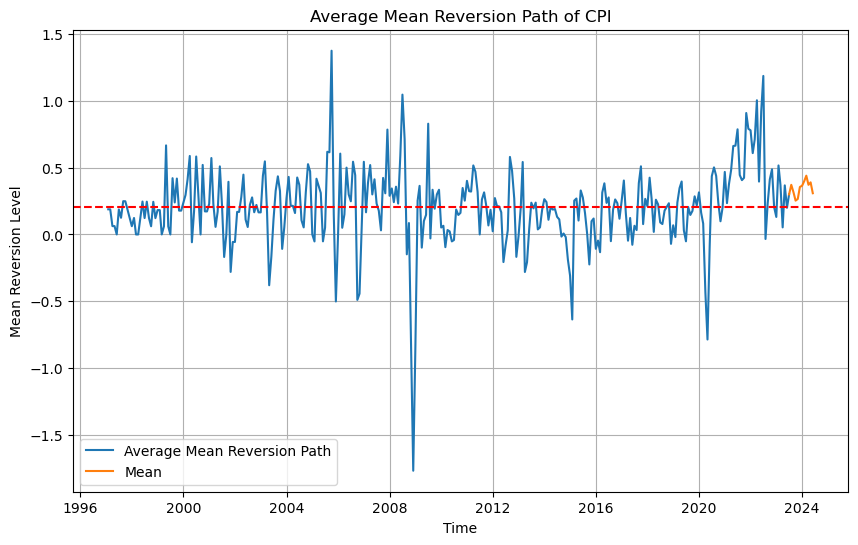

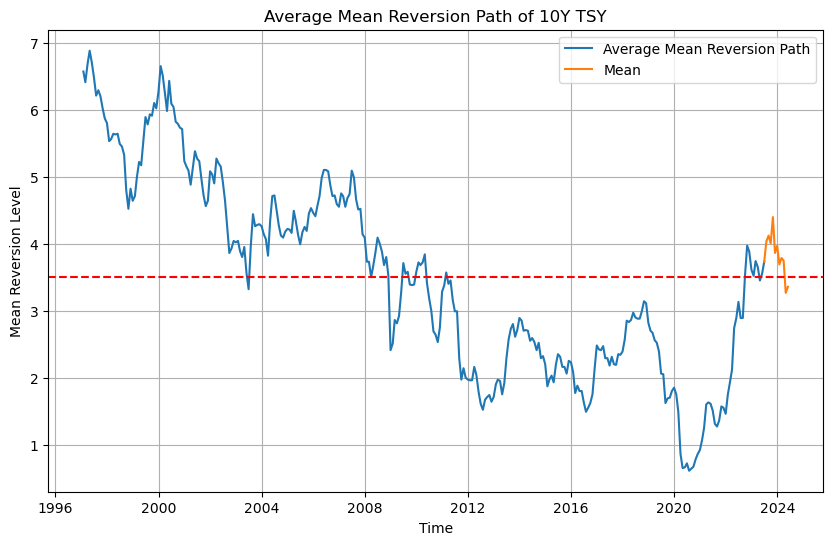

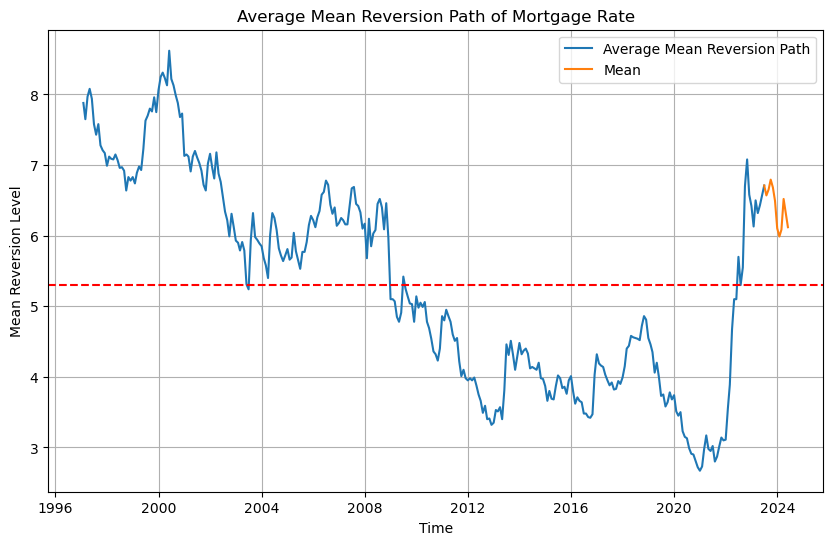

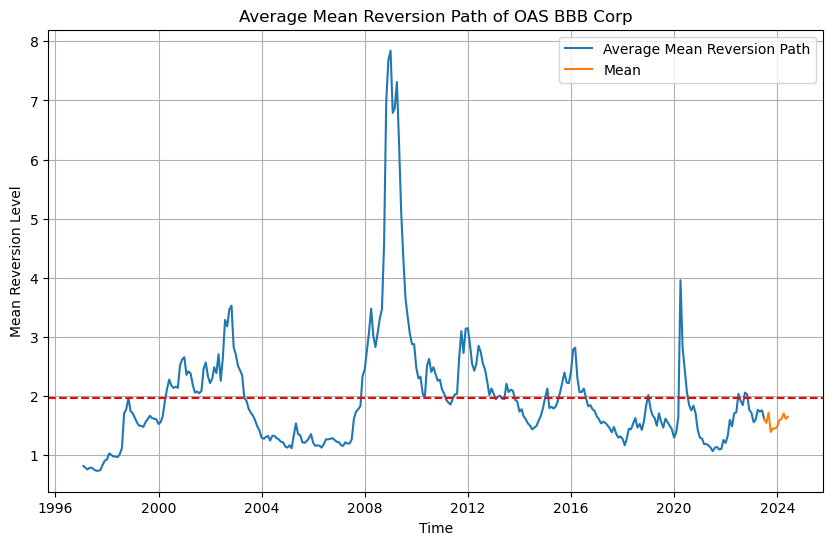

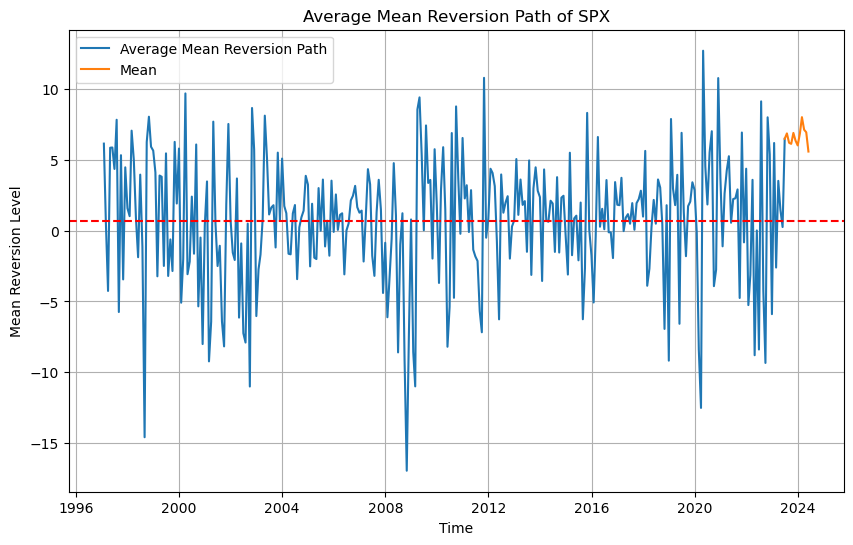

    CPI_Best_MR  CPI_Best_Forecast  10Y TSY_Best_MR  10Y TSY_Best_Forecast  \
0           NaN           0.300000         0.130909               3.740000   
1           NaN           0.150730         0.130909               3.766292   
2           NaN           0.209452         0.130909               2.944512   
3           NaN           0.219453         0.130909               3.172513   
4           NaN           0.695791         0.130909               5.680796   
5           NaN           0.467100         0.130909               4.313781   
6           NaN           0.590508         0.130909               4.537521   
7           NaN           0.478767         0.130909               4.515402   
8           NaN           0.915720         0.130909               3.854279   
9           NaN           0.978781         0.130909               4.508646   
10          NaN           1.293900         0.130909               4.460500   
11          NaN           0.867978         0.130909             

In [880]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize

def generate_mean_reverting_series(timesteps, dt, theta, mu, sigma, initial_value):
    series = np.zeros(timesteps)
    series[0] = initial_value
    
    for t in range(1, timesteps):
        
        drift = theta * (mu - series[t - 1]) * dt
        randomness = sigma * np.sqrt(dt) * np.random.randn()
        series[t] = series[t - 1] + drift + randomness
        
    return series

def ou_log_likelihood(params, data, dt):
    theta, mu, sigma = params
    n = len(data)
    dx = np.diff(data)
    drift = theta * (mu - data[:-1]) * dt
    diff = dx - drift
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - n * np.log(sigma * np.sqrt(dt)) - 0.5 * np.sum((diff / sigma) ** 2)
    return -log_likelihood  # We minimize the negative log-likelihood

# Parameters for the mean-reverting series
timesteps = 12  # number of periods to forecast + 1
dt = 1

# Define the variables and their characteristics (mean, std, initial_value, start_date)
variables = [
    {"name": "CPI", "mean": CPI_mean, "std": CPI_std, "initial_value": CPI_initial_value, "start_date": CPI_start_date},
    {"name": "10Y TSY", "mean": TSY_10_mean, "std": TSY_10_std, "initial_value": TSY_10_initial_value, "start_date": TSY_10_start_date},
    {"name": "Mortgage Rate", "mean": Mortgage_rate_mean, "std": Mortgage_rate_std, "initial_value": Mortgage_rate_initial_value, "start_date": Mortgage_rate_start_date},
    {"name": "OAS BBB Corp", "mean": OAS_BBB_mean, "std": OAS_BBB_std, "initial_value": OAS_BBB_initial_value, "start_date": OAS_BBB_start_date},
    {"name": "SPX", "mean": SPX_mean, "std": SPX_std, "initial_value": SPX_initial_value, "start_date": SPX_start_date}
]

# Create an empty DataFrame to store forecasted values and best mean reversion levels
forecasted_df = pd.DataFrame()
# Monte Carlo Function
def monte_carlo_mean_reversion(timesteps, dt, theta, mu, sigma, initial_value, num_paths):
    mean_reversion_paths = np.zeros((num_paths, timesteps))
    for i in range(num_paths):
        time_series = generate_mean_reverting_series(timesteps, dt, theta, mu, sigma, initial_value)
        mean_reversion_paths[i, :] = time_series
    return mean_reversion_paths

# Monte Carlo Parameters
num_paths = 25 # You can adjust this to set the number of Monte Carlo paths to generate

# Loop through each variable and generate Monte Carlo mean-reverting paths
# ... (Existing code above)
mean_reversion_speeds = {
    "CPI": 0.01,
    "10Y TSY": 0.002,
    "Mortgage Rate": 0.002,
    "OAS BBB Corp": 0.002,
    "SPX": 0.15
}

# Loop through each variable and generate Monte Carlo mean-reverting paths
for variable_info in variables:
    variable_name = variable_info["name"]
    mean = variable_info["mean"]
    std = variable_info["std"]
    initial_value = variable_info["initial_value"]
    
    # Get the mean reversion speed (theta) for this variable from the dictionary
    mean_reversion_speed = mean_reversion_speeds[variable_name]

    # Rest of the code remains unchanged...

    # Inside the loop where you generate mean_reversion_paths, update the theta parameter with mean_reversion_speed:
    for mean_reversion_rate in np.linspace(0.01, 0.2, 100):
        random.seed(10)
        time_series = generate_mean_reverting_series(timesteps, dt, mean_reversion_speed, mean, std, initial_value)
        result = minimize(ou_log_likelihood, [mean_reversion_speed, mean, std], args=(time_series, dt), method='L-BFGS-B')

    # Rest of the code remains unchanged...
        theta_est, _, _ = result.x

        # Check if this mean reversion rate has better likelihood
        likelihood = -result.fun
        if likelihood > best_likelihood:
            best_likelihood = likelihood
            best_theta = theta_est
            best_mean_reversion_rate = mean_reversion_rate  # Update the best mean reversion rate

        # Generate Monte Carlo paths for the best mean reversion rate
        if mean_reversion_rate == best_mean_reversion_rate:
            mean_reversion_paths = monte_carlo_mean_reversion(timesteps, dt, best_theta, mean, std, initial_value, num_paths)

    # Calculate the average path of the mean reversion level
    avg_mean_reversion_path = np.mean(mean_reversion_paths, axis=0)
    start_dt = final_model_data[variable_name].index[-1]
    forecast_data1 = pd.Series(avg_mean_reversion_path,index=pd.date_range(start=start_dt,periods=timesteps,freq = 'M'))
    
    # Plot the average path of the mean reversion level
    plt.figure(figsize=(10, 6))
    plt.plot(final_model_data[variable_name])
    plt.plot(forecast_data1)
    plt.axhline(mean, color='red', linestyle='--', label='Mean')
    plt.legend(['Average Mean Reversion Path', 'Mean'])
    plt.xlabel("Time")
    plt.ylabel("Mean Reversion Level")
    plt.title(f"Average Mean Reversion Path of {variable_name}")
    plt.grid(True)
    plt.show()

    # Store the best mean reversion rate and the corresponding forecasted values in the DataFrame
    forecasted_df[f"{variable_name}_Best_MR"] = best_mean_reversion_rate
    forecasted_df[f"{variable_name}_Best_Forecast"] = generate_mean_reverting_series(timesteps, dt, best_theta, mean, std, initial_value)

# Display the forecasted dataframe
print(forecasted_df)


In [881]:
CPI_predicted = forecasted_df['CPI_Best_Forecast']
TSY10_predicted = forecasted_df['10Y TSY_Best_Forecast'].diff().dropna()
BBB_predicted = forecasted_df['OAS BBB Corp_Best_Forecast'].diff().dropna()
Mortgage_predicted = forecasted_df['Mortgage Rate_Best_Forecast'].diff().dropna()
SPX_predicted = forecasted_df['SPX_Best_Forecast']

In [882]:
mean_reverted_data = pd.DataFrame([CPI_predicted,TSY10_predicted,Mortgage_predicted,BBB_predicted,SPX_predicted]).T.dropna()
mean_reverted_data.index = pd.date_range(start='2023-07-30',periods=11,freq = 'M') 

In [883]:
col_name = {'CPI_Best_Forecast':'CPI', '10Y TSY_Best_Forecast': '10Y TSY', 'Mortgage Rate_Best_Forecast': 'Mortgage Rate', 
            'OAS BBB Corp_Best_Forecast': 'OAS BBB Corp','SPX_Best_Forecast':'SPX'}

In [884]:
mean_reverted_data1 = rename_columns(mean_reverted_data,col_name)

In [885]:
final_analysis_data = pd.concat([comprehensive_data,mean_reverted_data1])
final_analysis_data.tail(13)

CPI   10Y TSY  Mortgage Rate  OAS BBB Corp        SPX  \
2023-05-31  0.200000  0.110000       0.140000      0.020000   0.248235   
2023-06-30  0.300000  0.180000       0.140000     -0.150000   6.472746   
2023-07-31  0.150730  0.026292      -0.933512      1.210562   2.967654   
2023-08-31  0.209452 -0.821780       1.454344     -1.085222  -3.124333   
2023-09-30  0.219453  0.228001      -0.254057      0.841413  -7.564774   
2023-10-31  0.695791  2.508283      -0.482768      0.681790  -6.447781   
2023-11-30  0.467100 -1.367015      -0.017571     -1.508919   1.561191   
2023-12-31  0.590508  0.223740      -1.734745     -1.002744   7.435881   
2024-01-31  0.478767 -0.022119       1.494933      0.884359  13.135712   
2024-02-29  0.915720 -0.661122      -0.807158     -2.789173  17.030781   
2024-03-31  0.978781  0.654367       0.956816     -1.185667  14.189263   
2024-04-30  1.293900 -0.048146       0.156444     -1.589891  19.152794   
2024-05-31  0.867978  0.062162       0.252959      0.138561  19.616168   

                 VIX  
2023-05-31  2.160001  
2023-06-30 -4.350000  
2023-07-31       NaN  
2023-08-31       NaN  
2023-09-30       NaN  
2023-10-31       NaN  
2023-11-30       NaN  
2023-12-31       NaN  
2024-01-31       NaN  
2024-02-29       NaN  
2024-03-31       NaN  
2024-04-30       NaN  
2024-05-31       NaN

In [886]:
testing_mean_reverting_data = final_analysis_data.iloc[-13:,:-1]
testing_mean_reverting_data

CPI   10Y TSY  Mortgage Rate  OAS BBB Corp        SPX
2023-05-31  0.200000  0.110000       0.140000      0.020000   0.248235
2023-06-30  0.300000  0.180000       0.140000     -0.150000   6.472746
2023-07-31  0.150730  0.026292      -0.933512      1.210562   2.967654
2023-08-31  0.209452 -0.821780       1.454344     -1.085222  -3.124333
2023-09-30  0.219453  0.228001      -0.254057      0.841413  -7.564774
2023-10-31  0.695791  2.508283      -0.482768      0.681790  -6.447781
2023-11-30  0.467100 -1.367015      -0.017571     -1.508919   1.561191
2023-12-31  0.590508  0.223740      -1.734745     -1.002744   7.435881
2024-01-31  0.478767 -0.022119       1.494933      0.884359  13.135712
2024-02-29  0.915720 -0.661122      -0.807158     -2.789173  17.030781
2024-03-31  0.978781  0.654367       0.956816     -1.185667  14.189263
2024-04-30  1.293900 -0.048146       0.156444     -1.589891  19.152794
2024-05-31  0.867978  0.062162       0.252959      0.138561  19.616168

#### Joining our previous test set and mean reverted set

1. train_X_SA[features_selected], test_X_SA[features_selected], train_Y_SA,test_Y_SA,ARIMAX_combined_SA[1]

In [887]:
final_train_X_features = train_X_SA[features_selected]
final_test_X_features = pd.concat([test_X_SA[features_selected],testing_mean_reverting_data],axis=0)

In [888]:
# Out-Sample RMSE,Prediction and Summary
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMAX_model_out_mean_reverting(train_x,test_x,train_y,order):
    model_ARIMAX = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
    results_ARIMAX = model_ARIMAX.fit()
    forecast_ARIMAX = results_ARIMAX.forecast(steps=len(test_x), exog=test_x)
    #rmse = np.sqrt(mean_squared_error(forecast_ARIMAX,test_y))
    summary = results_ARIMAX.summary()
    return forecast_ARIMAX,summary

In [889]:
test_Y_SA.shape

(64,)

In [890]:
# Stationary NSA 
final_forecast_ARIMAX_outsample_combined_SA,final_ARIMAX_summary_SA = ARIMAX_model_out_mean_reverting(final_train_X_features, final_test_X_features, train_Y_SA,ARIMAX_combined_SA[1])
print('ARIMAX Seasonally Adjusted')
#print('Out sample RMSE:',final_rmse_outsample_ARIMAX_combined_NSA)

ARIMAX Seasonally Adjusted


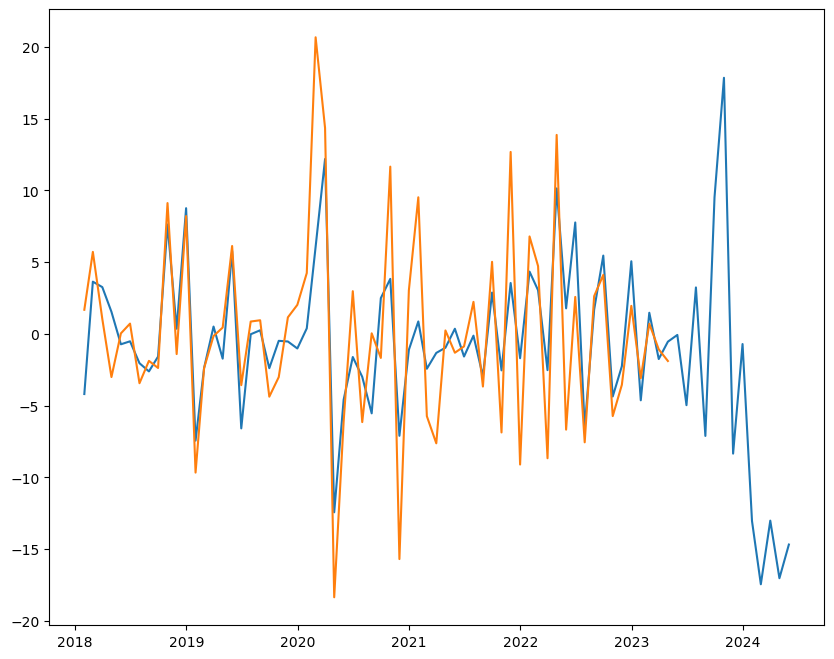

In [891]:
plt.figure(figsize=(10,8))
plt.plot(final_forecast_ARIMAX_outsample_combined_SA)
plt.plot(test_Y_SA)

### ARIMAX-GARCH (FORECASTING)

In [892]:
import arch
def ARIMAX_GARCH_FORECASTING(train_X_SA,test_X_SA,train_Y_SA):
    model1 = sm.tsa.ARIMA(train_Y_SA, order=(2,0,2),exog = train_X_SA)
    arima_results = model1.fit()
    arima_residuals = arima_results.resid
    arima_pred = arima_results.forecast(steps = len(test_X_SA),exog = test_X_SA)
    
    garch_model = arch.arch_model(arima_residuals, vol = 'Garch', p = 3, q = 3)
    results12 = garch_model.fit()
    garch_pred = results12.forecast(horizon = len(test_X_SA))
    garch_var = np.sqrt(garch_pred.variance.iloc[-1,:])
    garch_var.index = test_X_SA.index
    total12 = arima_pred + garch_var
    ARIMAX_GARCH_SUMMARY = results12.summary()
    
    return ARIMAX_GARCH_SUMMARY,total12

In [893]:
summary_forecasted, forecasted_ARIMAX_GARCH = ARIMAX_GARCH_FORECASTING(final_train_X_features,final_test_X_features,train_Y_SA)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 8105.33921686291
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2050.373636042681
Iteration:      3,   Func. Count:     30,   Neg. LLF: 739.8531103199621
Iteration:      4,   Func. Count:     41,   Neg. LLF: 690.9012774413333
Iteration:      5,   Func. Count:     52,   Neg. LLF: 632.5422439499148
Iteration:      6,   Func. Count:     62,   Neg. LLF: 608.6962410186549
Iteration:      7,   Func. Count:     72,   Neg. LLF: 606.9218182532817
Iteration:      8,   Func. Count:     81,   Neg. LLF: 607.9976283488708
Iteration:      9,   Func. Count:     91,   Neg. LLF: 606.7636360968577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 606.7621323263345
Iteration:     11,   Func. Count:    109,   Neg. LLF: 606.7621248355658
Iteration:     12,   Func. Count:    118,   Neg. LLF: 606.7621240682438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 606.7621240682438
            Iterations: 12
  

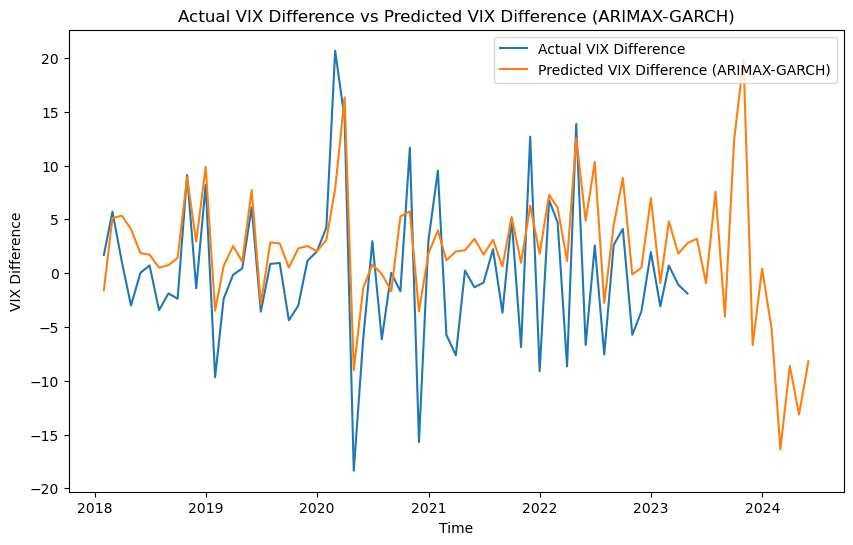

In [894]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_Y_SA, label='Actual VIX Difference')
plt.plot(forecasted_ARIMAX_GARCH, label='Predicted VIX Difference (ARIMAX-GARCH)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual VIX Difference vs Predicted VIX Difference (ARIMAX-GARCH)')
plt.legend()
plt.show()

### SARIMAX

In [895]:
def SARIMAX_model_out_FORECASTED(train_x, test_x, train_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_x), exog=test_x)
    #rmse = np.sqrt(mean_squared_error(forecast_SARIMAX, test_y))
    #r_squared = r2_score(test_y, forecast_SARIMAX)
    summary_table = results_SARIMAX.summary()
    return forecast_SARIMAX,summary_table

In [896]:
SARIMAX_features_test_X = pd.concat([test_x_sarimax_NSA,testing_mean_reverting_data],axis=0)

In [897]:
SARIMAX_FORECASTED, SUMMARY_SARIMAX = SARIMAX_model_out_FORECASTED(train_x_sarimax_NSA, SARIMAX_features_test_X, train_y_sarimax_NSA,(2,2,1),(2,0,2,12))

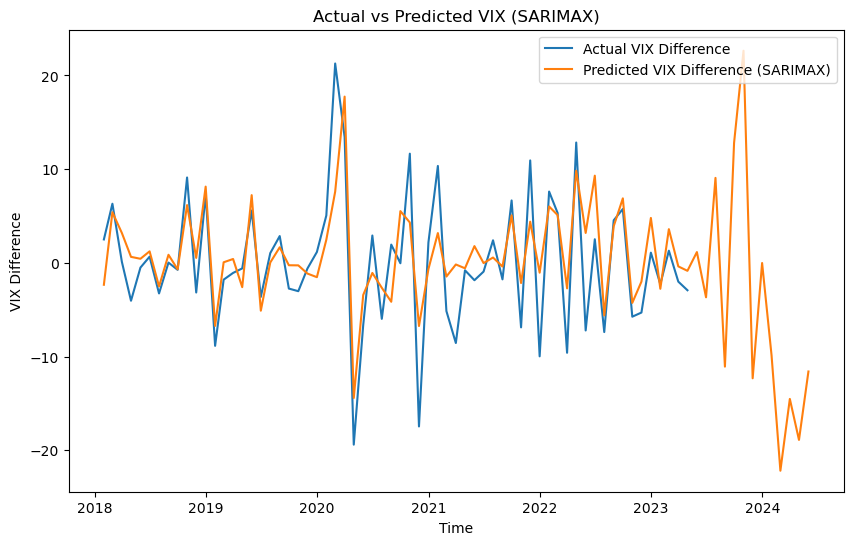

In [898]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_y_sarimax_NSA, label='Actual VIX Difference')
plt.plot(SARIMAX_FORECASTED, label='Predicted VIX Difference (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual vs Predicted VIX (SARIMAX)')
plt.legend()
plt.show()

In [899]:
sum(SARIMAX_FORECASTED.iloc[-15:])

-59.64917430769172

In [900]:
sum(final_forecast_ARIMAX_outsample_combined_SA.iloc[-15:])

-68.16159216399214

In [901]:
sum(forecasted_ARIMAX_GARCH.iloc[-15:])

-15.136666678086991

In [904]:
forecasted_ARIMAX_GARCH.iloc[-15:]

2023-03-31     1.815072
2023-04-30     2.789299
2023-05-31     3.199107
2023-06-30    -0.923929
2023-07-31     7.575868
2023-08-31    -4.031980
2023-09-30    12.340675
2023-10-31    19.839530
2023-11-30    -6.699253
2023-12-31     0.403933
2024-01-31    -5.138951
2024-02-29   -16.376534
2024-03-31    -8.606330
2024-04-30   -13.143273
2024-05-31    -8.179901
Freq: M, dtype: float64

# FORECASTS USING CCAR DATA

In [943]:
comprehensive_data

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp       SPX       VIX
1997-01-31  0.188561     0.28           0.24         -0.01  6.131704 -1.450001
1997-02-28  0.188206    -0.16          -0.23         -0.03  0.592759  1.630001
1997-03-31  0.062617     0.27           0.32         -0.03 -4.261401  1.039999
1997-04-30  0.062578     0.20           0.11          0.03  5.840558 -2.080000
1997-05-31  0.000000    -0.18          -0.14          0.00  5.857688 -0.869999
...              ...      ...            ...           ...       ...       ...
2023-02-28  0.370006     0.22           0.37          0.04 -2.611249  1.300001
2023-03-31  0.053042    -0.09          -0.18          0.17  3.505161 -2.000000
2023-04-30  0.367783    -0.20           0.11         -0.03  1.464234 -2.920001
2023-05-31  0.200000     0.11           0.14          0.02  0.248235  2.160001
2023-06-30  0.300000     0.18           0.14         -0.15  6.472746 -4.350000

[318 rows x 6 columns]

In [985]:
import pandas as pd

# Given data
data_base_case = {
    'CPI': [-0.3, -0.3, -0.2, -0.1, 0.1, -0.1, 0.1, 0, 0, 0, 0],
    '10Y TSY': [-0.04, -0.1, -0.1, -0.1, -0.1, 0, 0, 0, 0, -0.1, 0],
    'Mortgage Rate': [-4.81, 0, 0, 0, 0.1, -0.1, 0, 0, 0, 0.1, 0],
    'OAS BBB Corp': [0.3, 0, 0, 0, 0.1, -0.1, 0, 0, 0, 0.1, 0],
    'SPX': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'VIX': [27.2, 28.4, 28.5, 28.6, 28.4, 28.4, 28.5, 28.5, 28.5, 28.5, 28.4]
}


# Create a dataframe
df_base_case = pd.DataFrame(data_base_case)

# Add the time period as an index
df_base_case.index = ['Q3 2023', 'Q4 2023', 'Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024',
            'Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025', 'Q1 2026']

# Display the dataframe
df_base_case.head()

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp  SPX   VIX
Q3 2023 -0.3    -0.04          -4.81           0.3    0  27.2
Q4 2023 -0.3    -0.10           0.00           0.0    0  28.4
Q1 2024 -0.2    -0.10           0.00           0.0    0  28.5
Q2 2024 -0.1    -0.10           0.00           0.0    0  28.6
Q3 2024  0.1    -0.10           0.10           0.1    0  28.4

In [986]:
# Given data
data_severe_case = {
    'CPI': [-1.7, 0, 0.1, 0, 0, 0.1, 0, 0, 0.1, 0, 0],
    '10Y TSY': [-2.94, 0, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0.1, 0.1, 0],
    'Mortgage Rate': [3.8, 3.8, 3.8, 3.7, 3.5, 3.4, 3.3, 3.2, 3.1, 3.1, 3.1],
    'OAS BBB Corp': [4.09, 0.1, -0.3, -0.4, -0.4, -0.4, -0.5, -0.3, -0.4, -0.5, -0.3],
    'SPX': [-44.18109603, -1.469630732, 2.97838195, 4.331484622, 5.539934979, 6.560379636,
            7.387007305, 6.878865042, 9.652496511, 9.783654592, 8.911758885],
    'VIX': [65.4, 58, 52.1, 47.4, 43.6, 40.6, 38.2, 36.2, 34.7, 33.4, 32.4]
}


# Create a dataframe
df_severe_case = pd.DataFrame(data_severe_case)

# Add the time period as an index
df_severe_case.index = ['Q3 2023', 'Q4 2023', 'Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024',
            'Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025', 'Q1 2026']

# Display the dataframe
df_severe_case.head()

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp        SPX   VIX
Q3 2023 -1.7    -2.94            3.8          4.09 -44.181096  65.4
Q4 2023  0.0     0.00            3.8          0.10  -1.469631  58.0
Q1 2024  0.1     0.10            3.8         -0.30   2.978382  52.1
Q2 2024  0.0     0.10            3.7         -0.40   4.331485  47.4
Q3 2024  0.0     0.10            3.5         -0.40   5.539935  43.6

In [987]:
# Converted Quarter data into monthly data for comparison
df_base_case.index = mean_reverted_data1.index
df_severe_case.index = mean_reverted_data1.index

In [988]:
ccar_assumed_dataset_base = pd.concat([comprehensive_data,df_base_case],axis=0)
ccar_assumed_dataset_base.tail(11)

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp  SPX   VIX
2023-07-31 -0.3    -0.04          -4.81           0.3  0.0  27.2
2023-08-31 -0.3    -0.10           0.00           0.0  0.0  28.4
2023-09-30 -0.2    -0.10           0.00           0.0  0.0  28.5
2023-10-31 -0.1    -0.10           0.00           0.0  0.0  28.6
2023-11-30  0.1    -0.10           0.10           0.1  0.0  28.4
2023-12-31 -0.1     0.00          -0.10          -0.1  0.0  28.4
2024-01-31  0.1     0.00           0.00           0.0  0.0  28.5
2024-02-29  0.0     0.00           0.00           0.0  0.0  28.5
2024-03-31  0.0     0.00           0.00           0.0  0.0  28.5
2024-04-30  0.0    -0.10           0.10           0.1  0.0  28.5
2024-05-31  0.0     0.00           0.00           0.0  0.0  28.4

In [989]:
ccar_assumed_dataset_severe = pd.concat([comprehensive_data,df_severe_case],axis=0)
ccar_assumed_dataset_severe.tail(11)

CPI  10Y TSY  Mortgage Rate  OAS BBB Corp        SPX   VIX
2023-07-31 -1.7    -2.94            3.8          4.09 -44.181096  65.4
2023-08-31  0.0     0.00            3.8          0.10  -1.469631  58.0
2023-09-30  0.1     0.10            3.8         -0.30   2.978382  52.1
2023-10-31  0.0     0.10            3.7         -0.40   4.331485  47.4
2023-11-30  0.0     0.10            3.5         -0.40   5.539935  43.6
2023-12-31  0.1     0.10            3.4         -0.40   6.560380  40.6
2024-01-31  0.0     0.10            3.3         -0.50   7.387007  38.2
2024-02-29  0.0     0.00            3.2         -0.30   6.878865  36.2
2024-03-31  0.1     0.10            3.1         -0.40   9.652497  34.7
2024-04-30  0.0     0.10            3.1         -0.50   9.783655  33.4
2024-05-31  0.0     0.00            3.1         -0.30   8.911759  32.4

### USING THE ABOVE IN MODELS

In [990]:
final_train_X_features_ccar = train_X_SA[features_selected]
final_test_X_features_base = pd.concat([test_X_SA[features_selected],ccar_assumed_dataset_base.iloc[-13:,:-1]],axis=0)
final_test_X_features_severe = pd.concat([test_X_SA[features_selected],ccar_assumed_dataset_severe.iloc[-13:,:-1]],axis=0)

In [991]:
# Out-Sample RMSE,Prediction and Summary
# Function inputs - (p_range,d_range,q_range,train_x,test_x,train_y,test_y)
def ARIMAX_model_out_ccar(train_x,test_x,train_y,order):
    model_ARIMAX = sm.tsa.ARIMA(train_y, order=order, exog=train_x)
    results_ARIMAX = model_ARIMAX.fit()
    forecast_ARIMAX = results_ARIMAX.forecast(steps=len(test_x), exog=test_x)
    #rmse = np.sqrt(mean_squared_error(forecast_ARIMAX,test_y))
    summary = results_ARIMAX.summary()
    return forecast_ARIMAX,summary

In [1007]:
# BASE CASE
BASE_final_forecast_ARIMAX_outsample_combined_SA,BASE_final_ARIMAX_summary_SA = ARIMAX_model_out_ccar(final_train_X_features_ccar, final_test_X_features_base, train_Y_SA,ARIMAX_combined_SA[1])
print('ARIMAX Seasonally Adjusted')

ARIMAX Seasonally Adjusted


In [1008]:
# SEVERE CASE
SEVERE_final_forecast_ARIMAX_outsample_combined_SA,SEVERE_final_ARIMAX_summary_SA = ARIMAX_model_out_ccar(final_train_X_features_ccar, final_test_X_features_severe, train_Y_SA,ARIMAX_combined_SA[1])
print('ARIMAX Seasonally Adjusted')

ARIMAX Seasonally Adjusted


#### BASECASE PLOT

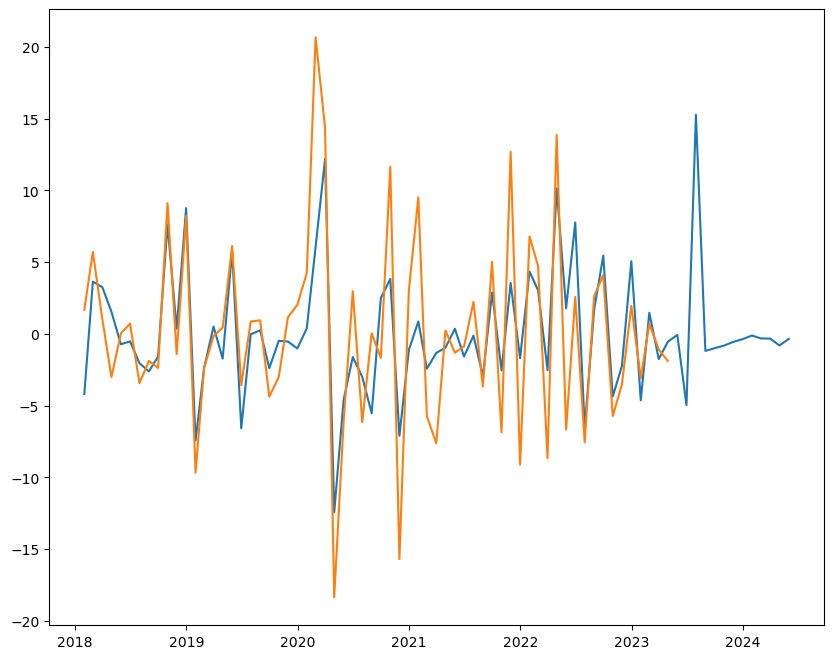

In [1009]:
plt.figure(figsize=(10,8))
plt.plot(BASE_final_forecast_ARIMAX_outsample_combined_SA)
plt.plot(test_Y_SA)

#### SEVER CASE PLOT

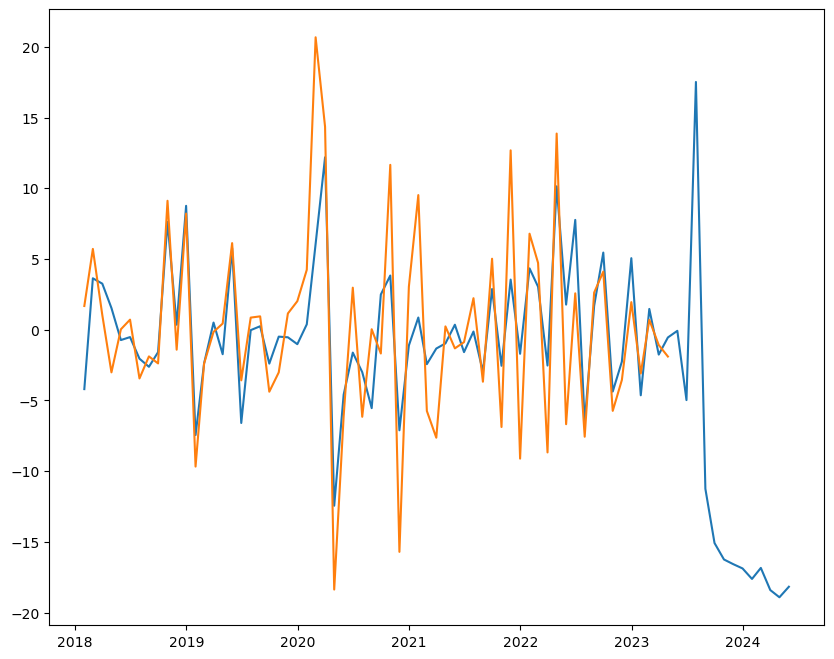

In [1010]:
plt.figure(figsize=(10,8))
plt.plot(SEVERE_final_forecast_ARIMAX_outsample_combined_SA)
plt.plot(test_Y_SA)

##### ARIMAX-GARCH

In [1038]:
import arch
def ARIMAX_GARCH_FORECASTING_CCAR(train_X_SA,test_X_SA,train_Y_SA):
    model1 = sm.tsa.ARIMA(train_Y_SA, order=(2,0,2),exog = train_X_SA)
    arima_results = model1.fit()
    arima_residuals = arima_results.resid
    arima_pred = arima_results.forecast(steps = len(test_X_SA),exog = test_X_SA)
    
    garch_model = arch.arch_model(arima_residuals, vol = 'Garch', p = 3, q = 3)
    results12 = garch_model.fit()
    garch_pred = results12.forecast(horizon = len(test_X_SA))
    garch_var = np.sqrt(garch_pred.variance.iloc[-1,:])
    garch_var.index = test_X_SA.index
    total12 = arima_pred + garch_var
    ARIMAX_GARCH_SUMMARY = results12.summary()
    
    return ARIMAX_GARCH_SUMMARY,total12

final_train_X_features_ccar,
final_test_X_features_base,
final_test_X_features_severe

In [1043]:
Base_summary_forecasted, Base_forecasted_ARIMAX_GARCH = ARIMAX_GARCH_FORECASTING_CCAR(final_train_X_features_ccar,final_test_X_features_base,train_Y_SA)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 8105.33921686291
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2050.373636042681
Iteration:      3,   Func. Count:     30,   Neg. LLF: 739.8531103199621
Iteration:      4,   Func. Count:     41,   Neg. LLF: 690.9012774413333
Iteration:      5,   Func. Count:     52,   Neg. LLF: 632.5422439499148
Iteration:      6,   Func. Count:     62,   Neg. LLF: 608.6962410186549
Iteration:      7,   Func. Count:     72,   Neg. LLF: 606.9218182532817
Iteration:      8,   Func. Count:     81,   Neg. LLF: 607.9976283488708
Iteration:      9,   Func. Count:     91,   Neg. LLF: 606.7636360968577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 606.7621323263345
Iteration:     11,   Func. Count:    109,   Neg. LLF: 606.7621248355658
Iteration:     12,   Func. Count:    118,   Neg. LLF: 606.7621240682438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 606.7621240682438
            Iterations: 12
  

In [1044]:
Severe_summary_forecasted, Severe_forecasted_ARIMAX_GARCH = ARIMAX_GARCH_FORECASTING_CCAR(final_train_X_features_ccar,final_test_X_features_severe,train_Y_SA)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 8105.33921686291
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2050.373636042681
Iteration:      3,   Func. Count:     30,   Neg. LLF: 739.8531103199621
Iteration:      4,   Func. Count:     41,   Neg. LLF: 690.9012774413333
Iteration:      5,   Func. Count:     52,   Neg. LLF: 632.5422439499148
Iteration:      6,   Func. Count:     62,   Neg. LLF: 608.6962410186549
Iteration:      7,   Func. Count:     72,   Neg. LLF: 606.9218182532817
Iteration:      8,   Func. Count:     81,   Neg. LLF: 607.9976283488708
Iteration:      9,   Func. Count:     91,   Neg. LLF: 606.7636360968577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 606.7621323263345
Iteration:     11,   Func. Count:    109,   Neg. LLF: 606.7621248355658
Iteration:     12,   Func. Count:    118,   Neg. LLF: 606.7621240682438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 606.7621240682438
            Iterations: 12
  

###### PLOTTING BASE AND SEVERE

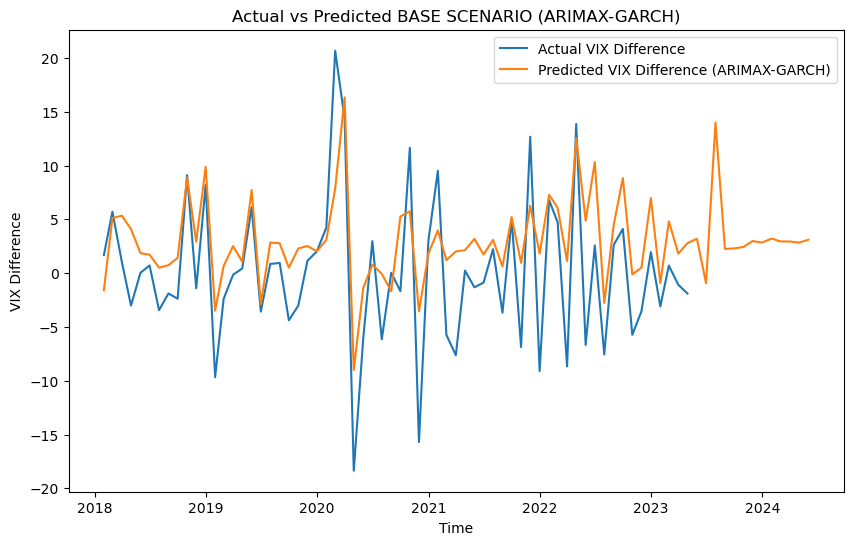

In [1054]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_Y_SA, label='Actual VIX Difference')
plt.plot(Base_forecasted_ARIMAX_GARCH, label='Predicted VIX Difference (ARIMAX-GARCH)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual vs Predicted BASE SCENARIO (ARIMAX-GARCH)')
plt.legend()
plt.show()

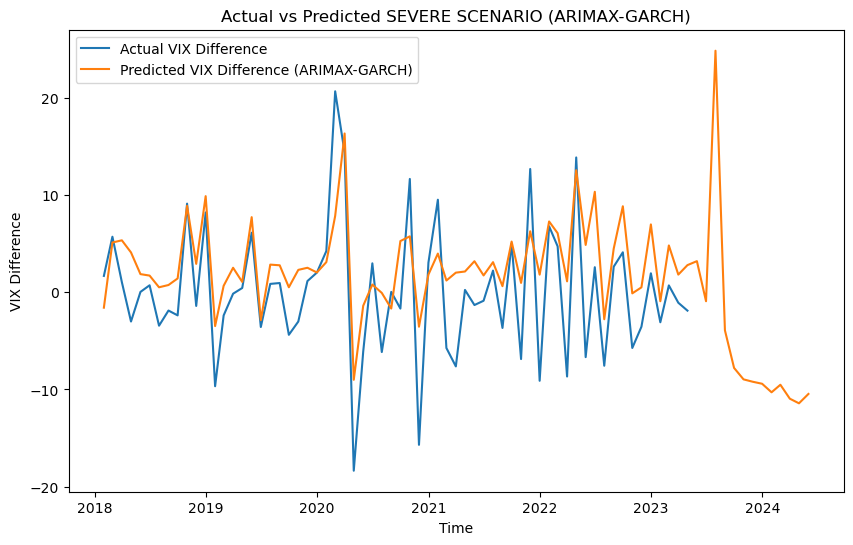

In [1055]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_Y_SA, label='Actual VIX Difference')
plt.plot(Severe_forecasted_ARIMAX_GARCH, label='Predicted VIX Difference (ARIMAX-GARCH)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual vs Predicted SEVERE SCENARIO (ARIMAX-GARCH)')
plt.legend()
plt.show()

##### SARIMAX

In [1051]:
def SARIMAX_model_out_FORECASTED_CCAR(train_x, test_x, train_y, order, seasonal_order):
    model_SARIMAX = sm.tsa.SARIMAX(train_y, exog=train_x, order=order, seasonal_order=seasonal_order)
    results_SARIMAX = model_SARIMAX.fit()
    forecast_SARIMAX = results_SARIMAX.forecast(steps=len(test_x), exog=test_x)
    #rmse = np.sqrt(mean_squared_error(forecast_SARIMAX, test_y))
    #r_squared = r2_score(test_y, forecast_SARIMAX)
    summary_table = results_SARIMAX.summary()
    return forecast_SARIMAX,summary_table

In [1052]:
BASE_SARIMAX_features_test_X = pd.concat([test_x_sarimax_NSA,ccar_assumed_dataset_base.iloc[-13:,:-1]],axis=0)
SEVERE_SARIMAX_features_test_X = pd.concat([test_x_sarimax_NSA,ccar_assumed_dataset_severe.iloc[-13:,:-1]],axis=0)

In [1053]:
BASE_SARIMAX_FORECASTED, BASE_SUMMARY_SARIMAX = SARIMAX_model_out_FORECASTED_CCAR(train_x_sarimax_NSA, BASE_SARIMAX_features_test_X, train_y_sarimax_NSA,(2,2,1),(2,0,2,12))
SEVERE_SARIMAX_FORECASTED, SEVERE_SUMMARY_SARIMAX = SARIMAX_model_out_FORECASTED_CCAR(train_x_sarimax_NSA, SEVERE_SARIMAX_features_test_X, train_y_sarimax_NSA,(2,2,1),(2,0,2,12))

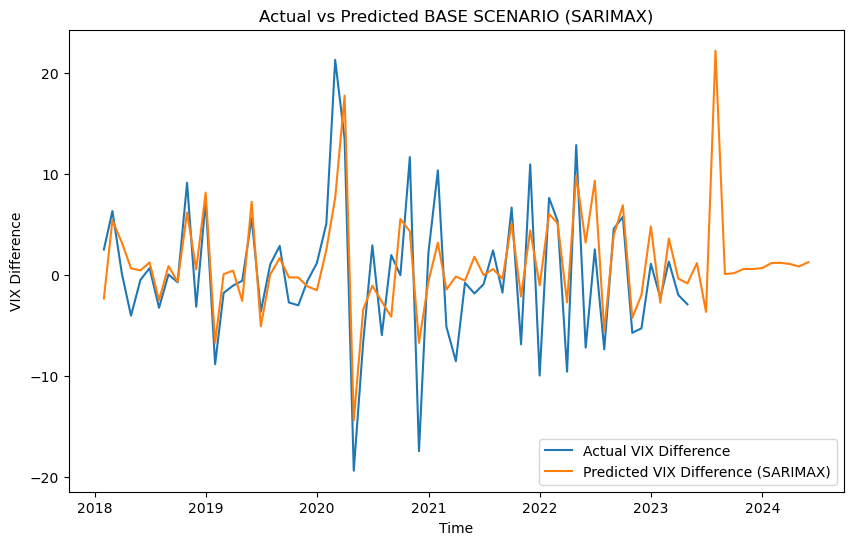

In [1056]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_y_sarimax_NSA, label='Actual VIX Difference')
plt.plot(BASE_SARIMAX_FORECASTED, label='Predicted VIX Difference (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual vs Predicted BASE SCENARIO (SARIMAX)')
plt.legend()
plt.show()

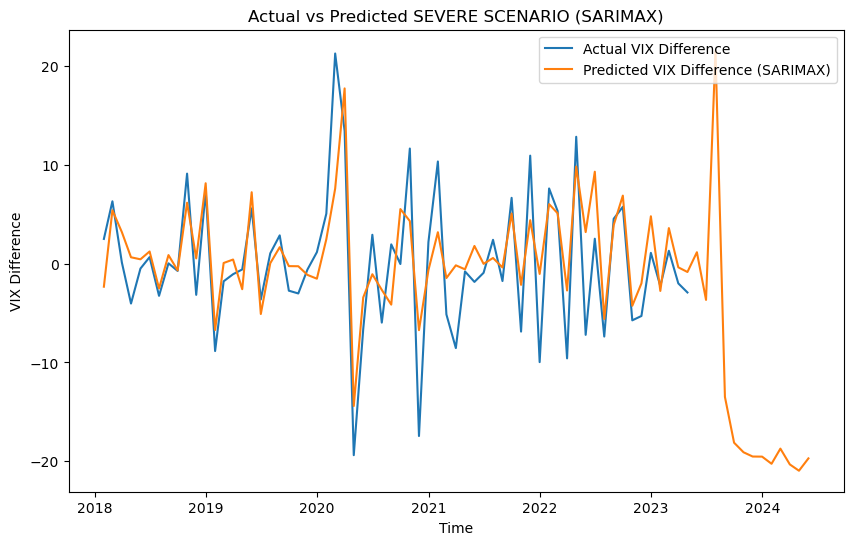

In [1057]:
# Plotting the variables
plt.figure(figsize=(10, 6))
plt.plot(test_y_sarimax_NSA, label='Actual VIX Difference')
plt.plot(SEVERE_SARIMAX_FORECASTED, label='Predicted VIX Difference (SARIMAX)')
plt.xlabel('Time')
plt.ylabel('VIX Difference')
plt.title('Actual vs Predicted SEVERE SCENARIO (SARIMAX)')
plt.legend()
plt.show()

## CONVERTING BACK TO ORIGINAL VALUES

In [1058]:
import pandas as pd

# Given data
base = {
    'CPI': [2.7, 2.4, 2.2, 2.1, 2.2, 2.1, 2.2, 2.2, 2.2, 2.2, 2.2],
    '10Y TSY': [3.7, 3.6, 3.5, 3.4, 3.3, 3.3, 3.3, 3.3, 3.3, 3.2, 3.2],
    'Mortgage Rate': [1.9, 1.9, 1.9, 1.9, 2.0, 1.9, 1.9, 1.9, 1.9, 2.0, 2.0],
    'OAS BBB Corp': [1.9, 1.9, 1.9, 1.9, 2.0, 1.9, 1.9, 1.9, 1.9, 2.0, 2.0],
    'SPX': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'VIX': [27.2, 28.4, 28.5, 28.6, 28.4, 28.4, 28.5, 28.5, 28.5, 28.5, 28.4]
}

# Create a dataframe
base_original_values= pd.DataFrame(base)

# Add the time period as an index
base_original_values.index = ['Q3 2023', 'Q4 2023', 'Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024',
            'Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025', 'Q1 2026']



# Given data
severe = {
    'CPI': [1.3, 1.3, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5, 1.6, 1.6, 1.6],
    '10Y TSY': [0.8, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.3, 1.4, 1.5, 1.5],
    'Mortgage Rate': [3.8, 3.8, 3.8, 3.7, 3.5, 3.4, 3.3, 3.2, 3.1, 3.1, 3.1],
    'OAS BBB Corp': [5.7, 5.8, 5.5, 5.1, 4.7, 4.3, 3.8, 3.5, 3.1, 2.6, 2.3],
    'SPX': [-44.18109603, -1.469630732, 2.97838195, 4.331484622, 5.539934979, 6.560379636,
            7.387007305, 6.878865042, 9.652496511, 9.783654592, 8.911758885],
    'VIX': [65.4, 58, 52.1, 47.4, 43.6, 40.6, 38.2, 36.2, 34.7, 33.4, 32.4]
}

# Create a dataframe
severe_original_values= pd.DataFrame(severe)

# Add the time period as an index
severe_original_values.index = ['Q3 2023', 'Q4 2023', 'Q1 2024', 'Q2 2024', 'Q3 2024', 'Q4 2024',
            'Q1 2025', 'Q2 2025', 'Q3 2025', 'Q4 2025', 'Q1 2026']

In [1074]:
# CONVERTING TO COMMON INDEX
base_original_values.index = mean_reverted_data1.index
severe_original_values.index = mean_reverted_data1.index

#### ARIMAX BASE AND SEVERE CASE

In [1060]:
# BASE SCENARIO
last_value = final_model_data['VIX'][-1]

# Initialize an empty list to store the updated data points
data_baseline = []

# Iterate through the last 11 data points in BASE_final_forecast_ARIMAX_outsample_combined_SA
for i in range(len(BASE_final_forecast_ARIMAX_outsample_combined_SA[-11:])):
    if i == 0:
        data_baseline.append(BASE_final_forecast_ARIMAX_outsample_combined_SA[-11 + i] + last_value)
    else:
        data_baseline.append(data_baseline[i - 1] + BASE_final_forecast_ARIMAX_outsample_combined_SA[-11 + i])

# Printing the updated BASE_final_forecast_ARIMAX_outsample_combined_SA
BASE_final_forecast = pd.DataFrame(data_baseline)
BASE_final_forecast.index = mean_reverted_data1.index
BASE_final_forecast.columns = ["VIX"]
print(BASE_final_forecast,'BASE CASE')



# SEVERE SCENARIO
# Initialize an empty list to store the updated data points
data_severe = []

# Iterate through the last 11 data points in BASE_final_forecast_ARIMAX_outsample_combined_SA
for i in range(len(SEVERE_final_forecast_ARIMAX_outsample_combined_SA[-11:])):
    if i == 0:
        data_severe.append(SEVERE_final_forecast_ARIMAX_outsample_combined_SA[-11 + i] + last_value)
    else:
        data_severe.append(data_severe[i - 1] + SEVERE_final_forecast_ARIMAX_outsample_combined_SA[-11 + i])

# Printing the updated BASE_final_forecast_ARIMAX_outsample_combined_SA
SEVERE_final_forecast = pd.DataFrame(data_severe)
SEVERE_final_forecast.index = mean_reverted_data1.index
SEVERE_final_forecast.columns = ["VIX"]
print(SEVERE_final_forecast,'SEVERE CASE')

                  VIX
2023-07-31  28.865974
2023-08-31  27.678160
2023-09-30  26.674245
2023-10-31  25.854228
2023-11-30  25.288406
2023-12-31  24.918032
2024-01-31  24.801853
2024-02-29  24.481879
2024-03-31  24.151959
2024-04-30  23.342553
2024-05-31  22.992737 BASE CASE
                   VIX
2023-07-31   31.104660
2023-08-31   19.864641
2023-09-30    4.789795
2023-10-31  -11.447705
2023-11-30  -28.011483
2023-12-31  -44.882482
2024-01-31  -62.494982
2024-02-29  -79.328479
2024-03-31  -97.727301
2024-04-30 -116.636469
2024-05-31 -134.800834 SEVERE CASE


#### ARIMAX-GARCH BASE AND SEVERE CASE

In [1066]:
# BASE SCENARIO
last_value = final_model_data['VIX'][-1]

# Initialize an empty list to store the updated data points
data_baseline1 = []

# Iterate through the last 11 data points in BASE_final_forecast_ARIMAX_outsample_combined_SA
for i in range(len(Base_forecasted_ARIMAX_GARCH[-11:])):
    if i == 0:
        data_baseline1.append(Base_forecasted_ARIMAX_GARCH[-11 + i] + last_value)
    else:
        data_baseline1.append(data_baseline1[i - 1] + Base_forecasted_ARIMAX_GARCH[-11 + i])

# Printing the updated BASE_final_forecast_ARIMAX_outsample_combined_SA
BASE_final_forecast_ARIMAX_GARCH = pd.DataFrame(data_baseline1)
BASE_final_forecast_ARIMAX_GARCH.index = mean_reverted_data1.index
BASE_final_forecast_ARIMAX_GARCH.columns = ["VIX"]
print(BASE_final_forecast_ARIMAX_GARCH,'BASE CASE')



# SEVERE SCENARIO
# Initialize an empty list to store the updated data points
data_severe1 = []

# Iterate through the last 11 data points in BASE_final_forecast_ARIMAX_outsample_combined_SA
for i in range(len(Severe_forecasted_ARIMAX_GARCH[-11:])):
    if i == 0:
        data_severe1.append(Severe_forecasted_ARIMAX_GARCH[-11 + i] + last_value)
    else:
        data_severe1.append(data_severe1[i - 1] + Severe_forecasted_ARIMAX_GARCH[-11 + i])

# Printing the updated BASE_final_forecast_ARIMAX_outsample_combined_SA
SEVERE_final_forecast_ARIMAX_GARCH = pd.DataFrame(data_severe1)
SEVERE_final_forecast_ARIMAX_GARCH.index = mean_reverted_data1.index
SEVERE_final_forecast_ARIMAX_GARCH.columns = ["VIX"]
print(SEVERE_final_forecast_ARIMAX_GARCH,'SEVERE CASE')

                  VIX
2023-07-31  27.579699
2023-08-31  29.835856
2023-09-30  32.129624
2023-10-31  34.568391
2023-11-30  37.555128
2023-12-31  40.396080
2024-01-31  43.612378
2024-02-29  46.557693
2024-03-31  49.502471
2024-04-30  52.336988
2024-05-31  55.445034 BASE CASE
                  VIX
2023-07-31  38.437950
2023-08-31  34.517339
2023-09-30  26.730441
2023-10-31  17.767199
2023-11-30   8.560974
2023-12-31  -0.854277
2024-01-31 -11.147976
2024-02-29 -20.665674
2024-03-31 -31.617981
2024-04-30 -43.045468
2024-05-31 -53.509613 SEVERE CASE


#### SARIMAX BASE AND SEVERE CASE

In [1067]:
# BASE SCENARIO
last_value = final_model_data['VIX'][-1]

# Initialize an empty list to store the updated data points
data_baseline2 = []

# Iterate through the last 11 data points in BASE_final_forecast_ARIMAX_outsample_combined_SA
for i in range(len(BASE_SARIMAX_FORECASTED[-11:])):
    if i == 0:
        data_baseline2.append(BASE_SARIMAX_FORECASTED[-11 + i] + last_value)
    else:
        data_baseline2.append(data_baseline2[i - 1] + BASE_SARIMAX_FORECASTED[-11 + i])

# Printing the updated BASE_final_forecast_ARIMAX_outsample_combined_SA
BASE_final_forecast_SARIMAX = pd.DataFrame(data_baseline2)
BASE_final_forecast_SARIMAX.index = mean_reverted_data1.index
BASE_final_forecast_SARIMAX.columns = ["VIX"]
print(BASE_final_forecast_SARIMAX,'BASE CASE')



# SEVERE SCENARIO
# Initialize an empty list to store the updated data points
data_severe2 = []

# Iterate through the last 11 data points in BASE_final_forecast_ARIMAX_outsample_combined_SA
for i in range(len(SEVERE_SARIMAX_FORECASTED[-11:])):
    if i == 0:
        data_severe2.append(SEVERE_SARIMAX_FORECASTED[-11 + i] + last_value)
    else:
        data_severe2.append(data_severe2[i - 1] + SEVERE_SARIMAX_FORECASTED[-11 + i])

# Printing the updated BASE_final_forecast_ARIMAX_outsample_combined_SA
SEVERE_final_forecast_SARIMAX = pd.DataFrame(data_severe2)
SEVERE_final_forecast_SARIMAX.index = mean_reverted_data1.index
SEVERE_final_forecast_SARIMAX.columns = ["VIX"]
print(SEVERE_final_forecast_SARIMAX,'SEVERE CASE')

                  VIX
2023-07-31  35.767216
2023-08-31  35.844118
2023-09-30  36.005905
2023-10-31  36.579982
2023-11-30  37.154555
2023-12-31  37.814570
2024-01-31  38.981015
2024-02-29  40.173600
2024-03-31  41.244896
2024-04-30  42.068979
2024-05-31  43.323442 BASE CASE
                   VIX
2023-07-31   35.140398
2023-08-31   21.647300
2023-09-30    3.521604
2023-10-31  -15.572816
2023-11-30  -35.098782
2023-12-31  -54.635925
2024-01-31  -74.895361
2024-02-29  -93.621519
2024-03-31 -113.946943
2024-04-30 -134.909638
2024-05-31 -154.622709 SEVERE CASE


#### PLOTTING

#### ARIMAX

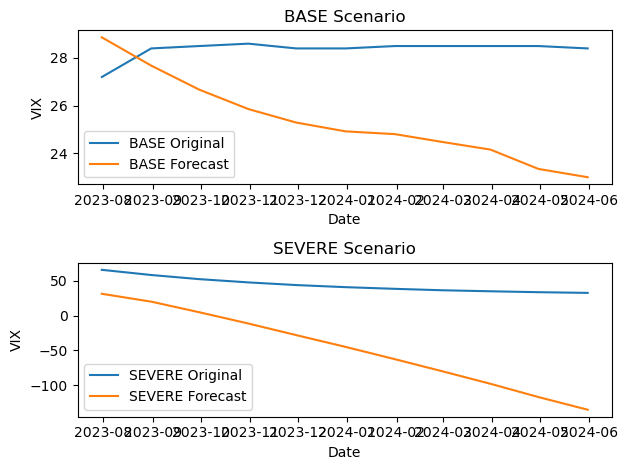

In [1077]:
import matplotlib.pyplot as plt

# Assuming you have base_original_values, BASE_final_forecast, severe_original_values, and SEVERE_final_forecast as defined

# Plotting the BASE scenario
plt.subplot(2, 1, 1)
plt.plot(base_original_values.index, base_original_values['VIX'], label='BASE Original')
plt.plot(BASE_final_forecast.index, BASE_final_forecast['VIX'], label='BASE Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('BASE Scenario')
plt.legend()

# Plotting the SEVERE scenario
plt.subplot(2, 1, 2)
plt.plot(severe_original_values.index, severe_original_values['VIX'], label='SEVERE Original')
plt.plot(SEVERE_final_forecast.index, SEVERE_final_forecast['VIX'], label='SEVERE Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('SEVERE Scenario')
plt.legend()

# Adjusting layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()


#### ARIMAX-GARCH

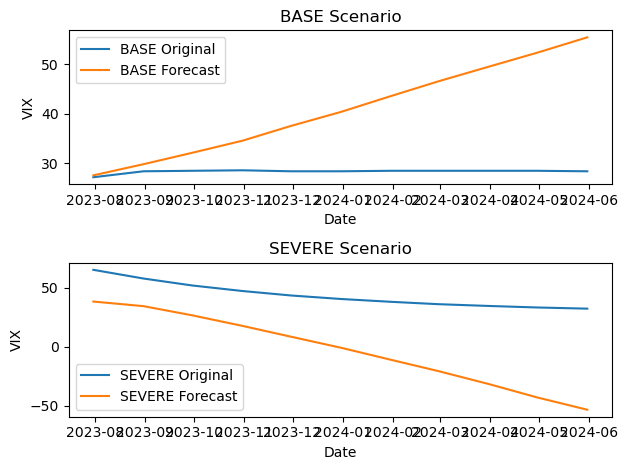

In [1080]:
import matplotlib.pyplot as plt

# Assuming you have base_original_values, BASE_final_forecast, severe_original_values, and SEVERE_final_forecast as defined

# Plotting the BASE scenario
plt.subplot(2, 1, 1)
plt.plot(base_original_values.index, base_original_values['VIX'], label='BASE Original')
plt.plot(BASE_final_forecast_ARIMAX_GARCH.index, BASE_final_forecast_ARIMAX_GARCH['VIX'], label='BASE Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('BASE Scenario')
plt.legend()

# Plotting the SEVERE scenario
plt.subplot(2, 1, 2)
plt.plot(severe_original_values.index, severe_original_values['VIX'], label='SEVERE Original')
plt.plot(SEVERE_final_forecast_ARIMAX_GARCH.index, SEVERE_final_forecast_ARIMAX_GARCH['VIX'], label='SEVERE Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('SEVERE Scenario')
plt.legend()

# Adjusting layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()


#### SARIMAX

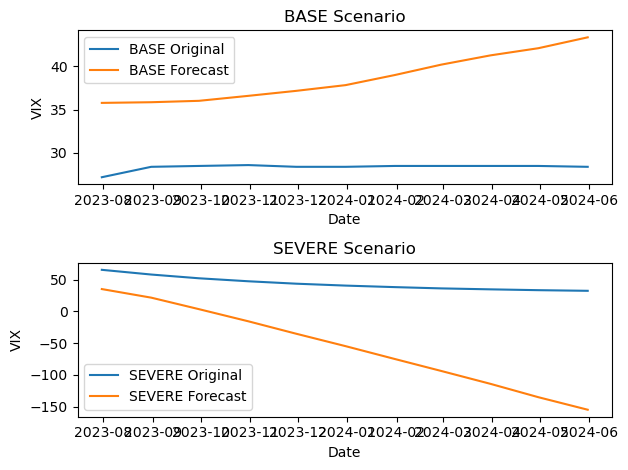

In [1079]:
import matplotlib.pyplot as plt

# Assuming you have base_original_values, BASE_final_forecast, severe_original_values, and SEVERE_final_forecast as defined

# Plotting the BASE scenario
plt.subplot(2, 1, 1)
plt.plot(base_original_values.index, base_original_values['VIX'], label='BASE Original')
plt.plot(BASE_final_forecast_SARIMAX.index, BASE_final_forecast_SARIMAX['VIX'], label='BASE Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('BASE Scenario')
plt.legend()

# Plotting the SEVERE scenario
plt.subplot(2, 1, 2)
plt.plot(severe_original_values.index, severe_original_values['VIX'], label='SEVERE Original')
plt.plot(SEVERE_final_forecast_SARIMAX.index, SEVERE_final_forecast_SARIMAX['VIX'], label='SEVERE Forecast')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('SEVERE Scenario')
plt.legend()

# Adjusting layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()
